### Plan działania
Ten notebook będzie służył do przeprowadzania eksperymentów na czystym klasyfikatorze, czyli model będzie zwracał jedną z 3 klas. W tym celu chcę przeprowadzić następujące eksperymenty : 
1. Porównanie czy skalowanie danych wpływa na jakość wyników oraz jak na dane wpływa Ohe-Hot-Encoding
2. Porównanie jak rozmiar sieci wpływa na wyniki : 1 ukryta warstwa vs 2 ukryte warstwy vs 3 ukryte warstwy
3. Sprawdzenie jak na wyniki wpływa dodanie warstwy BatchNorm1d
4. Sprawdzenie czy dodanie regularyzacji wpływa na wyniki dla ww. modeli
5. Testowanie innych architektur
    - Embeddingi
    - OrdinalLoss
    - LinerRegression na cenie i predykcja w klasę
6. Dostrajanie parametrów

Domyślnie chciałbym osiągnąć wyniki przewyższające 80% - może w okolicy 85%

### Biblioteki

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

import torch.nn as nn

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### MODELE

In [2]:
# First Model
class FirstModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropuot_value):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropuot_value = dropuot_value

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)
        self.actv = nn.ReLU()
        self.dropout = nn.Dropout(self.dropuot_value)

    def forward(self, x):
        x = self.fc1(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Second Model
class SecondModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropuot_value):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropuot_value = dropuot_value

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.actv = nn.ReLU()
        self.dropout = nn.Dropout(self.dropuot_value)

    def forward(self, x):
        x = self.fc1(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Third Model
class ThirdModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropuot_value):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropuot_value = dropuot_value

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc4 = nn.Linear(self.hidden_size, self.output_size)
        self.actv = nn.ReLU()
        self.dropout = nn.Dropout(self.dropuot_value)

    def forward(self, x):
        x = self.fc1(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x


class BatchLayerWith2Layers(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(BatchLayerWith2Layers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.fc3(x)
        return x


class BatchLayerWith3Layers(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(BatchLayerWith3Layers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.fc4(x)
        return x

### Funckje do przygotowywania danych

In [3]:
# function to split data into train and test sets
def split_data(data, test_size, label_column, random_state=42):

    mapping = {'cheap': 0, 'average': 1, 'expensive': 2}
    y = data[label_column].map(mapping)
    X = data.drop(label_column, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test


# function to convert data to PyTorch tensors
def convert_to_tensors(device, x_train, x_test, y_train, y_test):

    X_train_tensor = torch.tensor(x_train.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor


# function to standardize data
def standardize_data(x_train, x_test, columns_to_skip=None):
    if columns_to_skip is None:
        columns_to_skip = []

    columns_to_scale = [col for col in x_train.columns if col not in columns_to_skip]

    # scale only chosen columns
    scaler = StandardScaler()
    x_train_scaled = x_train.copy()
    x_test_scaled = x_test.copy()

    x_train_scaled[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])
    x_test_scaled[columns_to_scale] = scaler.transform(x_test[columns_to_scale])

    return x_train_scaled, x_test_scaled


# function to convert data into PyTorch DataLoader
def create_dataloader(x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, batch_size):
    # create dataloaders from tensor
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

### Główna pętla treningowa


In [4]:
# function to train a model using PyTorch
def train_classifier(
    model,
    optimizer,
    criterion,
    epochs,
    x_train=None,
    y_train=None,
    x_test=None,
    y_test=None,
    train_loader=None,
    test_loader=None,
    use_minibatches=True,
    verbose=True
):
    train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train_samples = 0

        # TRAIN LOOP
        if use_minibatches:
            data_iter = train_loader
        else:
            data_iter = [(x_train, y_train)]

        for xb, yb in data_iter:
            optimizer.zero_grad()
            output = model(xb)

            loss = criterion(output, yb)

            total_train_loss += loss.item() * xb.size(0)
            correct_train += (output.argmax(dim=1) == yb).sum().item()
            total_train_samples += yb.size(0)

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / total_train_samples
        avg_train_acc = correct_train / total_train_samples
        train_loss.append(avg_train_loss)
        train_accuracy.append(avg_train_acc)

        # EVAL LOOP
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test_samples = 0

        with torch.no_grad():
            if use_minibatches:
                data_iter = test_loader
            else:
                data_iter = [(x_test, y_test)]

            for xb, yb in data_iter:
                output = model(xb)
                loss = criterion(output, yb)
                total_test_loss += loss.item() * xb.size(0)
                correct_test += (output.argmax(dim=1) == yb).sum().item()
                total_test_samples += yb.size(0)

        avg_test_loss = total_test_loss / total_test_samples
        avg_test_acc = correct_test / total_test_samples
        test_loss.append(avg_test_loss)
        test_accuracy.append(avg_test_acc)

        if verbose and epoch % 20 == 0:
            print(f"Epoch: {epoch} | Train loss: {avg_train_loss:.4f} | Train acc: {avg_train_acc:.4f} | Test loss: {avg_test_loss:.4f} | Test acc: {avg_test_acc:.4f}")

    return train_accuracy, test_accuracy, train_loss, test_loss

### Funckje do plotowania

In [21]:
# function to plot metrics : accuracy and loss
def plot_metrics(train_accuracy, test_accuracy, train_loss, test_loss, title):
    plt.figure(figsize=(24, 6))

    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.title("Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train loss')
    plt.plot(test_loss, label='Test loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.show()


def evaluate_model_per_class_accuracy(model, x_test, y_test, average_class_acc=False):

    mapping = {0: 'cheap', 1: 'average', 2: 'expensive'}

    model.eval()
    with torch.no_grad():
        outputs = model(x_test)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true = y_test.cpu().numpy()

    classes = np.array(list(mapping.keys()))
    results = {}

    for cls in classes:
        indices = (y_true == cls)
        total = np.sum(indices)
        correct = np.sum(preds[indices] == cls)
        incorrect = total - correct
        acc = correct / total if total > 0 else 0.0
        label = mapping[cls]
        results[label] = {'correct': correct, 'incorrect': incorrect, 'accuracy': acc}
        print(f"Class '{label}': Accuracy: {acc:.2f} (Correct: {correct}, Incorrect: {incorrect}, Total: {total})")

    print(f"Average accuracy: {np.mean([results[label]['accuracy'] for label in results]):.2f}")

    if average_class_acc:
        return np.mean([results[label]['accuracy'] for label in results])

    # prepare results for plotting
    labels = list(results.keys())
    correct_counts = [results[label]['correct'] for label in labels]
    incorrect_counts = [results[label]['incorrect'] for label in labels]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, correct_counts, width, label='Correct', color='green')
    plt.bar(x + width/2, incorrect_counts, width, label='Incorrect', color='red')
    plt.xticks(x, labels)
    plt.ylabel('Amount of predictions')
    plt.title('TP and FP per class')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return results

def plot_confusion_matrix(model, x_test, y_test, label_encoder=None, normalize='false'):
    mapping = {0: 'cheap', 1: 'average', 2: 'expensive'}

    model.eval()
    with torch.no_grad():
        outputs = model(x_test)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true = y_test.cpu().numpy()

    cm = confusion_matrix(y_true, preds)

    if normalize is not None and normalize.lower() == 'true':
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    unique_classes = np.unique(y_true)
    labels = [mapping[cls] for cls in unique_classes]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f')
    plt.title(title)
    plt.show()

### Funkcje pomocnicze do przeprowadzania eksperymentów

In [6]:
def build_model_and_optimizer(device, model_class, input_size, hidden_size, output_size, dropout, learning_rate, weight_decay = 0):

    model = model_class(input_size, hidden_size, output_size, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    return model, optimizer, criterion

def run_experiment(
    title: str,
    model_class,
    optimizer_class,
    criterion,
    x_train=None,
    y_train=None,
    x_test=None,
    y_test=None,
    train_loader=None,
    test_loader=None,
    use_minibatch=True,
    epochs=500,
    seed=42,
    verbose=True,
    is_plot=True,
    return_model=False
):
    # set deterministic seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"\n--- Running: {title} ---")

    train_acc, test_acc, train_loss, test_loss = train_classifier(
        model=model_class,
        optimizer=optimizer_class,
        criterion=criterion,
        epochs=epochs,
        x_train=x_train,
        y_train=y_train,
        x_test=x_test,
        y_test=y_test,
        train_loader=train_loader,
        test_loader=test_loader,
        use_minibatches=use_minibatch,
        verbose=verbose,
    )
    if is_plot:
        plot_metrics(train_acc, test_acc, train_loss, test_loss, title)

    print(f"Train accuracy: {train_acc[-1]:.4f} | Test accuracy: {test_acc[-1]:.4f}")
    print(f"Train loss: {train_loss[-1]:.4f} | Test loss: {test_loss[-1]:.4f}")

    if return_model:
        return train_acc, test_acc, train_loss, test_loss, model_class
    else:
        return train_acc, test_acc, train_loss, test_loss

### Ustawienie "device"

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Wczytanie danych i porównanie wyników między czystymi a zakodowanymi OHE (oba warianty ze skalowaniem)

In [8]:
clear_data_path = 'processed_data/train_data_with_labels.csv'
ohe_data_path = 'processed_data/train_data_with_labels_ohe.csv'

clear_data = pd.read_csv(clear_data_path)
ohe_data = pd.read_csv(ohe_data_path)

display(clear_data.head(5))
display(ohe_data.head(5))

SalePrice  YearBuilt  Size(sqf)  Floor HallwayType         HeatingType  \
0     141592       2006        814      3    terraced  individual_heating   
1      51327       1985        587      8    corridor  individual_heating   
2      48672       1985        587      6    corridor  individual_heating   
3     380530       2006       2056      8    terraced  individual_heating   
4      78318       1992        644      2       mixed  individual_heating   

         AptManageType  N_Parkinglot(Ground)  N_Parkinglot(Basement)  \
0  management_in_trust                 111.0                   184.0   
1      self_management                  80.0                    76.0   
2      self_management                  80.0                    76.0   
3  management_in_trust                 249.0                   536.0   
4      self_management                 142.0                    79.0   

  TimeToBusStop TimeToSubway  N_manager  N_elevators          SubwayStation  \
0    5min~10min  10min~15min        3.0          0.0  Kyungbuk_uni_hospital   
1        0~5min   5min~10min        2.0          2.0                  Daegu   
2        0~5min   5min~10min        2.0          2.0                  Daegu   
3        0~5min       0-5min        5.0         11.0                Sin-nam   
4    5min~10min  15min~20min        4.0          8.0              Myung-duk   

   N_FacilitiesInApt  N_FacilitiesNearBy(Total)  N_SchoolNearBy(Total)  \
0                  5                        6.0                    9.0   
1                  3                       12.0                    4.0   
2                  3                       12.0                    4.0   
3                  5                        3.0                    7.0   
4                  3                        9.0                   14.0   

       label  
0    average  
1      cheap  
2      cheap  
3  expensive  
4      cheap

SalePrice  YearBuilt  Size(sqf)  Floor  N_Parkinglot(Ground)  \
0     141592       2006        814      3                 111.0   
1      51327       1985        587      8                  80.0   
2      48672       1985        587      6                  80.0   
3     380530       2006       2056      8                 249.0   
4      78318       1992        644      2                 142.0   

   N_Parkinglot(Basement)  N_manager  N_elevators  N_FacilitiesInApt  \
0                   184.0        3.0          0.0                  5   
1                    76.0        2.0          2.0                  3   
2                    76.0        2.0          2.0                  3   
3                   536.0        5.0         11.0                  5   
4                    79.0        4.0          8.0                  3   

   N_FacilitiesNearBy(Total)  ...  TimeToSubway_5min~10min  \
0                        6.0  ...                      0.0   
1                       12.0  ...                      1.0   
2                       12.0  ...                      1.0   
3                        3.0  ...                      0.0   
4                        9.0  ...                      0.0   

  TimeToSubway_no_bus_stop_nearby  SubwayStation_Bangoge  \
0                             0.0                    0.0   
1                             0.0                    0.0   
2                             0.0                    0.0   
3                             0.0                    0.0   
4                             0.0                    0.0   

   SubwayStation_Banwoldang  SubwayStation_Chil-sung-market  \
0                       0.0                             0.0   
1                       0.0                             0.0   
2                       0.0                             0.0   
3                       0.0                             0.0   
4                       0.0                             0.0   

   SubwayStation_Daegu  SubwayStation_Kyungbuk_uni_hospital  \
0                  0.0                                  1.0   
1                  1.0                                  0.0   
2                  1.0                                  0.0   
3                  0.0                                  0.0   
4                  0.0                                  0.0   

   SubwayStation_Myung-duk  SubwayStation_Sin-nam  \
0                      0.0                    0.0   
1                      0.0                    0.0   
2                      0.0                    0.0   
3                      0.0                    1.0   
4                      1.0                    0.0   

   SubwayStation_no_subway_nearby  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  

[5 rows x 35 columns]

### Podział danych na czyste, przeskalowane

In [9]:
COLUMNS_TO_DROP = ['SalePrice', 'HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation']
TEST_SIZE = 0.2
RANDOM_STATE = 42
COLUMNS_TO_SKIP_SCALING = ['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced',
                           'HeatingType_central_heating', 'HeatingType_individual_heating',
                           'AptManageType_management_in_trust', 'AptManageType_self_management',
                           'TimeToBusStop_0~5min', 'TimeToBusStop_10min~15min', 'TimeToBusStop_5min~10min',
                           'TimeToSubway_0-5min', 'TimeToSubway_10min~15min', 'TimeToSubway_15min~20min',
                           'TimeToSubway_5min~10min', 'TimeToSubway_no_bus_stop_nearby',
                           'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market',
                           'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk',
                           'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']
# read data
clear_data = pd.read_csv(clear_data_path)
ohe_data = pd.read_csv(ohe_data_path)


clear_data = clear_data.drop(columns=COLUMNS_TO_DROP)
ohe_data = ohe_data.drop(columns=['SalePrice'])

# clear
x_train, x_test, y_train, y_test = split_data(clear_data, test_size=TEST_SIZE, label_column='label', random_state=RANDOM_STATE)
x_train_scaled, x_test_scaled = standardize_data(x_train, x_test, columns_to_skip=None)

# Use this for training
x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = convert_to_tensors(device, x_train, x_test, y_train, y_test)
x_train_tensor_scaled, x_test_tensor_scaled, y_train_tensor, y_test_tensor = convert_to_tensors(device, x_train_scaled, x_test_scaled, y_train, y_test)

# ohe data
x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = split_data(ohe_data, test_size=TEST_SIZE, label_column='label', random_state=RANDOM_STATE)
x_train_ohe_scaled, x_test_ohe_scaled = standardize_data(x_train_ohe, x_test_ohe, columns_to_skip=COLUMNS_TO_SKIP_SCALING)

# Use this for training
x_train_ohe_tensor, x_test_ohe_tensor, y_train_ohe_tensor, y_test_ohe_tensor = convert_to_tensors(device, x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe)
x_train_ohe_tensor_scaled, x_test_ohe_tensor_scaled, y_train_ohe_tensor_scaled, y_test_ohe_tensor_scaled = convert_to_tensors(device, x_train_ohe_scaled, x_test_ohe_scaled, y_train_ohe, y_test_ohe)



### Czyste dane, brak skalowania


--- Running: First Model - Clear Data, No Standarization ---
Epoch: 0 | Train loss: 32.2854 | Train acc: 0.6144 | Test loss: 20.6961 | Test acc: 0.7261
Epoch: 20 | Train loss: 24.4162 | Train acc: 0.5990 | Test loss: 10.9309 | Test acc: 0.7418
Epoch: 40 | Train loss: 17.9159 | Train acc: 0.6360 | Test loss: 6.0414 | Test acc: 0.8024
Epoch: 60 | Train loss: 14.1010 | Train acc: 0.6578 | Test loss: 4.3810 | Test acc: 0.8182
Epoch: 80 | Train loss: 11.0658 | Train acc: 0.6705 | Test loss: 3.6252 | Test acc: 0.8036
Epoch: 100 | Train loss: 9.1434 | Train acc: 0.6993 | Test loss: 3.3561 | Test acc: 0.7855
Epoch: 120 | Train loss: 7.8033 | Train acc: 0.6951 | Test loss: 3.2308 | Test acc: 0.7745
Epoch: 140 | Train loss: 6.3152 | Train acc: 0.7126 | Test loss: 3.0803 | Test acc: 0.7830
Epoch: 160 | Train loss: 5.5889 | Train acc: 0.7032 | Test loss: 2.6885 | Test acc: 0.7879
Epoch: 180 | Train loss: 4.9387 | Train acc: 0.7129 | Test loss: 2.0152 | Test acc: 0.7952
Epoch: 200 | Train loss: 4.

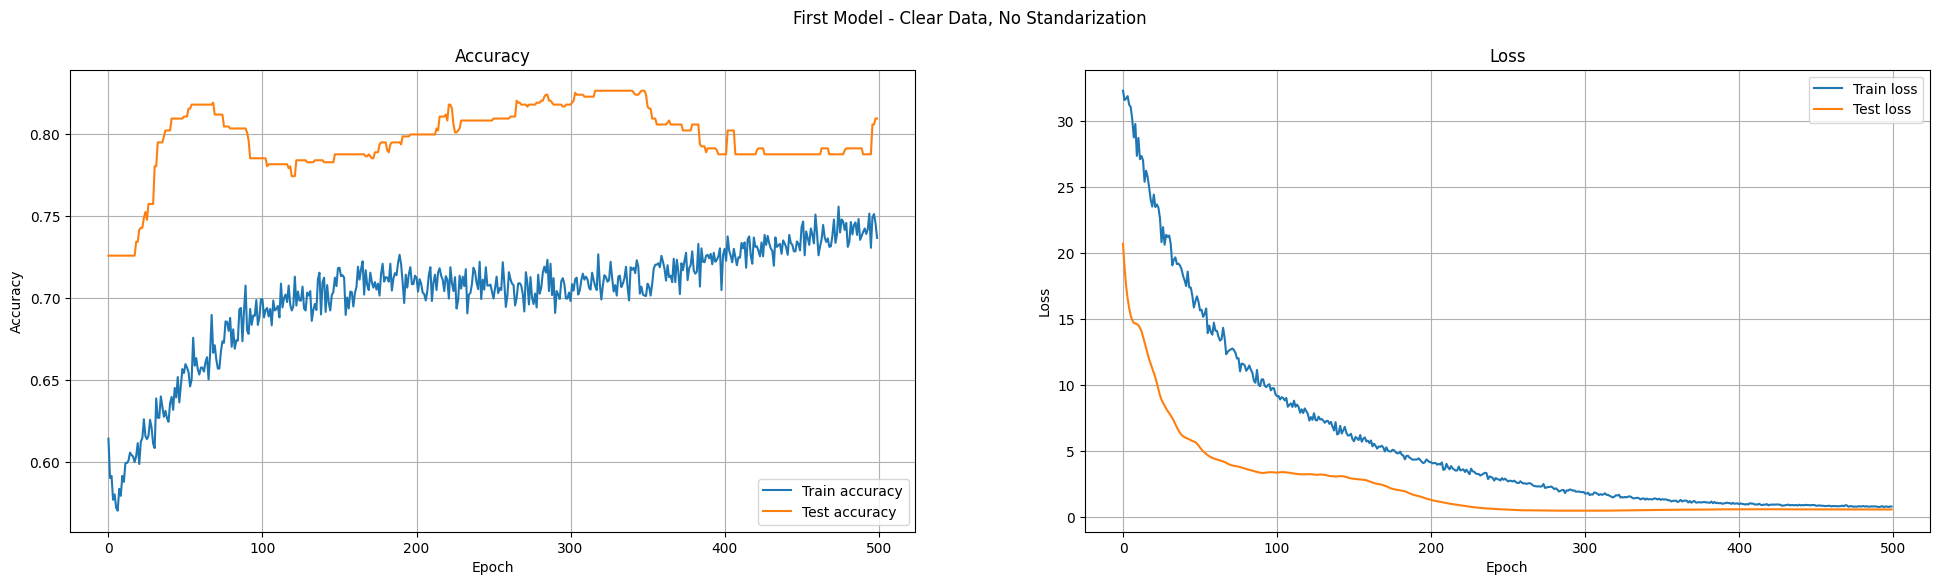

Train accuracy: 0.7369 | Test accuracy: 0.8097
Train loss: 0.7827 | Test loss: 0.5606
Class 'cheap': Accuracy: 0.35 (Correct: 39, Incorrect: 73, Total: 112)
Class 'average': Accuracy: 0.97 (Correct: 579, Incorrect: 20, Total: 599)
Class 'expensive': Accuracy: 0.44 (Correct: 50, Incorrect: 64, Total: 114)
Average accuracy: 0.58


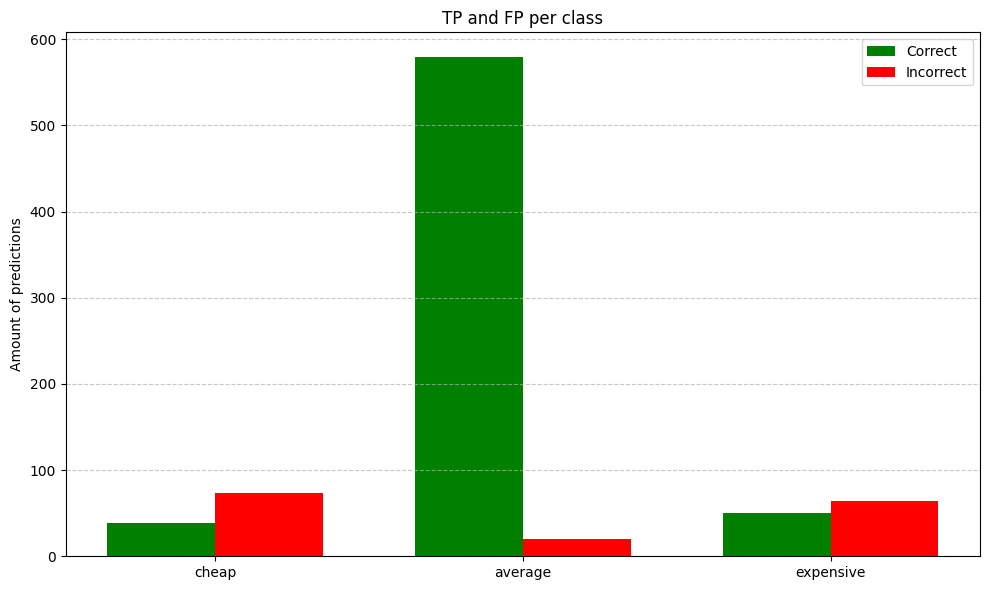

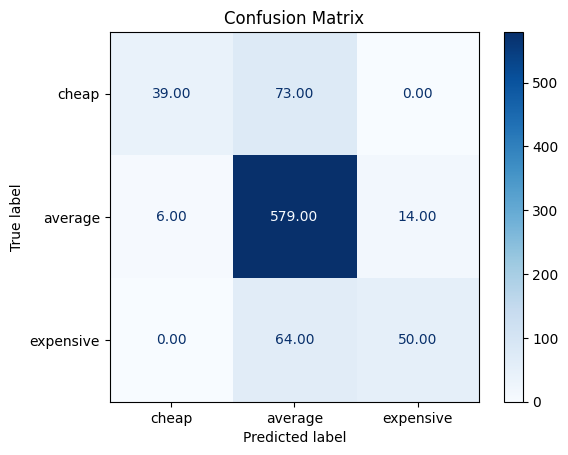

In [55]:
EPOCHS = 500
LR = 0.0001
HIDDEN_SIZE = 128
OUTPUT_SIZE = 3
DROPOUT = 0.2
WEIGHT_DECAY = 0 # 0 to not use the regularization

model, optimizer, criterion = build_model_and_optimizer(device, FirstModel, x_train_tensor.shape[1], HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)
train_acc, test_acc, train_loss, test_loss, model = run_experiment(
    "First Model - Clear Data, No Standarization",
    model,
    optimizer,
    criterion,
    x_train_tensor,
    y_train_tensor,
    x_test_tensor,
    y_test_tensor,
    epochs=EPOCHS,
    verbose=True,
    is_plot=True,
    return_model=True,
    use_minibatch=False
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model, x_test_tensor, y_test_tensor)
plot_confusion_matrix(model, x_test_tensor, y_test_tensor)

### Czyste i przeskalowane dane


--- Running: First Model - Clear Data, No Standarization ---
Epoch: 0 | Train loss: 1.1057 | Train acc: 0.1979 | Test loss: 1.1034 | Test acc: 0.2085
Epoch: 20 | Train loss: 1.0075 | Train acc: 0.5386 | Test loss: 1.0022 | Test acc: 0.6655
Epoch: 40 | Train loss: 0.9144 | Train acc: 0.7375 | Test loss: 0.9100 | Test acc: 0.7261
Epoch: 60 | Train loss: 0.8319 | Train acc: 0.7305 | Test loss: 0.8265 | Test acc: 0.7261
Epoch: 80 | Train loss: 0.7610 | Train acc: 0.7278 | Test loss: 0.7557 | Test acc: 0.7261
Epoch: 100 | Train loss: 0.7058 | Train acc: 0.7284 | Test loss: 0.6984 | Test acc: 0.7261
Epoch: 120 | Train loss: 0.6565 | Train acc: 0.7396 | Test loss: 0.6513 | Test acc: 0.7370
Epoch: 140 | Train loss: 0.6157 | Train acc: 0.7460 | Test loss: 0.6111 | Test acc: 0.7636
Epoch: 160 | Train loss: 0.5825 | Train acc: 0.7684 | Test loss: 0.5764 | Test acc: 0.7818
Epoch: 180 | Train loss: 0.5530 | Train acc: 0.7924 | Test loss: 0.5469 | Test acc: 0.8048
Epoch: 200 | Train loss: 0.5311 | 

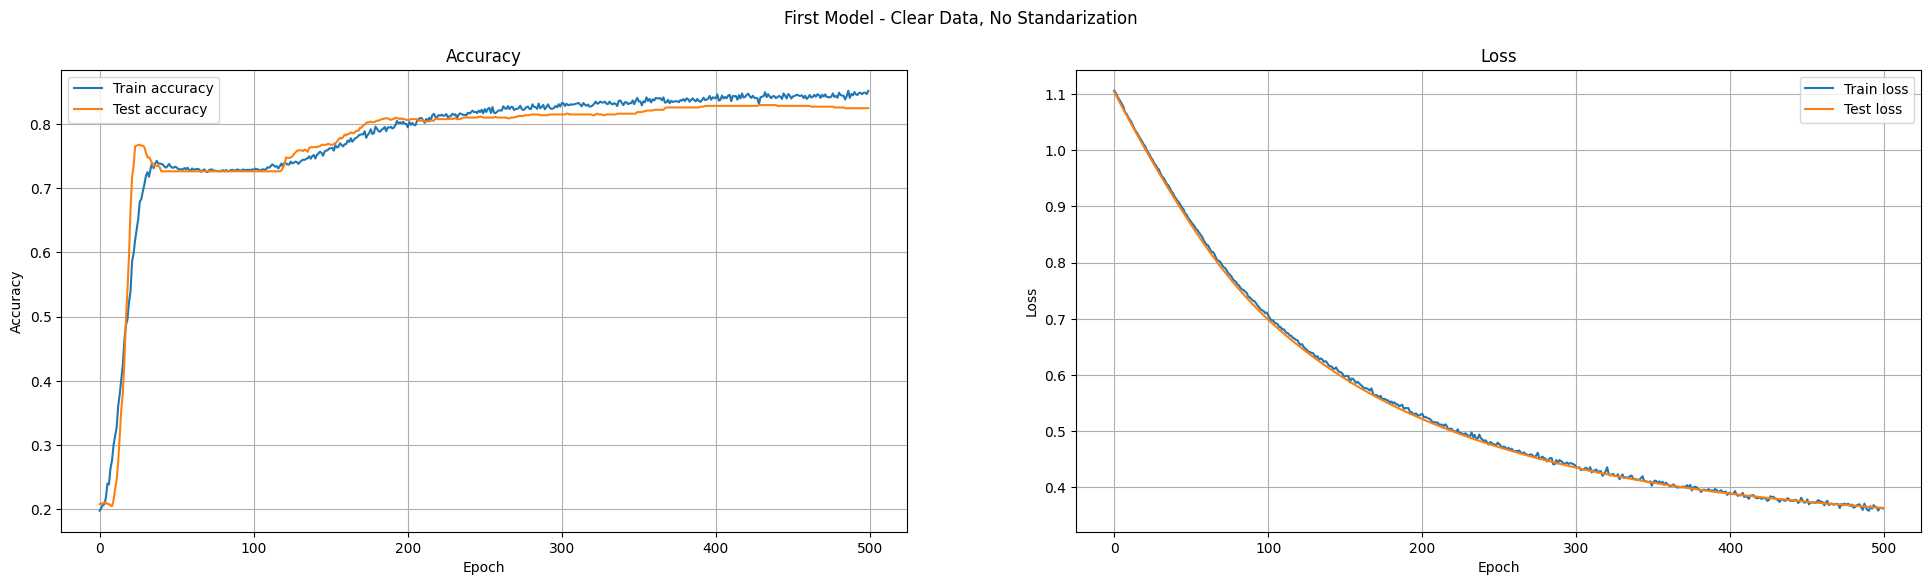

Train accuracy: 0.8512 | Test accuracy: 0.8242
Train loss: 0.3626 | Test loss: 0.3635
Class 'cheap': Accuracy: 0.57 (Correct: 64, Incorrect: 48, Total: 112)
Class 'average': Accuracy: 0.90 (Correct: 539, Incorrect: 60, Total: 599)
Class 'expensive': Accuracy: 0.68 (Correct: 77, Incorrect: 37, Total: 114)
Average accuracy: 0.72


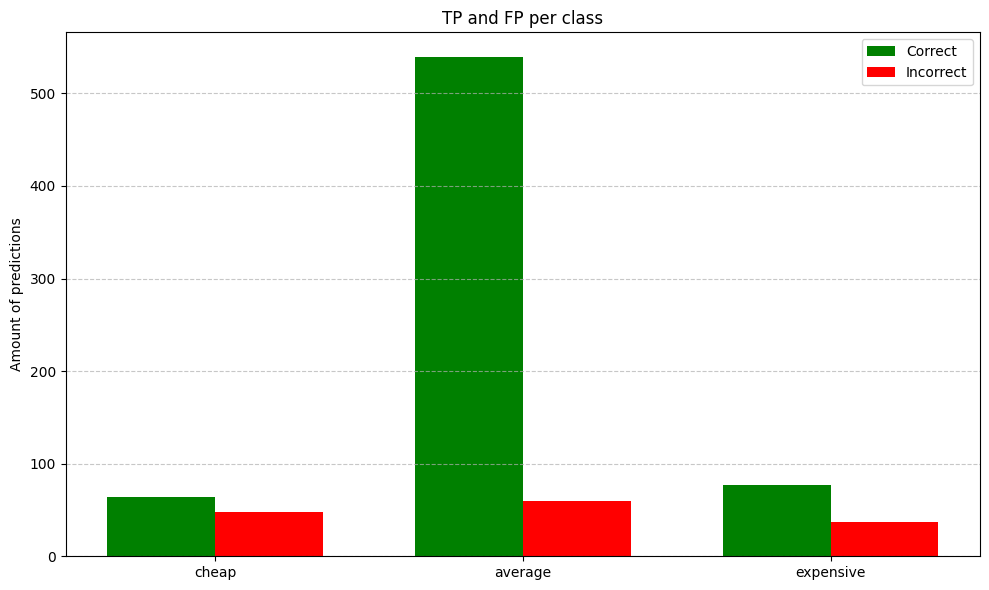

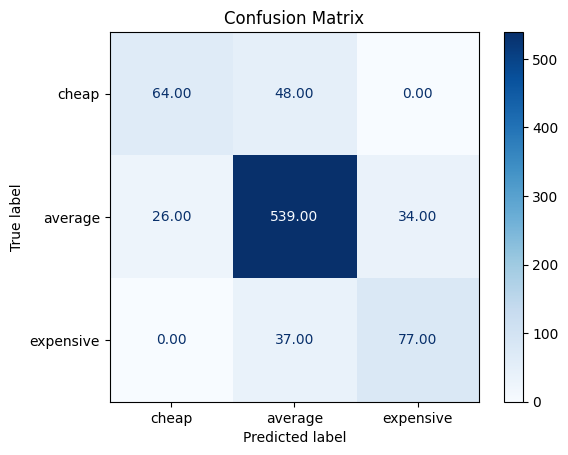

In [56]:
EPOCHS = 500
LR = 0.0001
HIDDEN_SIZE = 128
OUTPUT_SIZE = 3
DROPOUT = 0.2
WEIGHT_DECAY = 0 # 0 to not use the regularization

model, optimizer, criterion = build_model_and_optimizer(device, FirstModel, x_train_tensor_scaled.shape[1], HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)
train_acc, test_acc, train_loss, test_loss, model = run_experiment(
    "First Model - Clear Data, No Standarization",
    model,
    optimizer,
    criterion,
    x_train_tensor_scaled,
    y_train_tensor,
    x_test_tensor_scaled,
    y_test_tensor,
    epochs=EPOCHS,
    verbose=True,
    is_plot=True,
    return_model=True,
    use_minibatch=False
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model, x_test_tensor_scaled, y_test_tensor)
plot_confusion_matrix(model, x_test_tensor_scaled, y_test_tensor)

### One-Hot-Encoding i brak skalowania 


--- Running: First Model - OHE Data, No Standarization ---
Epoch: 0 | Train loss: 27.0476 | Train acc: 0.3607 | Test loss: 12.4609 | Test acc: 0.2400
Epoch: 20 | Train loss: 12.4970 | Train acc: 0.6211 | Test loss: 8.1784 | Test acc: 0.7261
Epoch: 40 | Train loss: 10.4549 | Train acc: 0.6062 | Test loss: 4.8728 | Test acc: 0.7345
Epoch: 60 | Train loss: 9.1084 | Train acc: 0.6247 | Test loss: 2.9715 | Test acc: 0.7648
Epoch: 80 | Train loss: 7.3879 | Train acc: 0.6554 | Test loss: 2.3032 | Test acc: 0.8145
Epoch: 100 | Train loss: 6.7057 | Train acc: 0.6741 | Test loss: 2.0323 | Test acc: 0.8291
Epoch: 120 | Train loss: 5.6418 | Train acc: 0.6963 | Test loss: 2.0384 | Test acc: 0.8012
Epoch: 140 | Train loss: 5.1971 | Train acc: 0.6926 | Test loss: 2.1263 | Test acc: 0.7867
Epoch: 160 | Train loss: 4.7167 | Train acc: 0.7011 | Test loss: 2.2371 | Test acc: 0.7952
Epoch: 180 | Train loss: 4.3514 | Train acc: 0.7123 | Test loss: 2.2227 | Test acc: 0.7952
Epoch: 200 | Train loss: 3.7719 

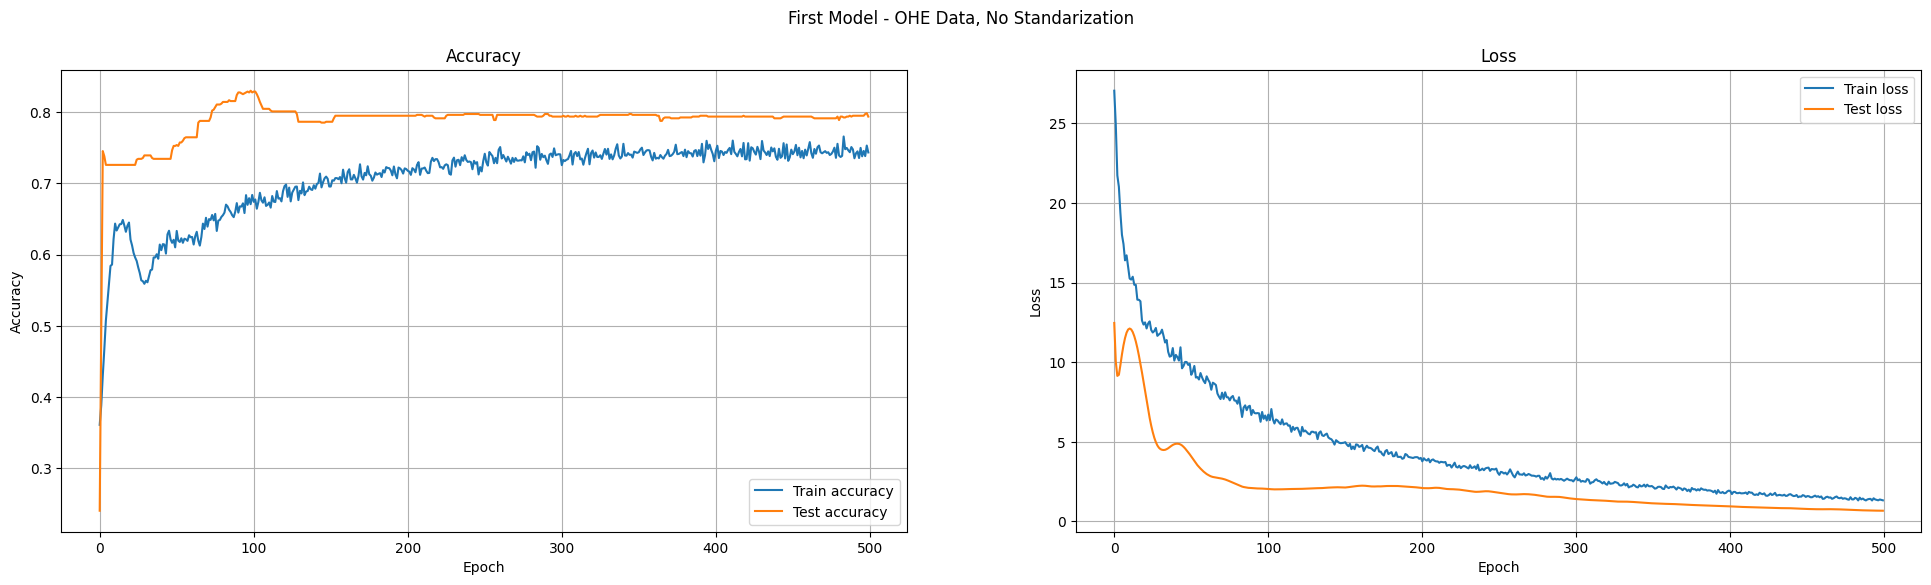

Train accuracy: 0.7436 | Test accuracy: 0.7939
Train loss: 1.3219 | Test loss: 0.6688
Class 'cheap': Accuracy: 0.79 (Correct: 88, Incorrect: 24, Total: 112)
Class 'average': Accuracy: 0.84 (Correct: 506, Incorrect: 93, Total: 599)
Class 'expensive': Accuracy: 0.54 (Correct: 61, Incorrect: 53, Total: 114)
Average accuracy: 0.72


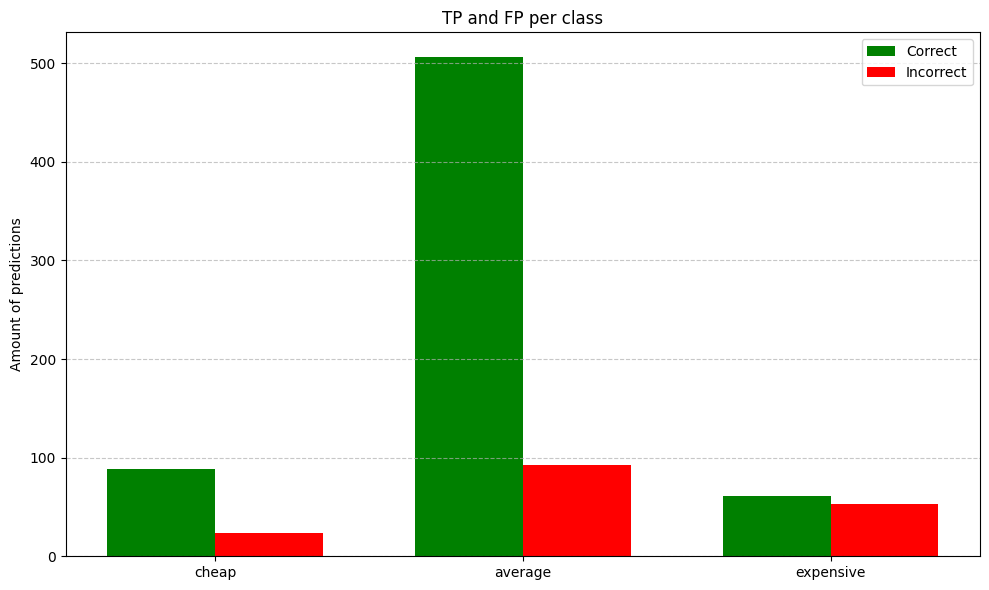

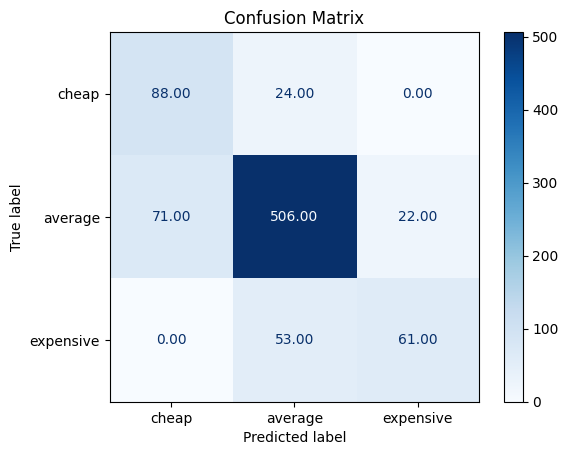

In [57]:
EPOCHS = 500
LR = 0.0001
HIDDEN_SIZE = 128
OUTPUT_SIZE = 3
DROPOUT = 0.2
WEIGHT_DECAY = 0 # 0 to not use the regularization

model, optimizer, criterion = build_model_and_optimizer(device, FirstModel, x_train_ohe_tensor.shape[1], HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)
train_acc, test_acc, train_loss, test_loss, model = run_experiment(
    "First Model - OHE Data, No Standarization",
    model,
    optimizer,
    criterion,
    x_train_ohe_tensor,
    y_train_ohe_tensor,
    x_test_ohe_tensor,
    y_test_ohe_tensor,
    epochs=EPOCHS,
    verbose=True,
    is_plot=True,
    return_model=True,
    use_minibatch=False
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model, x_test_ohe_tensor, y_test_ohe_tensor)
plot_confusion_matrix(model, x_test_ohe_tensor, y_test_ohe_tensor)

### One-Hot-Encoding i skalowane dane


--- Running: First Model - OHE Data, Standarization ---
Epoch: 0 | Train loss: 1.0855 | Train acc: 0.3522 | Test loss: 1.0795 | Test acc: 0.4448
Epoch: 20 | Train loss: 1.0071 | Train acc: 0.7157 | Test loss: 1.0024 | Test acc: 0.7261
Epoch: 40 | Train loss: 0.9346 | Train acc: 0.7257 | Test loss: 0.9288 | Test acc: 0.7261
Epoch: 60 | Train loss: 0.8605 | Train acc: 0.7254 | Test loss: 0.8551 | Test acc: 0.7261
Epoch: 80 | Train loss: 0.7907 | Train acc: 0.7254 | Test loss: 0.7852 | Test acc: 0.7261
Epoch: 100 | Train loss: 0.7335 | Train acc: 0.7254 | Test loss: 0.7272 | Test acc: 0.7261
Epoch: 120 | Train loss: 0.6870 | Train acc: 0.7254 | Test loss: 0.6804 | Test acc: 0.7261
Epoch: 140 | Train loss: 0.6439 | Train acc: 0.7254 | Test loss: 0.6383 | Test acc: 0.7261
Epoch: 160 | Train loss: 0.6045 | Train acc: 0.7284 | Test loss: 0.5974 | Test acc: 0.7261
Epoch: 180 | Train loss: 0.5643 | Train acc: 0.7478 | Test loss: 0.5582 | Test acc: 0.7382
Epoch: 200 | Train loss: 0.5264 | Train

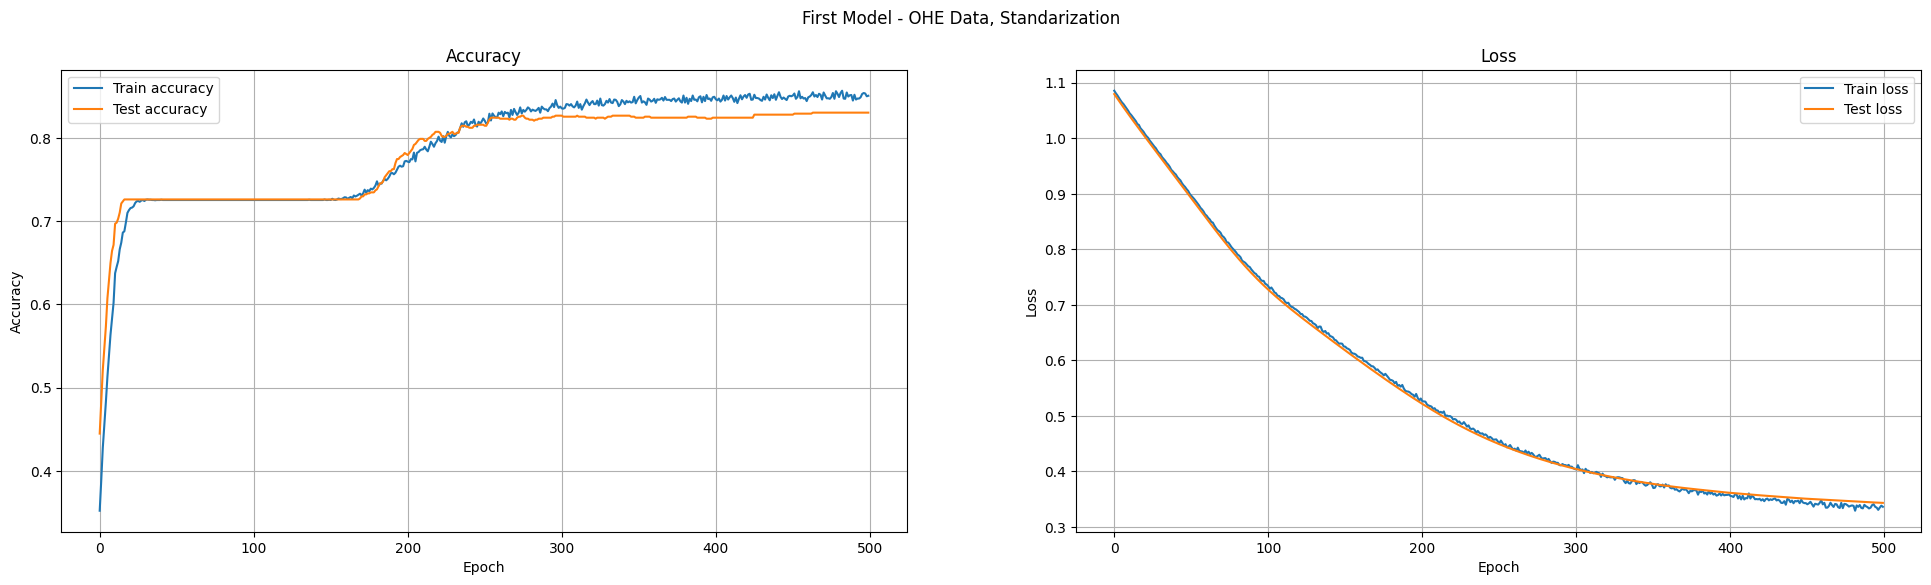

Train accuracy: 0.8506 | Test accuracy: 0.8303
Train loss: 0.3362 | Test loss: 0.3433
Class 'cheap': Accuracy: 0.57 (Correct: 64, Incorrect: 48, Total: 112)
Class 'average': Accuracy: 0.89 (Correct: 535, Incorrect: 64, Total: 599)
Class 'expensive': Accuracy: 0.75 (Correct: 86, Incorrect: 28, Total: 114)
Average accuracy: 0.74


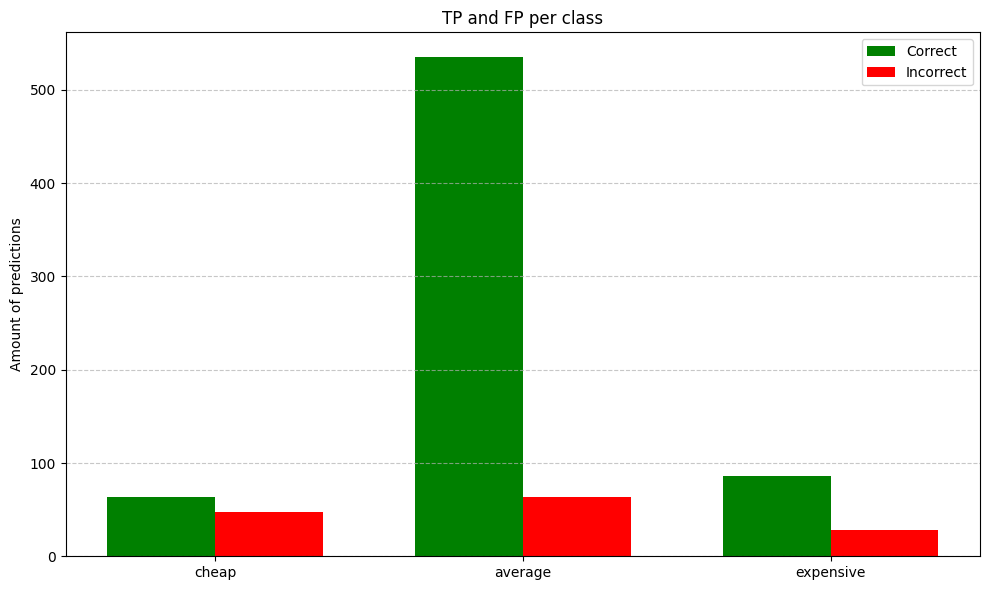

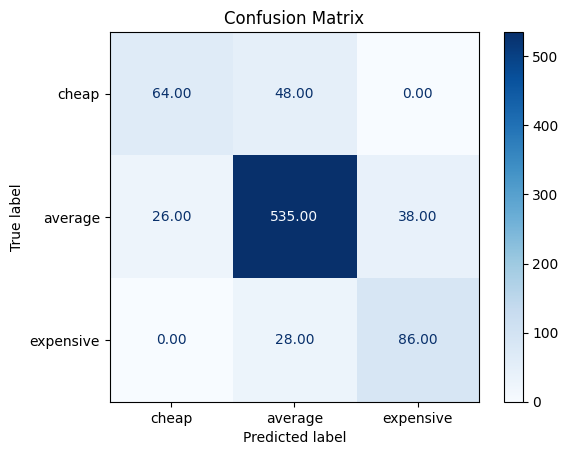

In [58]:
EPOCHS = 500
LR = 0.0001
HIDDEN_SIZE = 128
OUTPUT_SIZE = 3
DROPOUT = 0.2
WEIGHT_DECAY = 0 # 0 to not use the regularization

model, optimizer, criterion = build_model_and_optimizer(device, FirstModel, x_train_ohe_tensor_scaled.shape[1], HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)
train_acc, test_acc, train_loss, test_loss, model = run_experiment(
    "First Model - OHE Data, Standarization",
    model,
    optimizer,
    criterion,
    x_train_ohe_tensor_scaled,
    y_train_ohe_tensor,
    x_test_ohe_tensor_scaled,
    y_test_ohe_tensor_scaled,
    epochs=EPOCHS,
    verbose=True,
    is_plot=True,
    return_model=True,
    use_minibatch=False
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
plot_confusion_matrix(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

### Wnioski
1. Dodanie dodatkowych atrybutów w postaci OHE zwiększa accuracy w zancznym stopniu
2. Skalowanie danych także poprawia accuracy
3. Łączny zanotowany skosk acc z 58% do 72%+

# 2. Przetestowanie rozmiarów sieci : ilość ukrytych warstw i ukrytych neuronów
    1. Model z dwoma ukrytymi warstwami : FirstModel
    2. Model z jedną ukrytą warstwą : SecondModel
    3. Model z 3 ukrytymi warstwami : ThirdModel

Do wszystkich modeli będę stosował:
- LR = 0.0001
- brak regularyzacji
- każdy model przetestuje na kilku wartościach ukrytych neuronów w warstwie
- ReLu jako funckję aktywacji
- Dropout = 0.2

Celem jest sprawdzenie jaka architektura może być najlepsza do zastosowania w tym zadaniu

In [10]:
LR = 0.0001
HIDDEN_SIZES = [64, 128, 256, 512, 1024]
OUTPUT_SIZE = 3
DROPOUT = 0.2
EPOCHS = 500
WEIGHT_DECAY = 0

def format_results_to_df(results):
    results_df = pd.DataFrame({k: {metric: v[-1] for metric, v in metrics.items()} for k, metrics in results.items()}).T
    for column in results_df.columns:
        if 'acc' in column:
            results_df[column] = results_df[column].map(lambda x: f"{x:.2%}")
    return results_df


## 2.1 Model z jedną ukrytą warstwą


--- Running: Second Model - OHE Data, Standarization, Hidden Size: 64 ---
Train accuracy: 0.7893 | Test accuracy: 0.8036
Train loss: 0.5665 | Test loss: 0.5683
Class 'cheap': Accuracy: 0.38 (Correct: 43, Incorrect: 69, Total: 112)
Class 'average': Accuracy: 0.96 (Correct: 577, Incorrect: 22, Total: 599)
Class 'expensive': Accuracy: 0.38 (Correct: 43, Incorrect: 71, Total: 114)
Average accuracy: 0.57


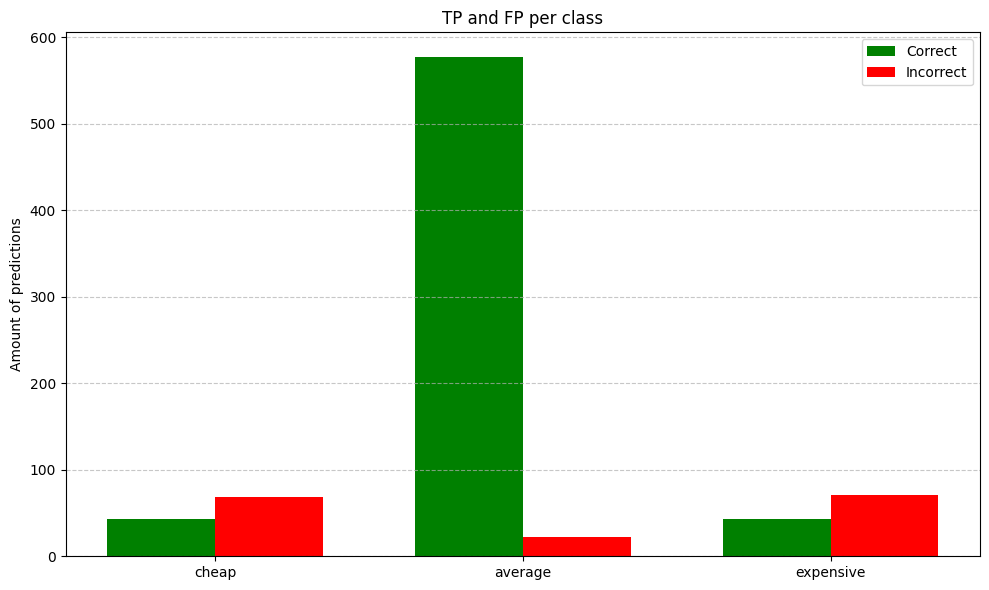

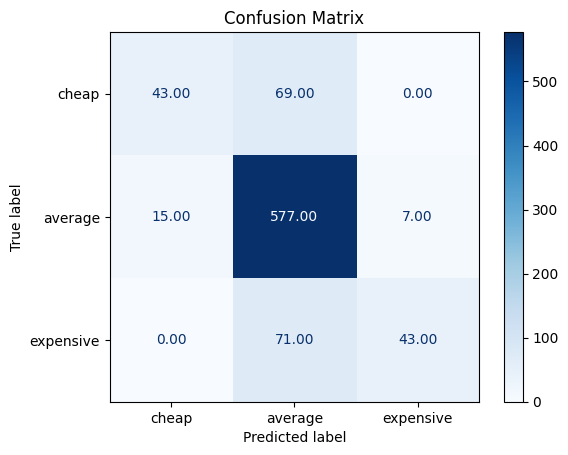


--- Running: Second Model - OHE Data, Standarization, Hidden Size: 128 ---
Train accuracy: 0.8227 | Test accuracy: 0.8158
Train loss: 0.4613 | Test loss: 0.4634
Class 'cheap': Accuracy: 0.54 (Correct: 60, Incorrect: 52, Total: 112)
Class 'average': Accuracy: 0.93 (Correct: 560, Incorrect: 39, Total: 599)
Class 'expensive': Accuracy: 0.46 (Correct: 53, Incorrect: 61, Total: 114)
Average accuracy: 0.65


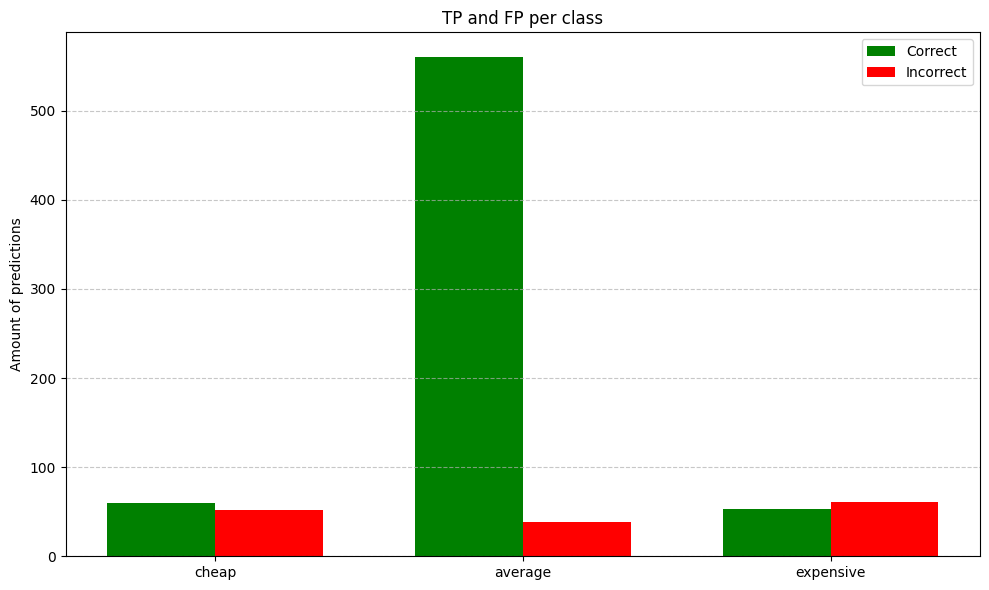

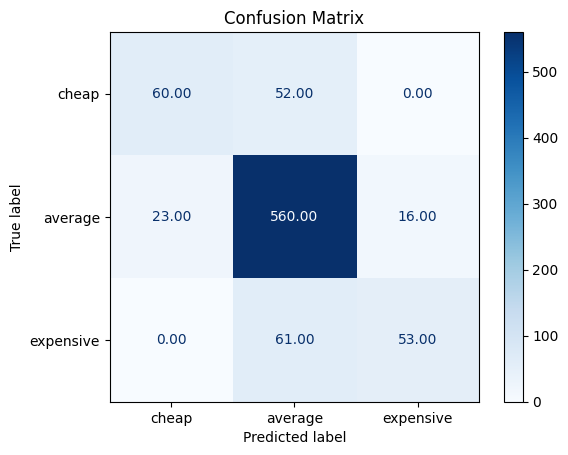


--- Running: Second Model - OHE Data, Standarization, Hidden Size: 256 ---
Train accuracy: 0.8457 | Test accuracy: 0.8255
Train loss: 0.3872 | Test loss: 0.3974
Class 'cheap': Accuracy: 0.57 (Correct: 64, Incorrect: 48, Total: 112)
Class 'average': Accuracy: 0.91 (Correct: 545, Incorrect: 54, Total: 599)
Class 'expensive': Accuracy: 0.63 (Correct: 72, Incorrect: 42, Total: 114)
Average accuracy: 0.70


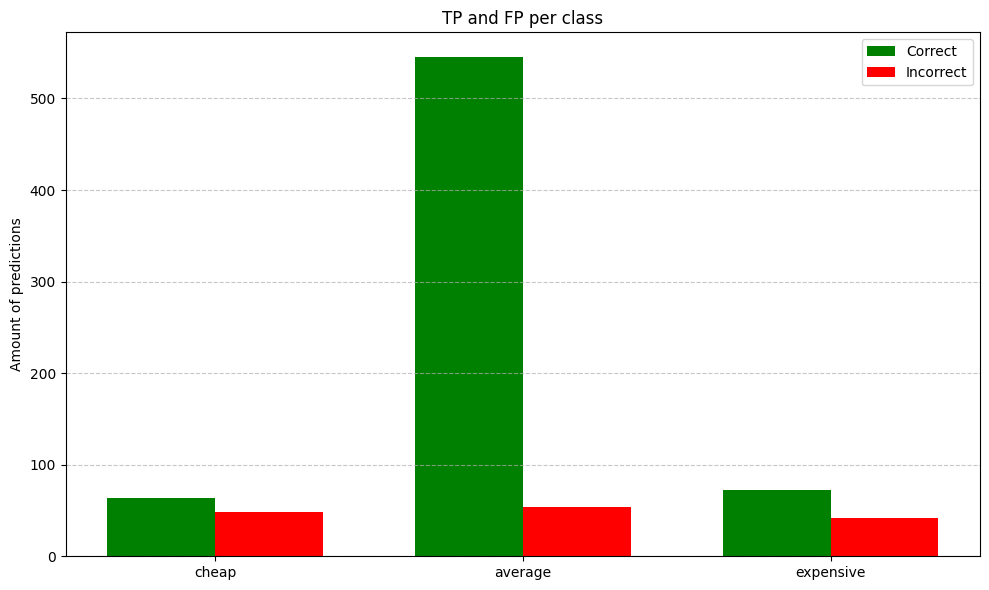

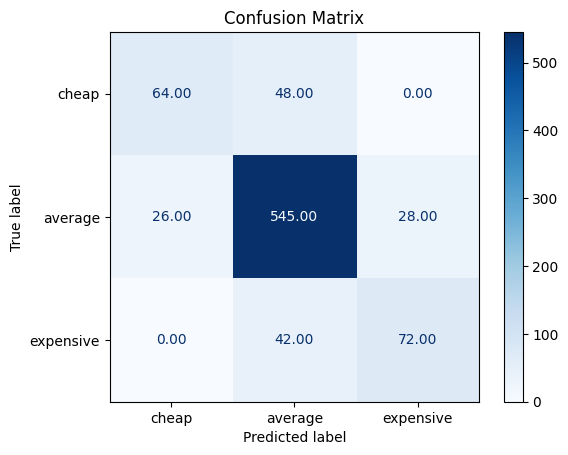


--- Running: Second Model - OHE Data, Standarization, Hidden Size: 512 ---
Train accuracy: 0.8533 | Test accuracy: 0.8279
Train loss: 0.3477 | Test loss: 0.3650
Class 'cheap': Accuracy: 0.57 (Correct: 64, Incorrect: 48, Total: 112)
Class 'average': Accuracy: 0.90 (Correct: 538, Incorrect: 61, Total: 599)
Class 'expensive': Accuracy: 0.71 (Correct: 81, Incorrect: 33, Total: 114)
Average accuracy: 0.73


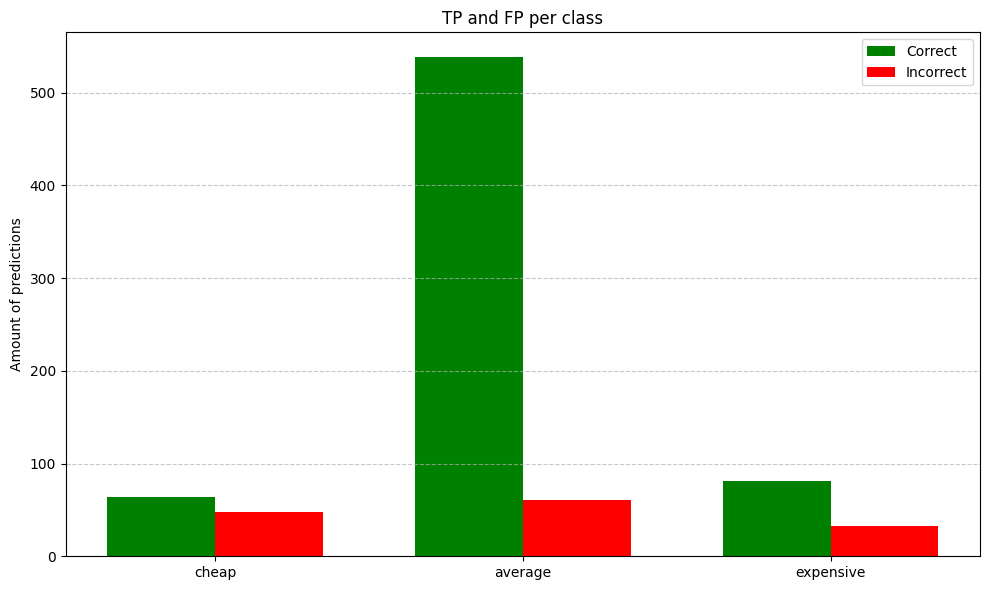

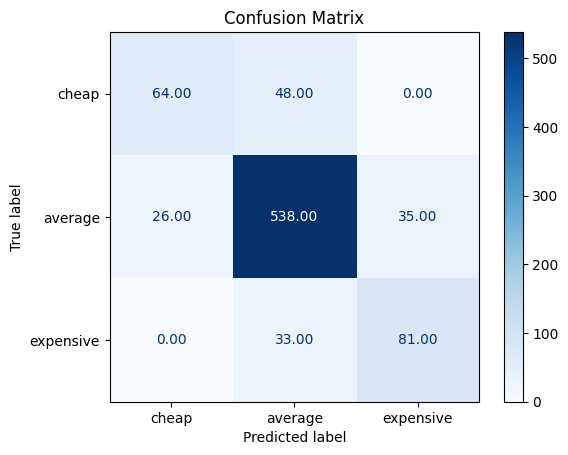


--- Running: Second Model - OHE Data, Standarization, Hidden Size: 1024 ---
Train accuracy: 0.8581 | Test accuracy: 0.8339
Train loss: 0.3128 | Test loss: 0.3372
Class 'cheap': Accuracy: 0.57 (Correct: 64, Incorrect: 48, Total: 112)
Class 'average': Accuracy: 0.90 (Correct: 538, Incorrect: 61, Total: 599)
Class 'expensive': Accuracy: 0.75 (Correct: 86, Incorrect: 28, Total: 114)
Average accuracy: 0.74


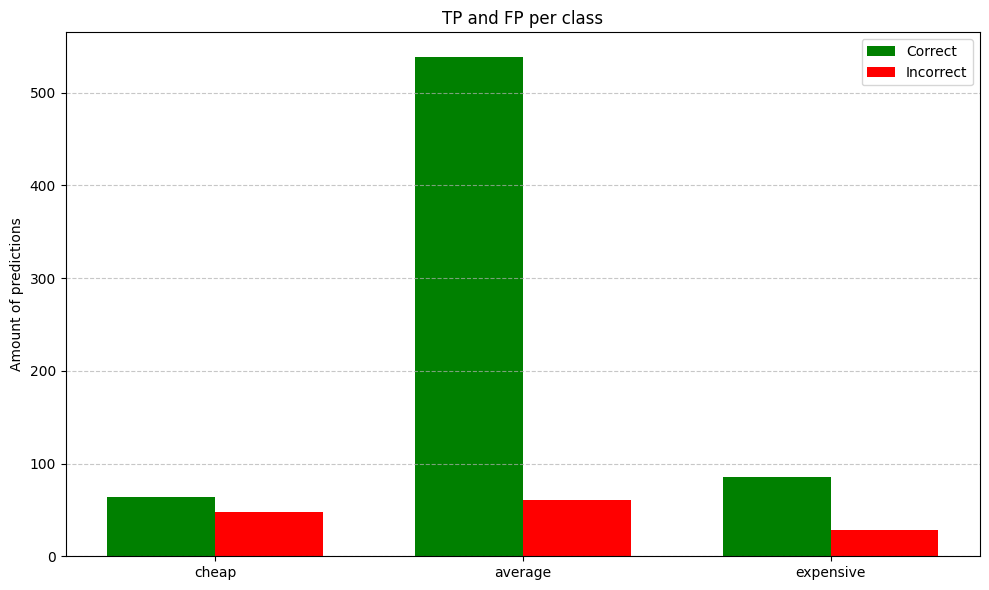

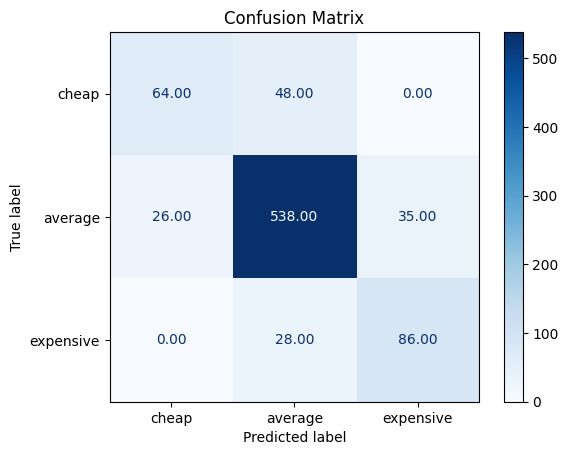

In [60]:
second_model_results = {}

for hidden_size in HIDDEN_SIZES:
    model, optimizer, criterion = build_model_and_optimizer(device, SecondModel, x_train_ohe_tensor_scaled.shape[1], hidden_size, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)

    train_acc, test_acc, train_loss, test_loss, model = run_experiment(
        f"Second Model - OHE Data, Standarization, Hidden Size: {hidden_size}",
        model,
        optimizer,
        criterion,
        x_train_ohe_tensor_scaled,
        y_train_ohe_tensor,
        x_test_ohe_tensor_scaled,
        y_test_ohe_tensor_scaled,
        epochs=EPOCHS,
        verbose=False,
        is_plot=False,
        return_model=True,
        use_minibatch=False
    )

    # plot confusion matrix and class acc
    evaluate_model_per_class_accuracy(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
    plot_confusion_matrix(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

    second_model_results[hidden_size] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_loss': train_loss,
        'test_loss': test_loss
    }


In [61]:
second_model_results_df = format_results_to_df(second_model_results)
second_model_results_df

train_acc test_acc  train_loss  test_loss
64      78.93%   80.36%    0.566509   0.568258
128     82.27%   81.58%    0.461252   0.463434
256     84.57%   82.55%    0.387248   0.397426
512     85.33%   82.79%    0.347712   0.364989
1024    85.81%   83.39%    0.312811   0.337243

## 2.2 Model z 2 ukrytymi warstwami


--- Running: First Model - OHE Data, Standarization, Hidden Size: 64 ---
Train accuracy: 0.7326 | Test accuracy: 0.7255
Train loss: 0.6105 | Test loss: 0.5941
Class 'cheap': Accuracy: 0.00 (Correct: 0, Incorrect: 140, Total: 140)
Class 'average': Accuracy: 1.00 (Correct: 748, Incorrect: 0, Total: 748)
Class 'expensive': Accuracy: 0.00 (Correct: 0, Incorrect: 143, Total: 143)
Average accuracy: 0.33


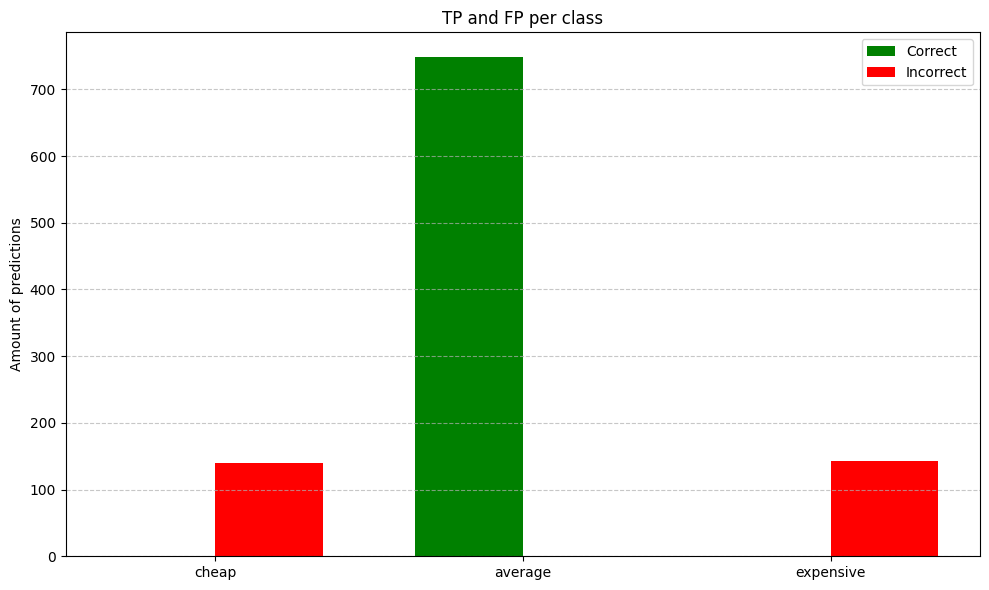

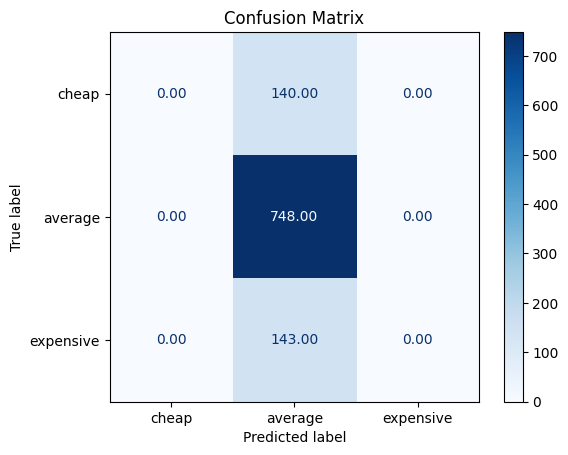


--- Running: First Model - OHE Data, Standarization, Hidden Size: 128 ---
Train accuracy: 0.8274 | Test accuracy: 0.8254
Train loss: 0.4171 | Test loss: 0.4067
Class 'cheap': Accuracy: 0.53 (Correct: 74, Incorrect: 66, Total: 140)
Class 'average': Accuracy: 0.92 (Correct: 686, Incorrect: 62, Total: 748)
Class 'expensive': Accuracy: 0.64 (Correct: 91, Incorrect: 52, Total: 143)
Average accuracy: 0.69


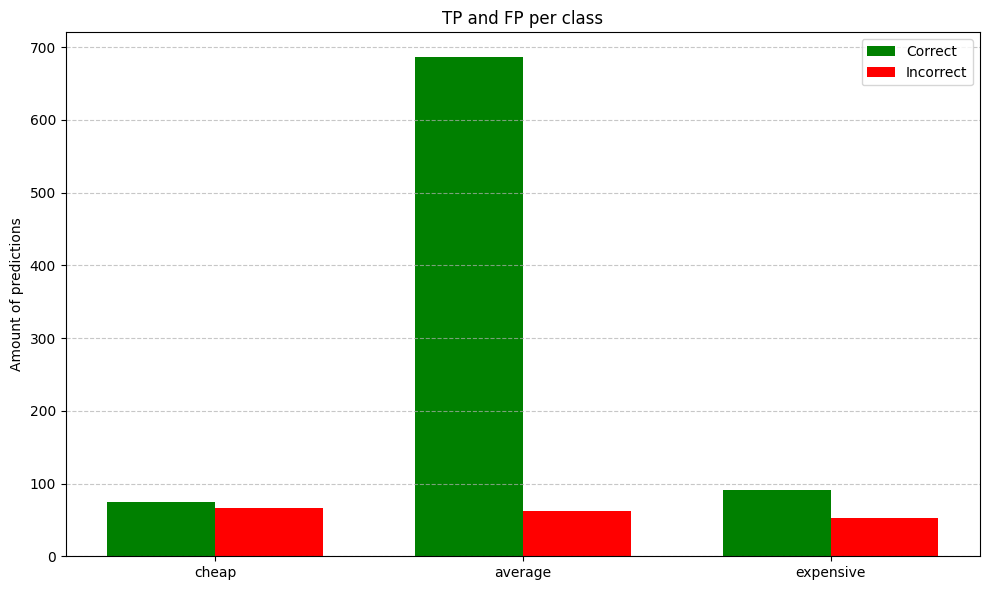

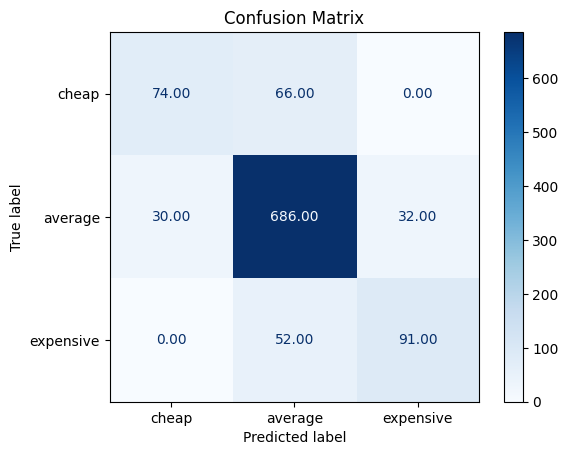


--- Running: First Model - OHE Data, Standarization, Hidden Size: 256 ---
Train accuracy: 0.8477 | Test accuracy: 0.8371
Train loss: 0.3437 | Test loss: 0.3370
Class 'cheap': Accuracy: 0.53 (Correct: 74, Incorrect: 66, Total: 140)
Class 'average': Accuracy: 0.91 (Correct: 677, Incorrect: 71, Total: 748)
Class 'expensive': Accuracy: 0.78 (Correct: 112, Incorrect: 31, Total: 143)
Average accuracy: 0.74


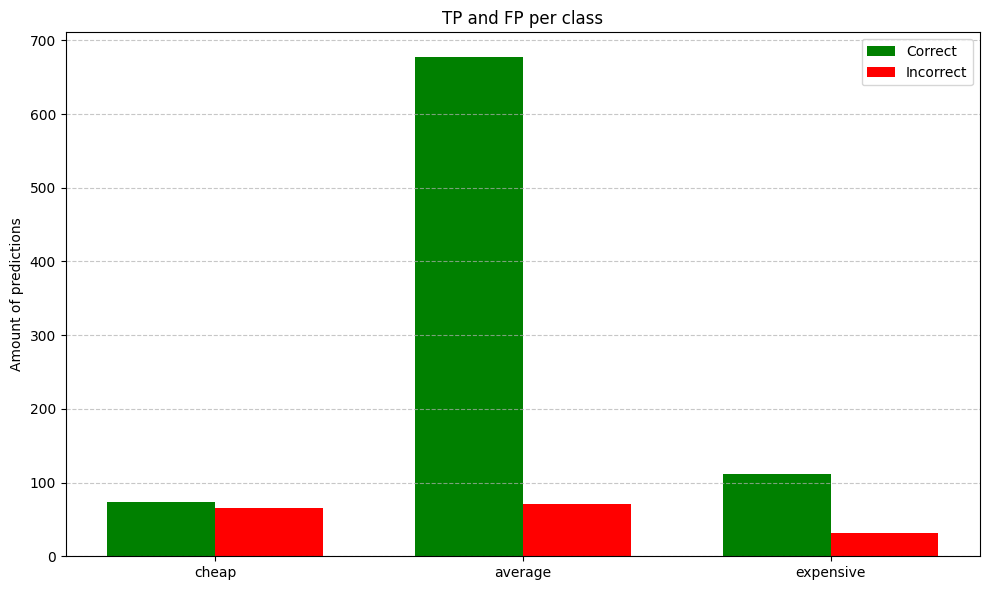

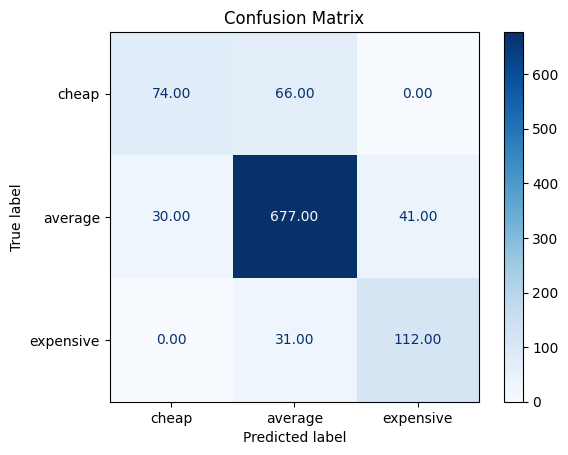


--- Running: First Model - OHE Data, Standarization, Hidden Size: 512 ---
Train accuracy: 0.8565 | Test accuracy: 0.8390
Train loss: 0.3059 | Test loss: 0.3092
Class 'cheap': Accuracy: 0.50 (Correct: 70, Incorrect: 70, Total: 140)
Class 'average': Accuracy: 0.91 (Correct: 682, Incorrect: 66, Total: 748)
Class 'expensive': Accuracy: 0.79 (Correct: 113, Incorrect: 30, Total: 143)
Average accuracy: 0.73


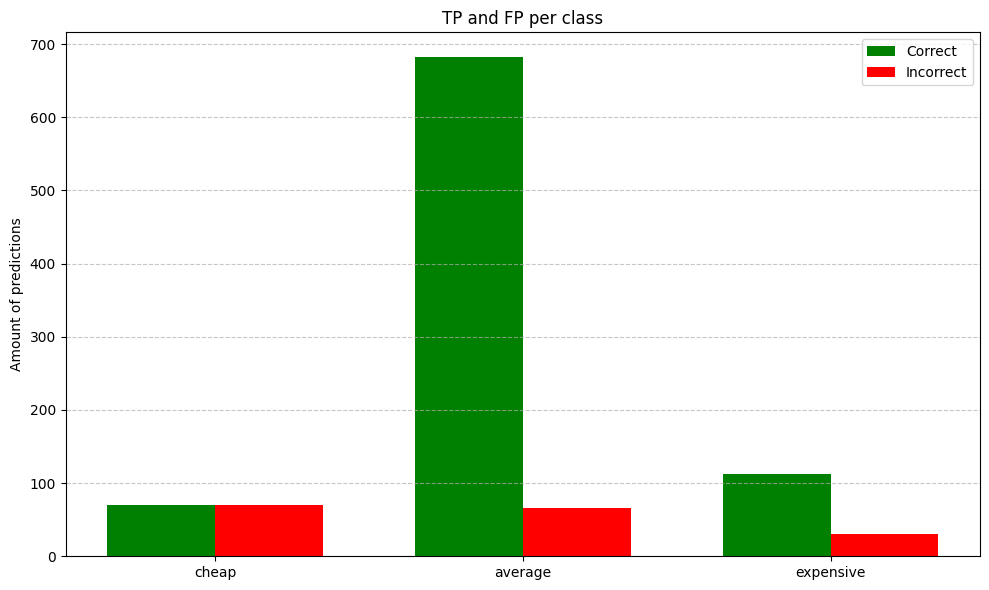

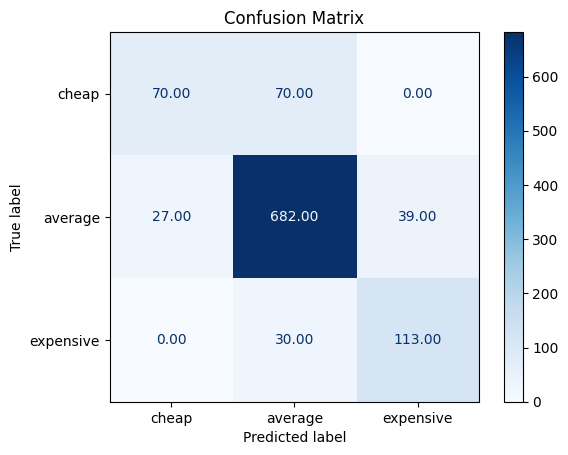


--- Running: First Model - OHE Data, Standarization, Hidden Size: 1024 ---
Train accuracy: 0.8632 | Test accuracy: 0.8545
Train loss: 0.2804 | Test loss: 0.2976
Class 'cheap': Accuracy: 0.66 (Correct: 92, Incorrect: 48, Total: 140)
Class 'average': Accuracy: 0.90 (Correct: 676, Incorrect: 72, Total: 748)
Class 'expensive': Accuracy: 0.79 (Correct: 113, Incorrect: 30, Total: 143)
Average accuracy: 0.78


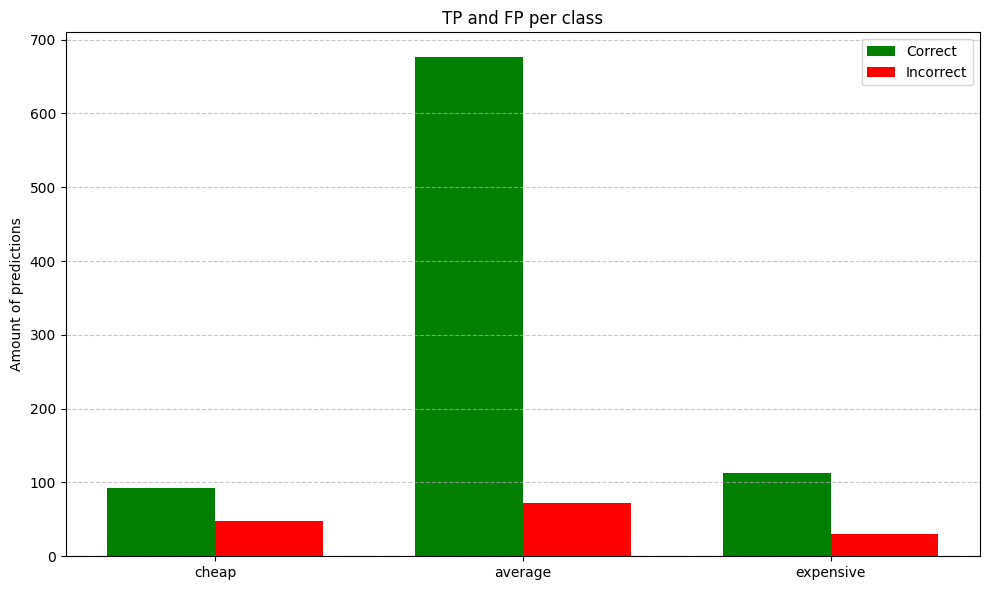

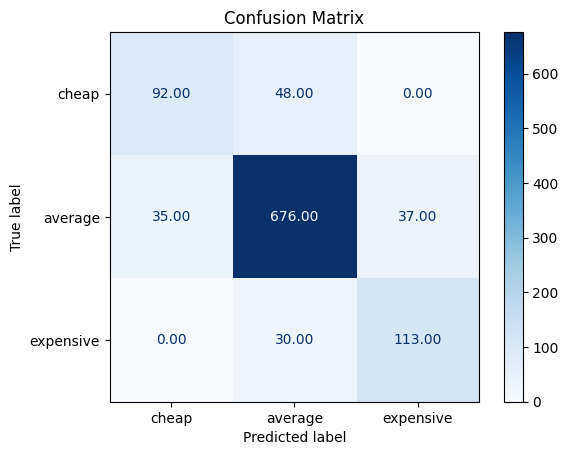

In [88]:
first_model_results = {}

for hidden_size in HIDDEN_SIZES:
    model, optimizer, criterion = build_model_and_optimizer(device, FirstModel, x_train_ohe_tensor_scaled.shape[1], hidden_size, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)

    train_acc, test_acc, train_loss, test_loss, model = run_experiment(
        f"First Model - OHE Data, Standarization, Hidden Size: {hidden_size}",
        model,
        optimizer,
        criterion,
        x_train_ohe_tensor_scaled,
        y_train_ohe_tensor,
        x_test_ohe_tensor_scaled,
        y_test_ohe_tensor_scaled,
        epochs=EPOCHS,
        verbose=False,
        is_plot=False,
        return_model=True,
        use_minibatch=False
    )

    # plot confusion matrix and class acc
    evaluate_model_per_class_accuracy(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
    plot_confusion_matrix(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

    first_model_results[hidden_size] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_loss': train_loss,
        'test_loss': test_loss
    }


In [89]:
first_model_df = format_results_to_df(first_model_results)
first_model_df

train_acc test_acc  train_loss  test_loss
64      73.26%   72.55%    0.610507   0.594058
128     82.74%   82.54%    0.417086   0.406652
256     84.77%   83.71%    0.343710   0.337027
512     85.65%   83.90%    0.305882   0.309211
1024    86.32%   85.45%    0.280355   0.297556

## 2.3 Model z trzema warstwami ukrytymi


--- Running: First Model - OHE Data, Standarization, Hidden Size: 64 ---
Train accuracy: 0.7365 | Test accuracy: 0.7459
Train loss: 0.5958 | Test loss: 0.5626
Class 'cheap': Accuracy: 0.18 (Correct: 25, Incorrect: 115, Total: 140)
Class 'average': Accuracy: 0.99 (Correct: 744, Incorrect: 4, Total: 748)
Class 'expensive': Accuracy: 0.00 (Correct: 0, Incorrect: 143, Total: 143)
Average accuracy: 0.39


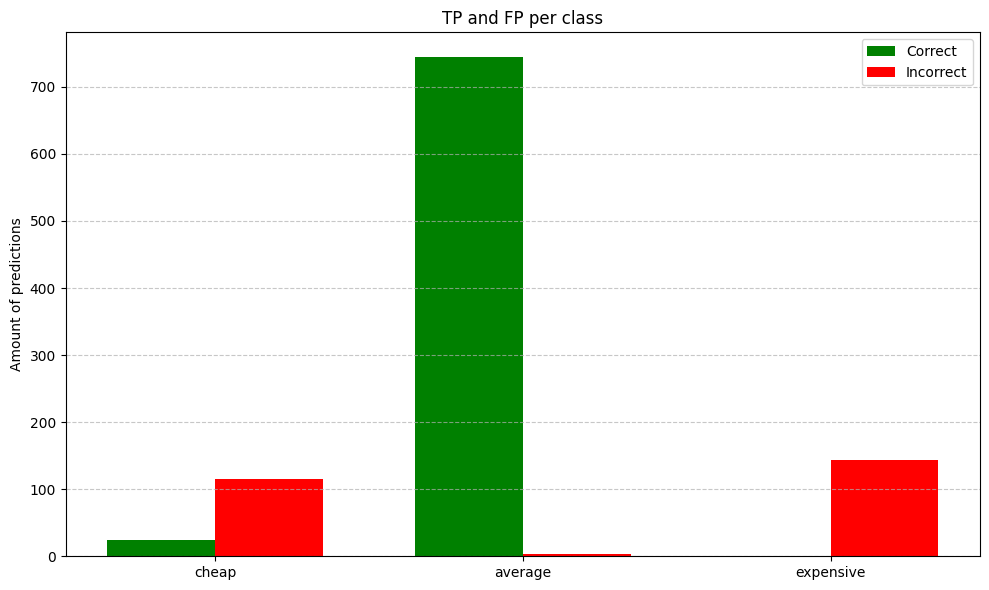

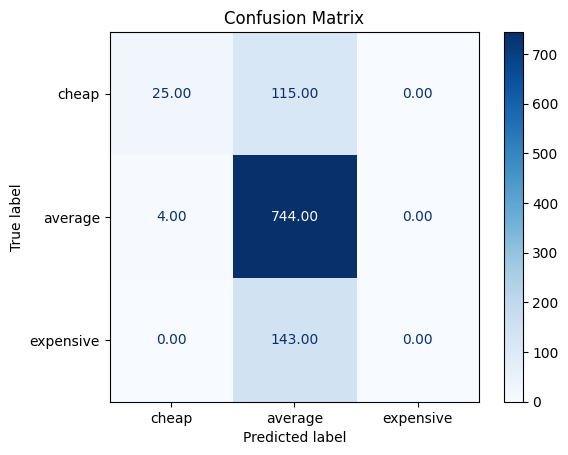


--- Running: First Model - OHE Data, Standarization, Hidden Size: 128 ---
Train accuracy: 0.8364 | Test accuracy: 0.8322
Train loss: 0.3831 | Test loss: 0.3504
Class 'cheap': Accuracy: 0.56 (Correct: 79, Incorrect: 61, Total: 140)
Class 'average': Accuracy: 0.89 (Correct: 665, Incorrect: 83, Total: 748)
Class 'expensive': Accuracy: 0.80 (Correct: 114, Incorrect: 29, Total: 143)
Average accuracy: 0.75


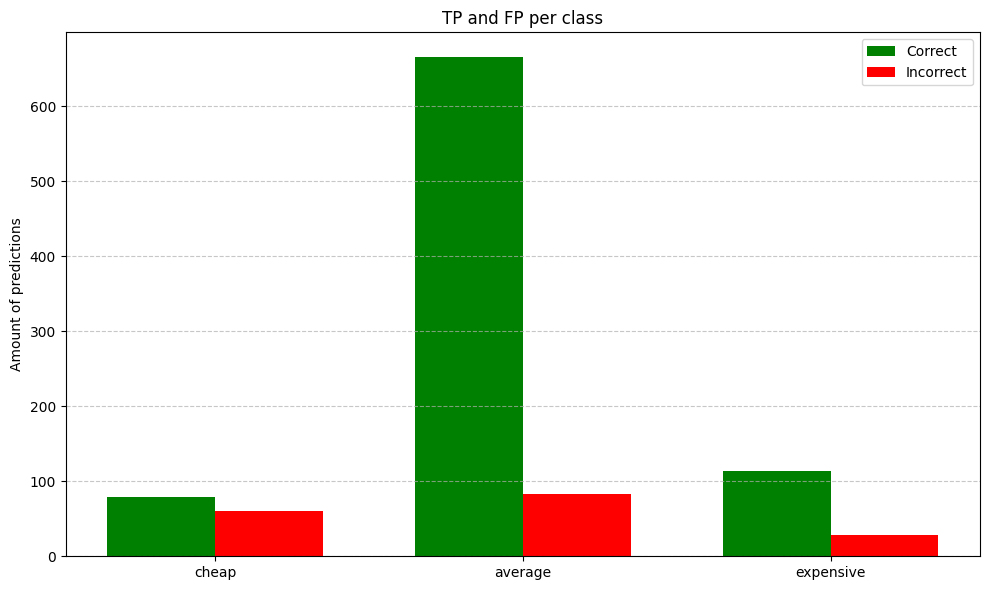

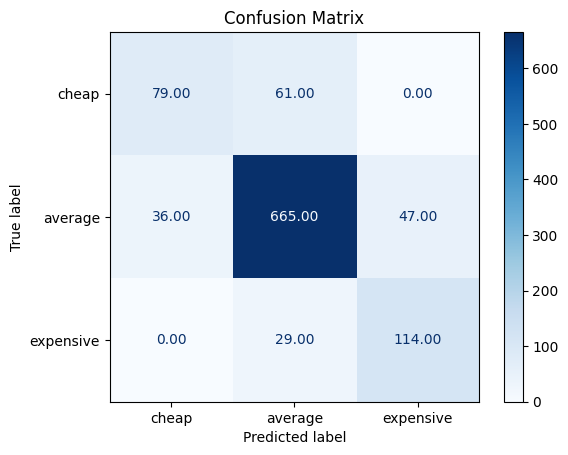


--- Running: First Model - OHE Data, Standarization, Hidden Size: 256 ---
Train accuracy: 0.8497 | Test accuracy: 0.8429
Train loss: 0.3213 | Test loss: 0.3129
Class 'cheap': Accuracy: 0.66 (Correct: 93, Incorrect: 47, Total: 140)
Class 'average': Accuracy: 0.88 (Correct: 660, Incorrect: 88, Total: 748)
Class 'expensive': Accuracy: 0.81 (Correct: 116, Incorrect: 27, Total: 143)
Average accuracy: 0.79


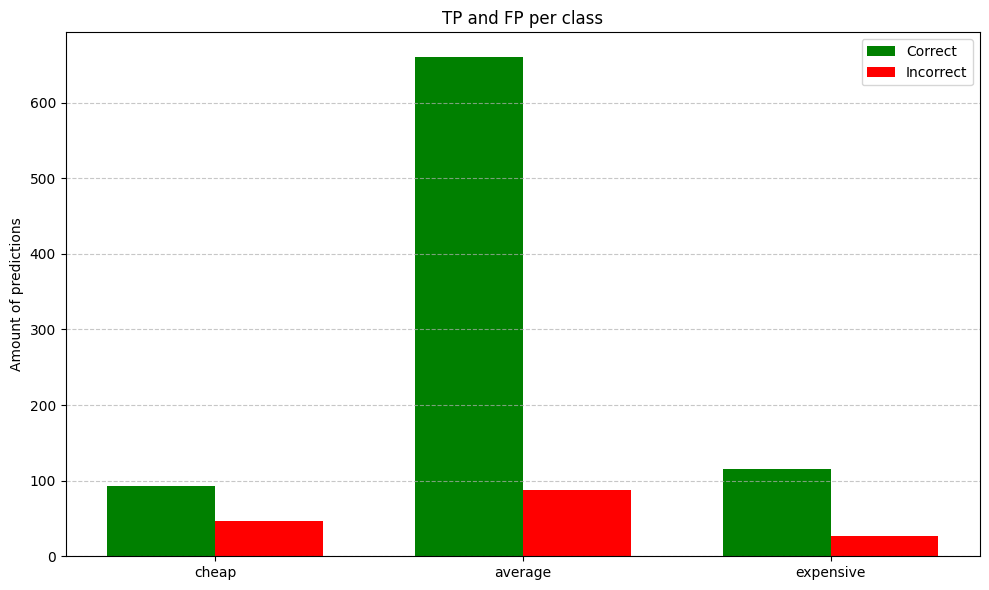

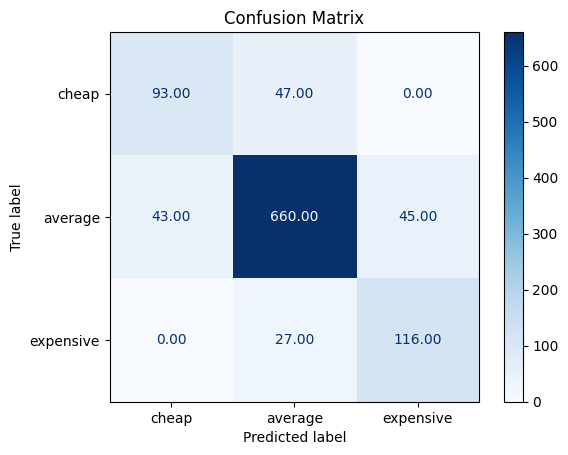


--- Running: First Model - OHE Data, Standarization, Hidden Size: 512 ---
Train accuracy: 0.8584 | Test accuracy: 0.8594
Train loss: 0.2906 | Test loss: 0.3002
Class 'cheap': Accuracy: 0.83 (Correct: 116, Incorrect: 24, Total: 140)
Class 'average': Accuracy: 0.88 (Correct: 655, Incorrect: 93, Total: 748)
Class 'expensive': Accuracy: 0.80 (Correct: 115, Incorrect: 28, Total: 143)
Average accuracy: 0.84


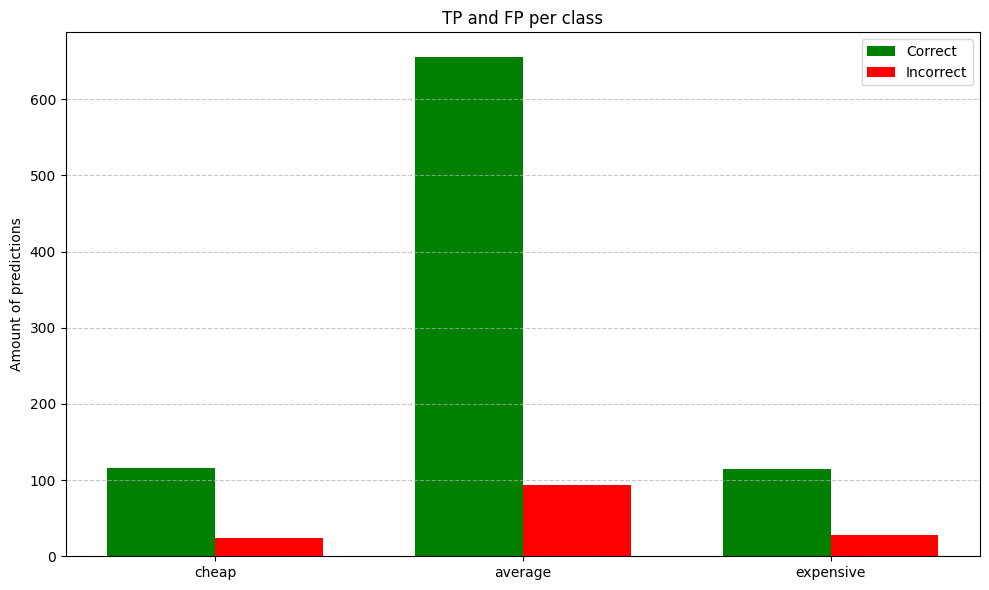

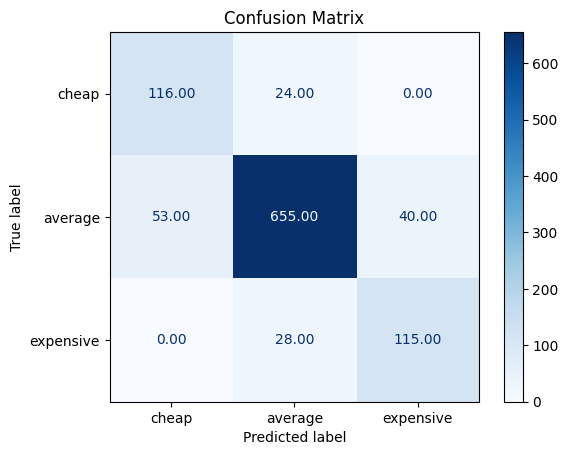


--- Running: First Model - OHE Data, Standarization, Hidden Size: 1024 ---
Train accuracy: 0.8645 | Test accuracy: 0.8535
Train loss: 0.2700 | Test loss: 0.2970
Class 'cheap': Accuracy: 0.78 (Correct: 109, Incorrect: 31, Total: 140)
Class 'average': Accuracy: 0.88 (Correct: 657, Incorrect: 91, Total: 748)
Class 'expensive': Accuracy: 0.80 (Correct: 114, Incorrect: 29, Total: 143)
Average accuracy: 0.82


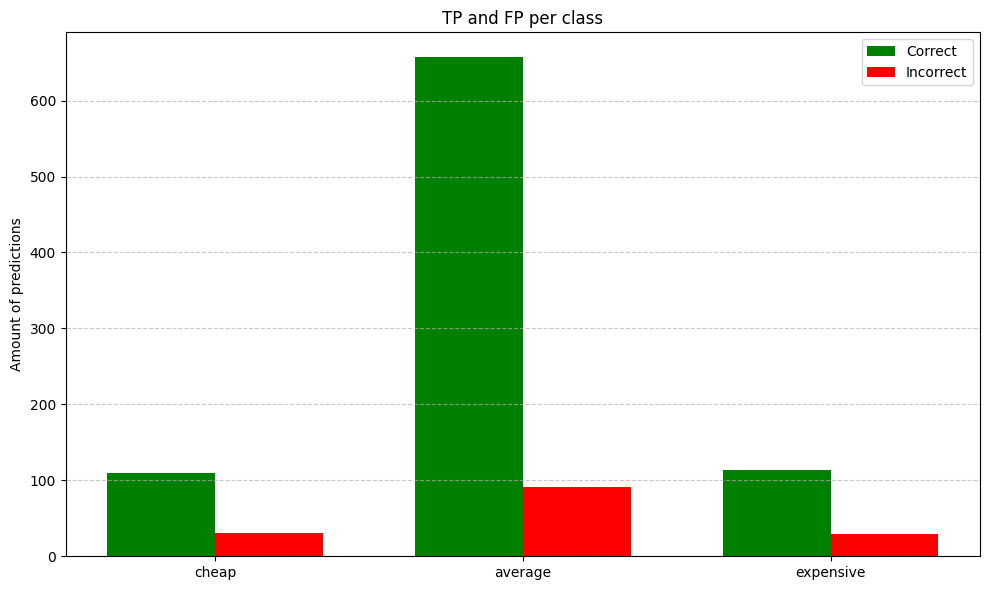

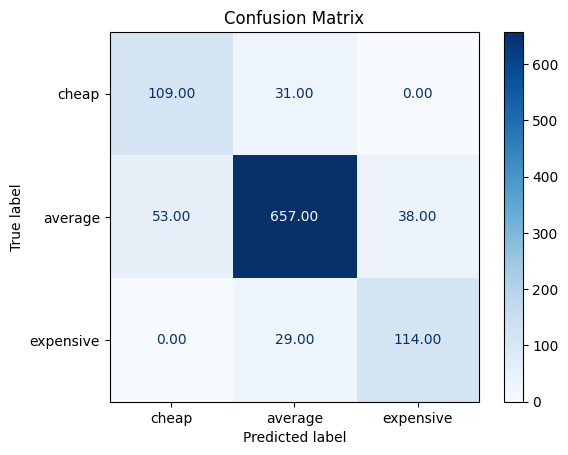

In [86]:
third_model_results = {}

for hidden_size in HIDDEN_SIZES:
    model, optimizer, criterion = build_model_and_optimizer(device, ThirdModel, x_train_ohe_tensor_scaled.shape[1], hidden_size, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)

    train_acc, test_acc, train_loss, test_loss, model = run_experiment(
        f"First Model - OHE Data, Standarization, Hidden Size: {hidden_size}",
        model,
        optimizer,
        criterion,
        x_train_ohe_tensor_scaled,
        y_train_ohe_tensor,
        x_test_ohe_tensor_scaled,
        y_test_ohe_tensor_scaled,
        epochs=EPOCHS,
        verbose=False,
        is_plot=False,
        return_model=True,
        use_minibatch=False
    )

    # plot confusion matrix and class acc
    evaluate_model_per_class_accuracy(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
    plot_confusion_matrix(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

    third_model_results[hidden_size] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_loss': train_loss,
        'test_loss': test_loss
    }


In [87]:
third_model_results_df = format_results_to_df(third_model_results)
third_model_results_df

train_acc test_acc  train_loss  test_loss
64      73.65%   74.59%    0.595770   0.562596
128     83.64%   83.22%    0.383054   0.350435
256     84.97%   84.29%    0.321345   0.312921
512     85.84%   85.94%    0.290585   0.300221
1024    86.45%   85.35%    0.269960   0.297041

### Wnioski
    1. Prostsze modele dają znacznie gorsze rezultaty
    2. Zbyt mała liczba ukrytych neuronó wpływa negatywnie na wyniki
    3. Najlepiej sprawdzają sie złożone modele z dosyć sporą warstwą ukrytych neuronów (3 warstwy i po 1024 neurony)

# 3. Sprawdzenie jak minipakiety wpływają na nasze dane
    1. Zastosujemy kodowanie OHE
    2. Dane będą przeskalowane
    3. Przetestujemy różnerozmiary BachSize'y
    4. Sprawdzimy dla modelu z 2ma i 3ma warstwami ukrytymi
    

## 3.1 Model z 2 warstwami ukrytymi


--- Running: BatchLayerWith2Layers - OHE Data, Standarization, Batch Size: 32 ---


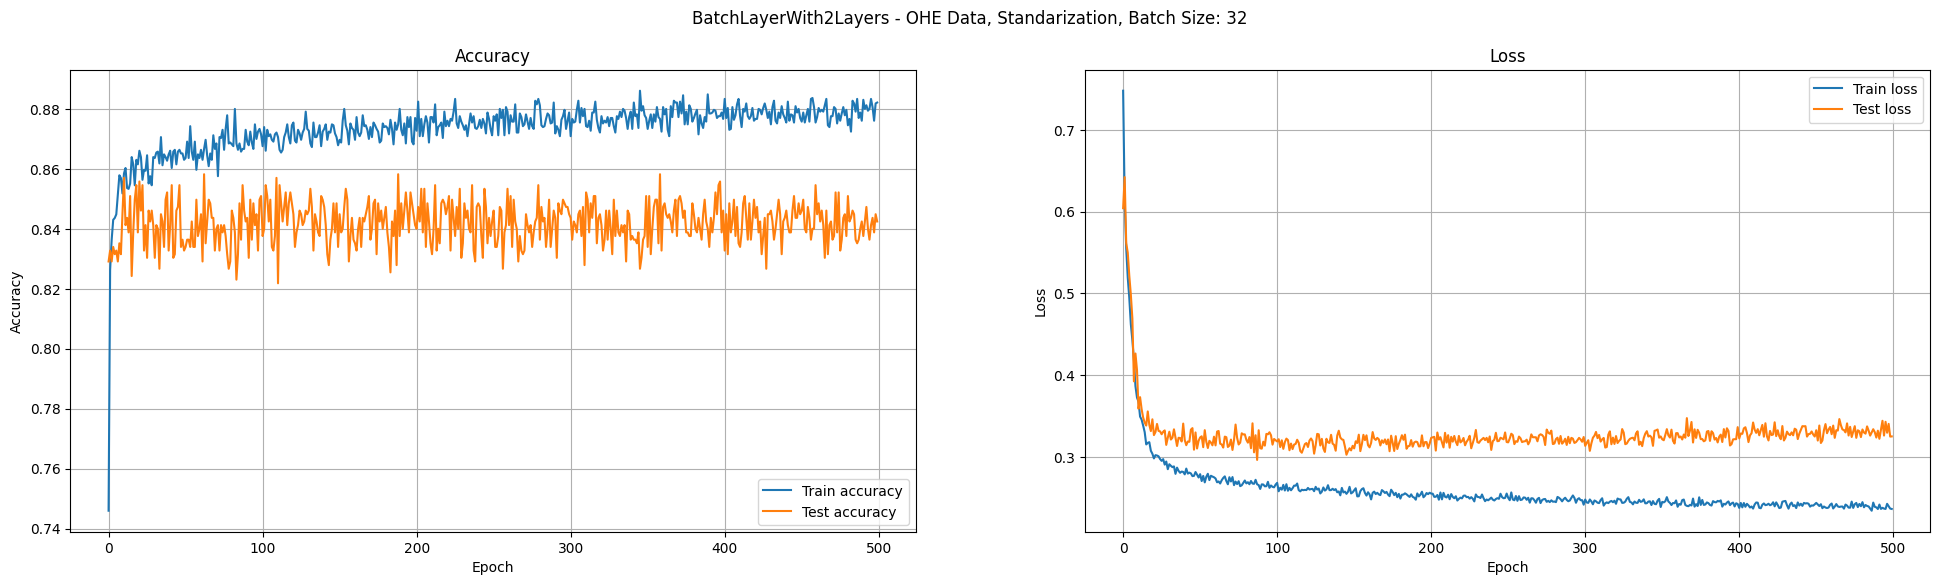

Train accuracy: 0.8821 | Test accuracy: 0.8424
Train loss: 0.2366 | Test loss: 0.3252
Class 'cheap': Accuracy: 0.68 (Correct: 76, Incorrect: 36, Total: 112)
Class 'average': Accuracy: 0.89 (Correct: 533, Incorrect: 66, Total: 599)
Class 'expensive': Accuracy: 0.75 (Correct: 86, Incorrect: 28, Total: 114)
Average accuracy: 0.77


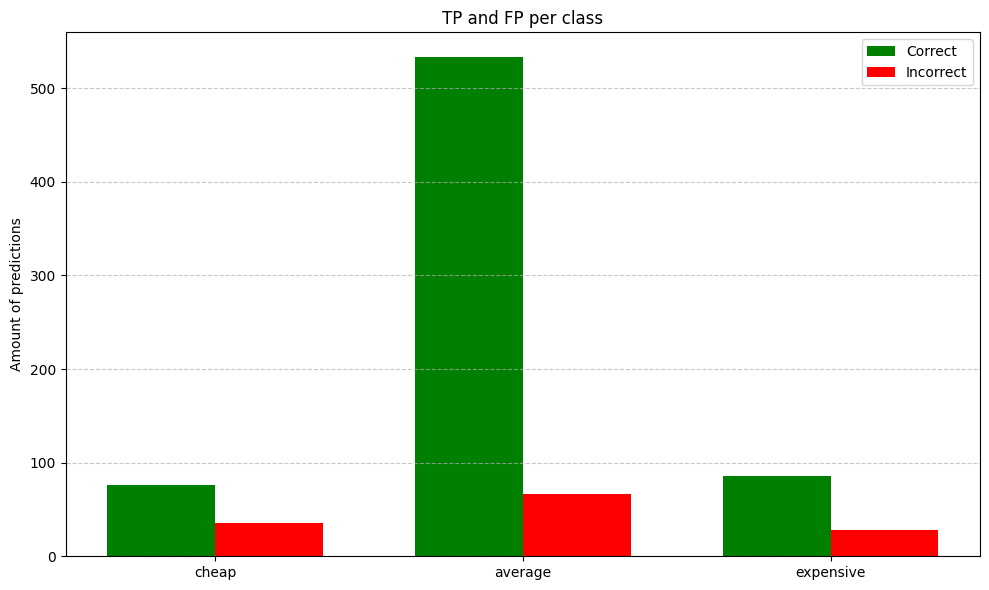

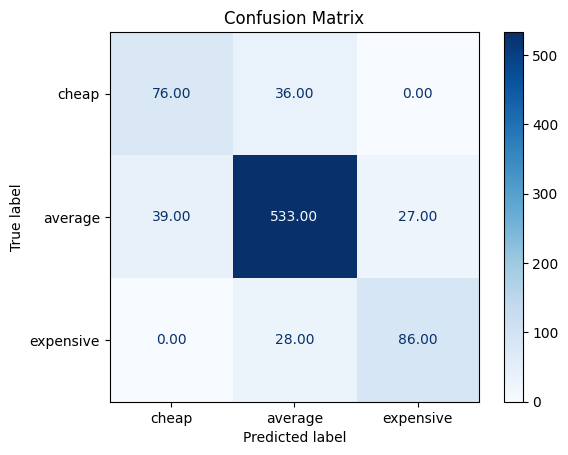


--- Running: BatchLayerWith2Layers - OHE Data, Standarization, Batch Size: 64 ---


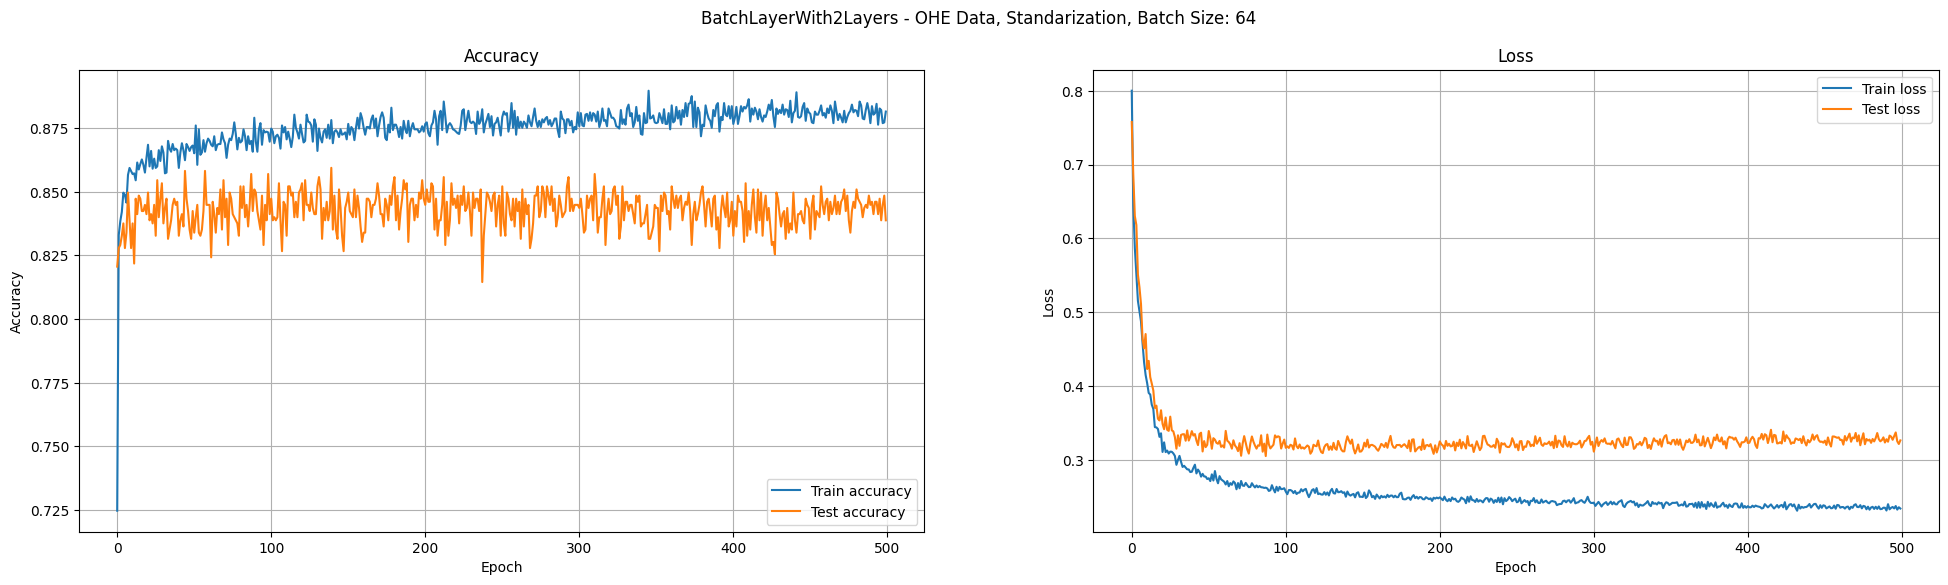

Train accuracy: 0.8815 | Test accuracy: 0.8388
Train loss: 0.2342 | Test loss: 0.3265
Class 'cheap': Accuracy: 0.77 (Correct: 86, Incorrect: 26, Total: 112)
Class 'average': Accuracy: 0.87 (Correct: 520, Incorrect: 79, Total: 599)
Class 'expensive': Accuracy: 0.75 (Correct: 86, Incorrect: 28, Total: 114)
Average accuracy: 0.80


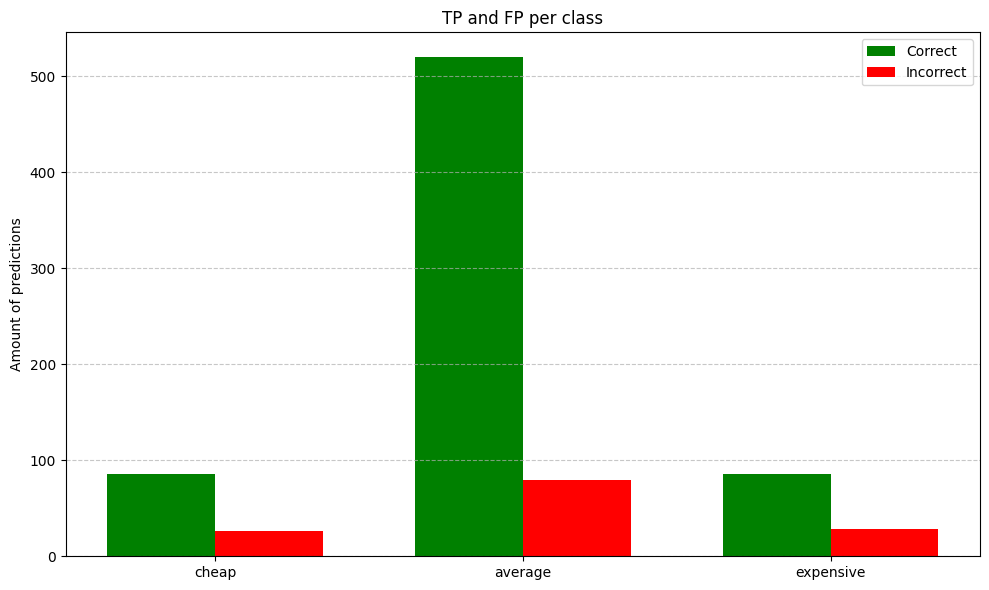

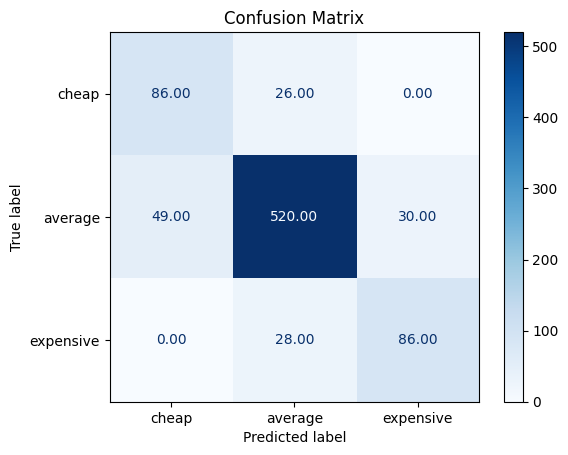


--- Running: BatchLayerWith2Layers - OHE Data, Standarization, Batch Size: 128 ---


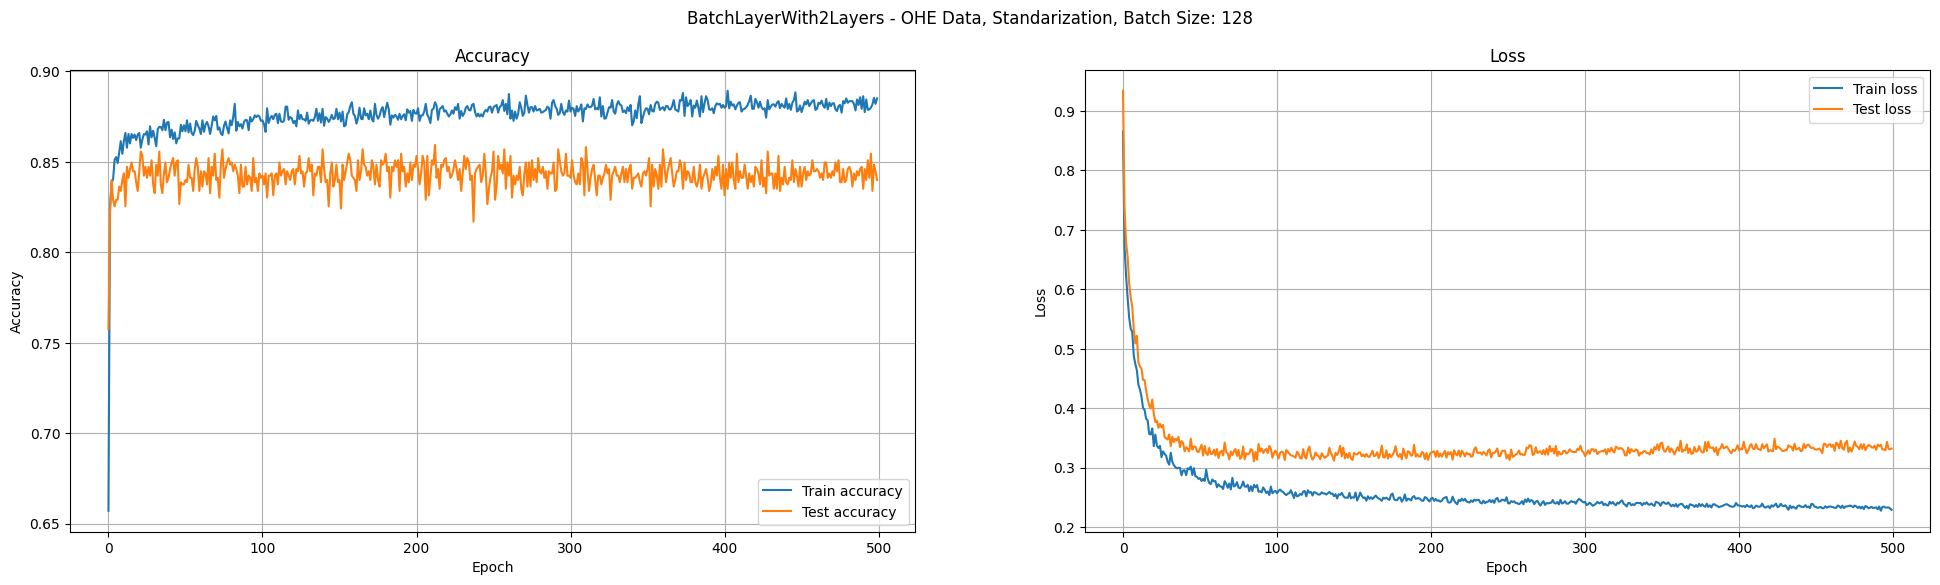

Train accuracy: 0.8851 | Test accuracy: 0.8400
Train loss: 0.2290 | Test loss: 0.3321
Class 'cheap': Accuracy: 0.79 (Correct: 88, Incorrect: 24, Total: 112)
Class 'average': Accuracy: 0.87 (Correct: 520, Incorrect: 79, Total: 599)
Class 'expensive': Accuracy: 0.75 (Correct: 85, Incorrect: 29, Total: 114)
Average accuracy: 0.80


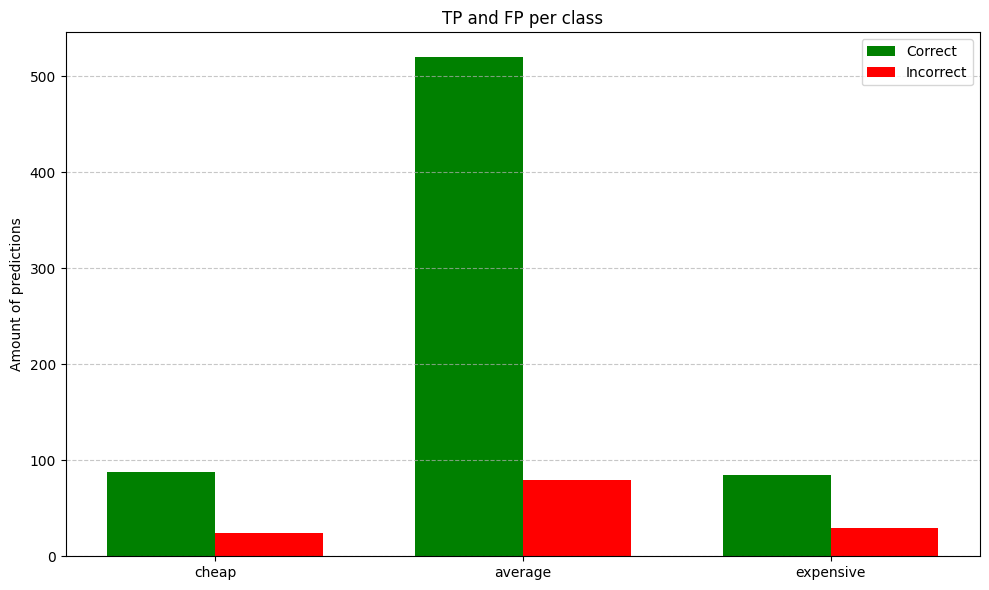

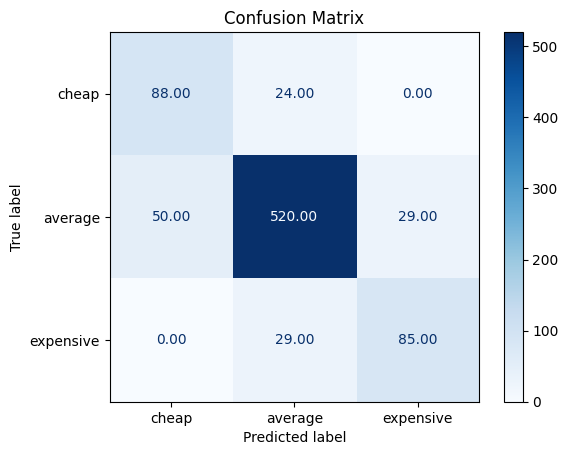


--- Running: BatchLayerWith2Layers - OHE Data, Standarization, Batch Size: 256 ---


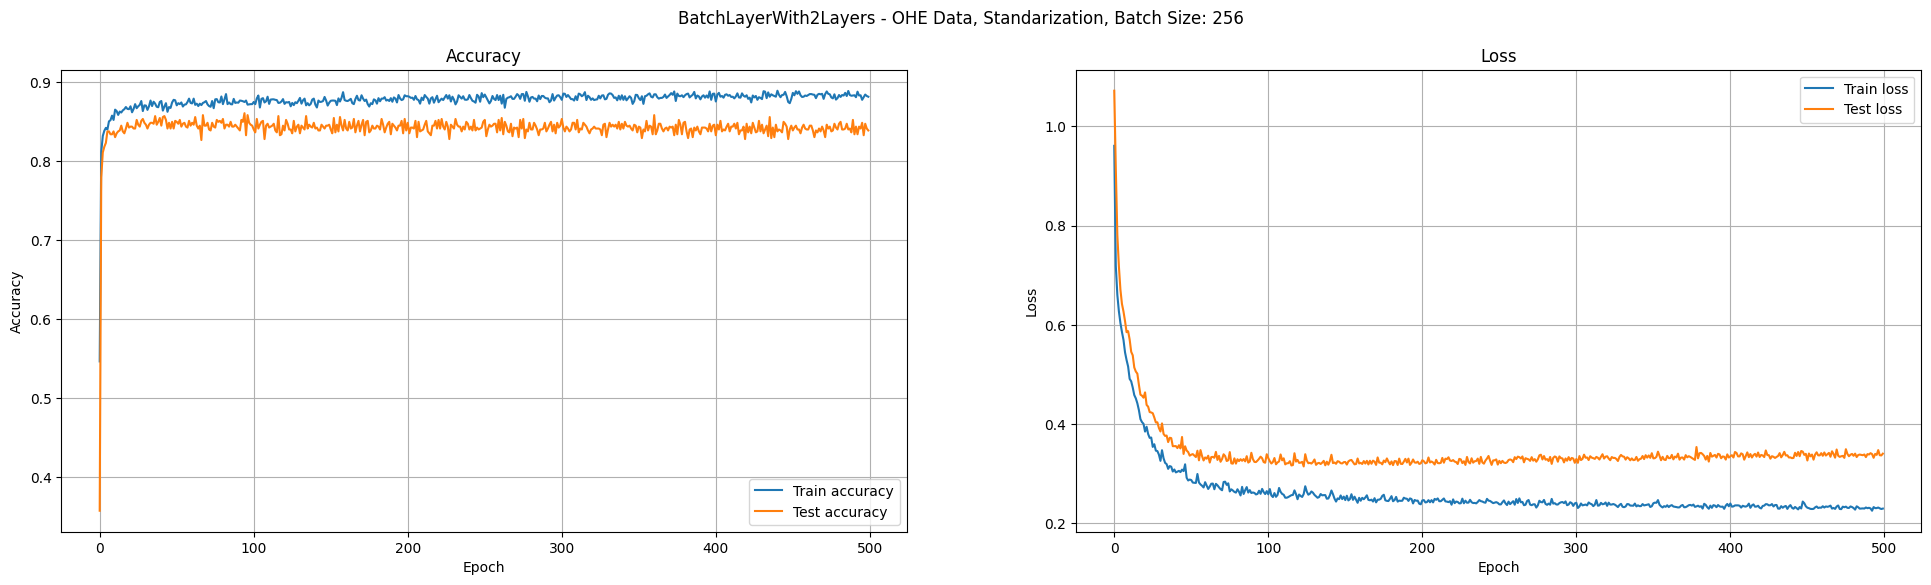

Train accuracy: 0.8815 | Test accuracy: 0.8388
Train loss: 0.2293 | Test loss: 0.3400
Class 'cheap': Accuracy: 0.84 (Correct: 94, Incorrect: 18, Total: 112)
Class 'average': Accuracy: 0.86 (Correct: 515, Incorrect: 84, Total: 599)
Class 'expensive': Accuracy: 0.73 (Correct: 83, Incorrect: 31, Total: 114)
Average accuracy: 0.81


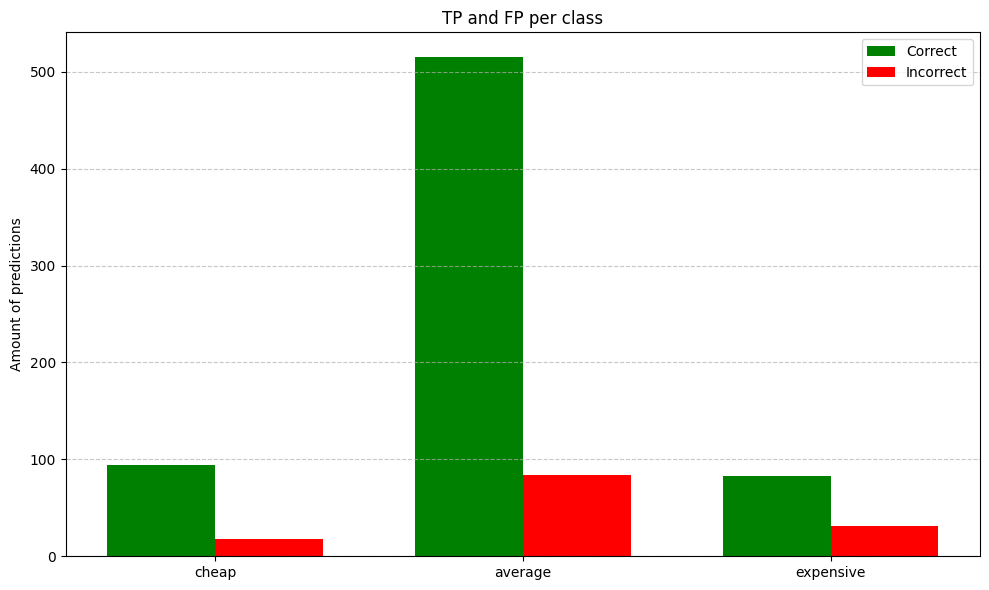

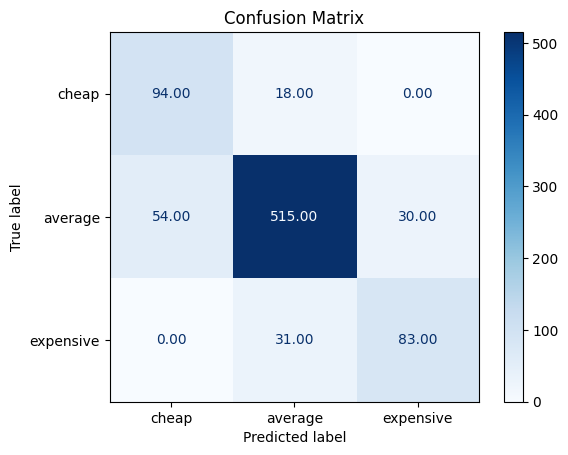

In [66]:
LR = 0.0001
HIDDEN_SIZE = 512
OUTPUT_SIZE = 3
DROPOUT = 0.2
EPOCHS = 500
WEIGHT_DECAY = 0
BATCH_SIZES = [32, 64, 128, 256]

batch_2_layers_results = {}

for batch_size in BATCH_SIZES:
    model, optimizer, criterion = build_model_and_optimizer(device, BatchLayerWith2Layers, x_train_ohe_tensor_scaled.shape[1], HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)
    train_loader, test_loader = create_dataloader(x_train_ohe_tensor_scaled, y_train_ohe_tensor, x_test_ohe_tensor_scaled, y_test_ohe_tensor,batch_size)

    train_acc, test_acc, train_loss, test_loss, model = run_experiment(
        f"BatchLayerWith2Layers - OHE Data, Standarization, Batch Size: {batch_size}",
        model,
        optimizer,
        criterion,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        verbose=False,
        is_plot=True,
        return_model=True,
        use_minibatch=True,
    )

    # plot confusion matrix and class acc
    evaluate_model_per_class_accuracy(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
    plot_confusion_matrix(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

    batch_2_layers_results[batch_size] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_loss': train_loss,
        'test_loss': test_loss
    }

In [67]:
batch_2_layers_results_df = format_results_to_df(batch_2_layers_results)
batch_2_layers_results_df

train_acc test_acc  train_loss  test_loss
32     88.21%   84.24%    0.236550   0.325201
64     88.15%   83.88%    0.234224   0.326480
128    88.51%   84.00%    0.228957   0.332071
256    88.15%   83.88%    0.229270   0.340011


--- Running: BatchLayerWith3Layers - OHE Data, Standarization, Batch Size: 32 ---


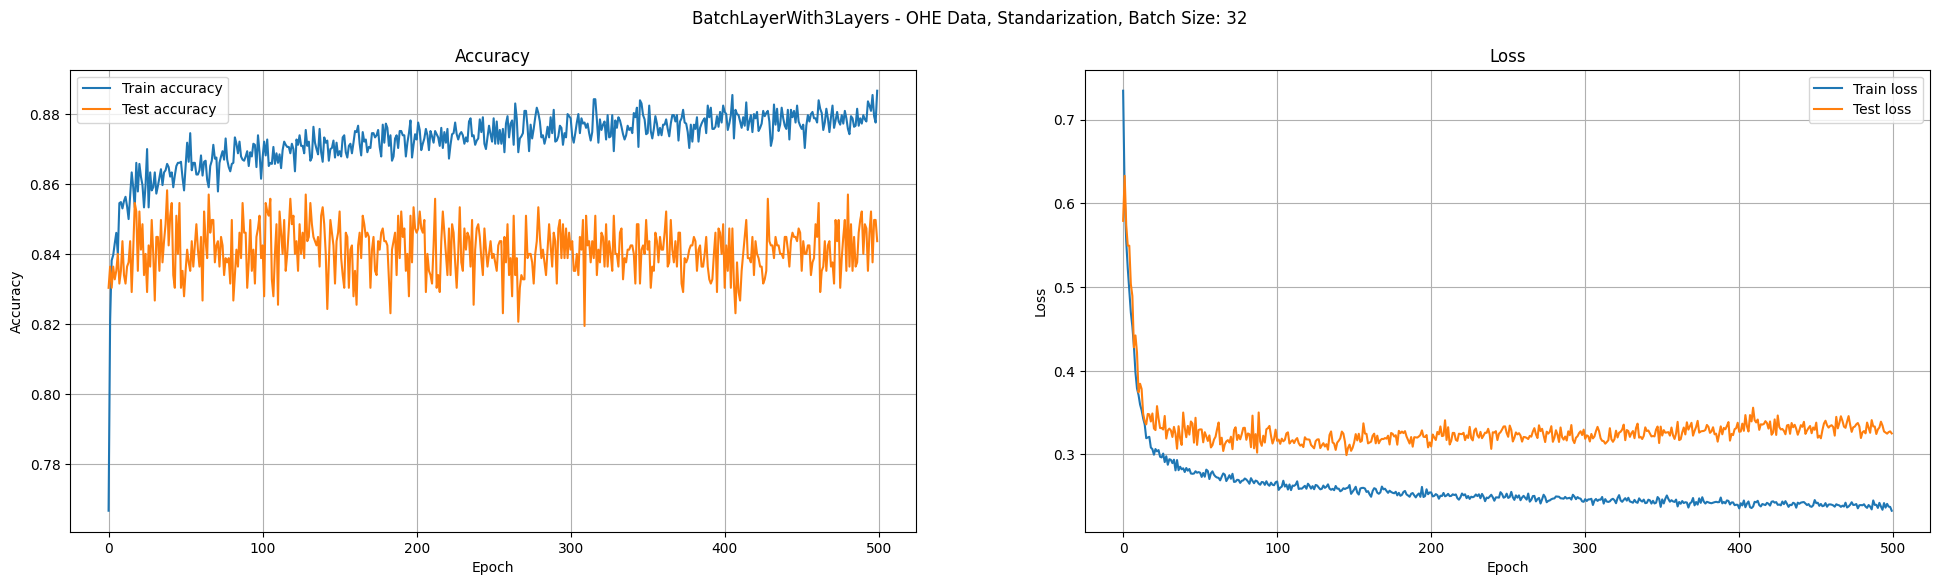

Train accuracy: 0.8866 | Test accuracy: 0.8436
Train loss: 0.2329 | Test loss: 0.3252
Class 'cheap': Accuracy: 0.75 (Correct: 84, Incorrect: 28, Total: 112)
Class 'average': Accuracy: 0.89 (Correct: 531, Incorrect: 68, Total: 599)
Class 'expensive': Accuracy: 0.71 (Correct: 81, Incorrect: 33, Total: 114)
Average accuracy: 0.78


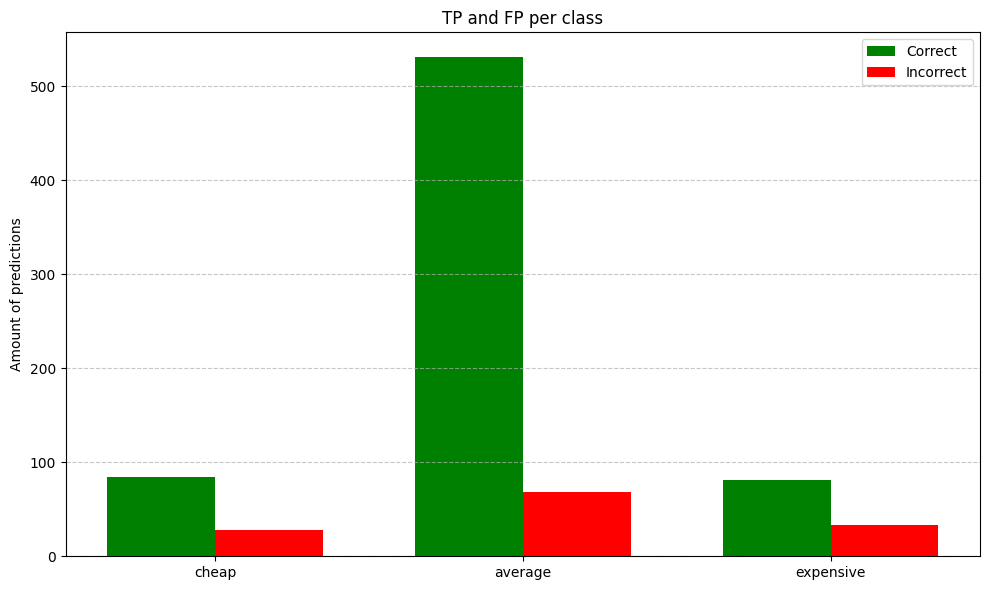

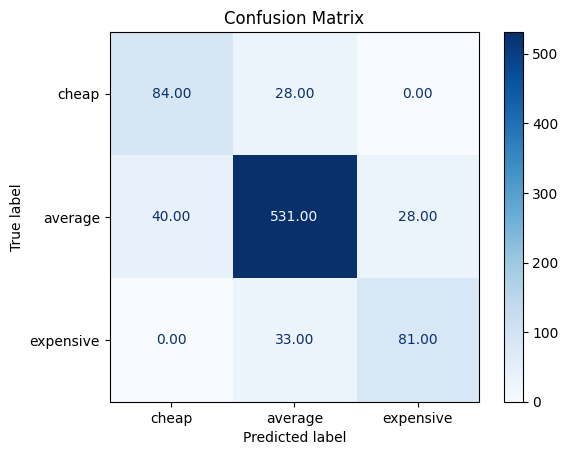


--- Running: BatchLayerWith3Layers - OHE Data, Standarization, Batch Size: 64 ---


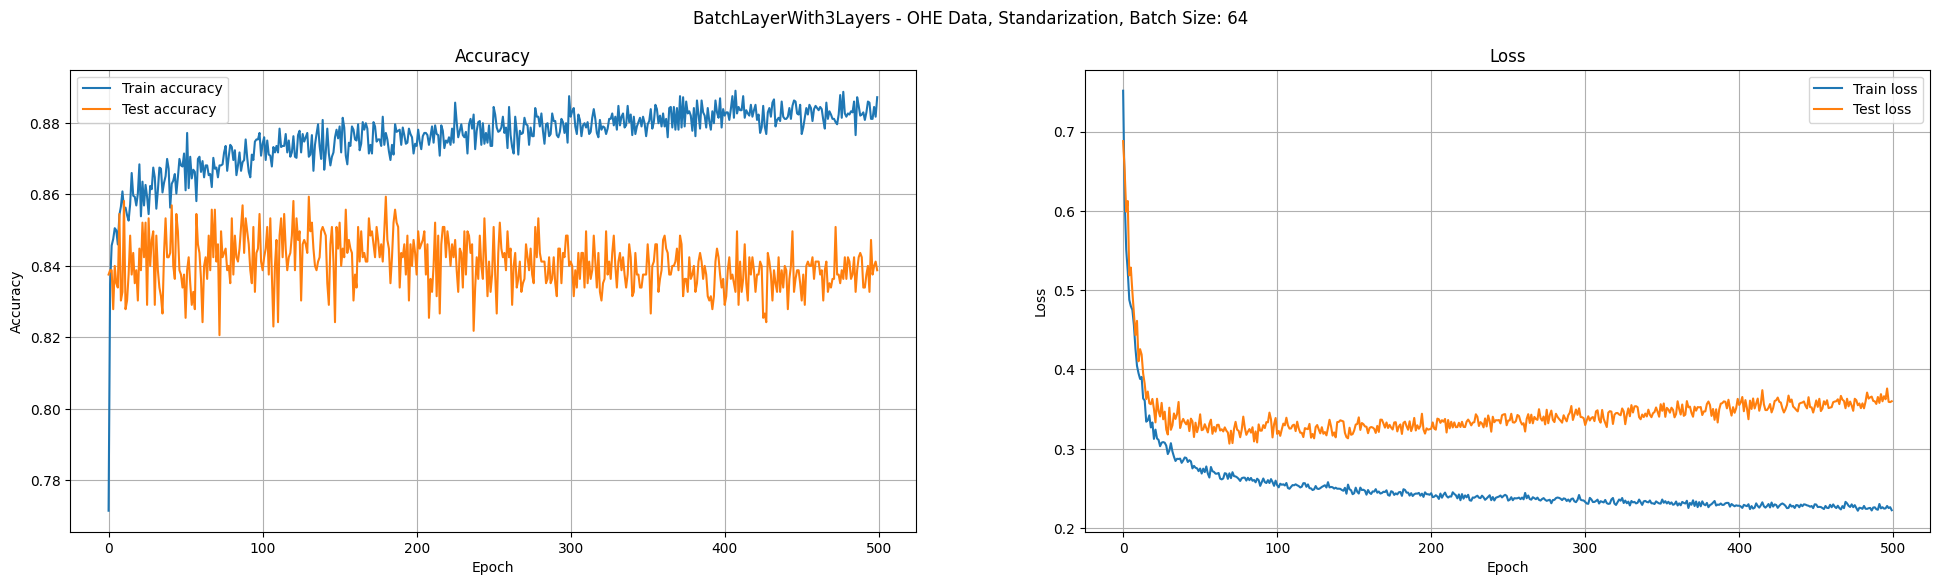

Train accuracy: 0.8872 | Test accuracy: 0.8388
Train loss: 0.2225 | Test loss: 0.3599
Class 'cheap': Accuracy: 0.78 (Correct: 87, Incorrect: 25, Total: 112)
Class 'average': Accuracy: 0.87 (Correct: 524, Incorrect: 75, Total: 599)
Class 'expensive': Accuracy: 0.71 (Correct: 81, Incorrect: 33, Total: 114)
Average accuracy: 0.79


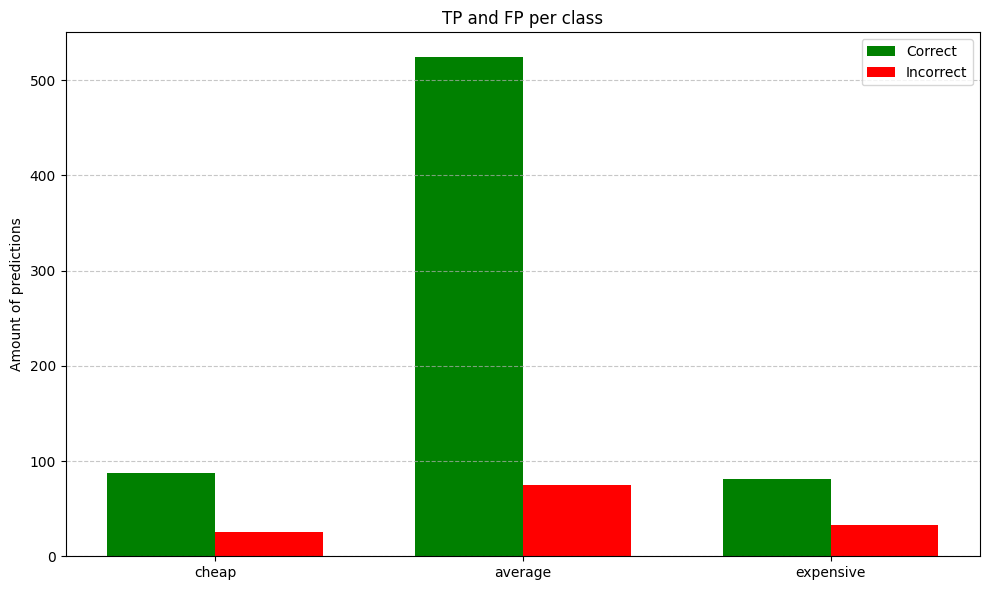

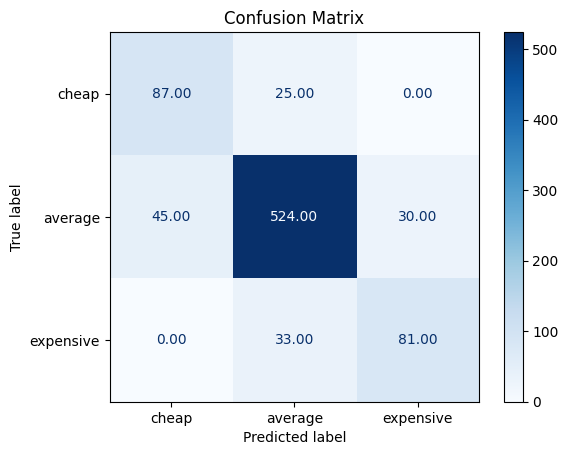


--- Running: BatchLayerWith3Layers - OHE Data, Standarization, Batch Size: 128 ---


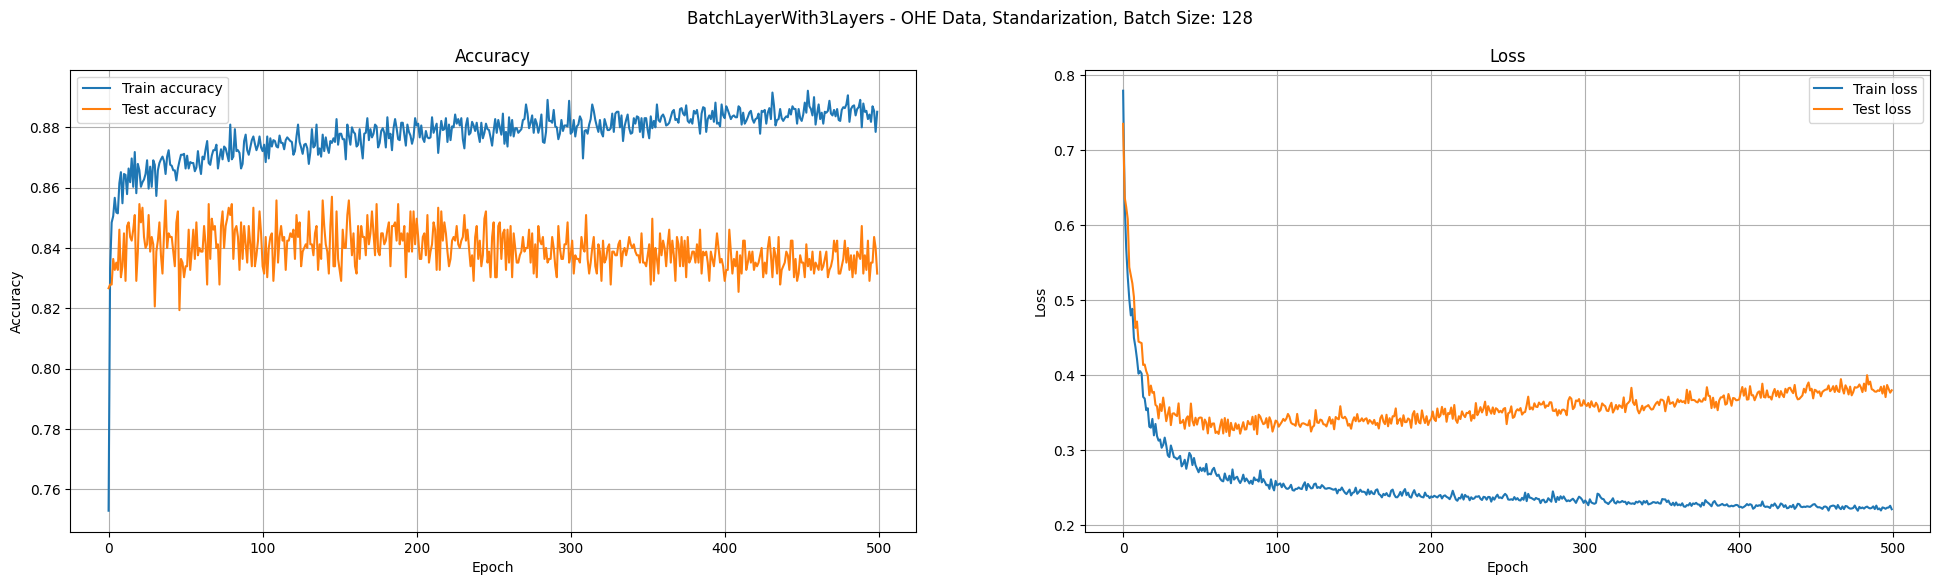

Train accuracy: 0.8851 | Test accuracy: 0.8315
Train loss: 0.2212 | Test loss: 0.3797
Class 'cheap': Accuracy: 0.80 (Correct: 90, Incorrect: 22, Total: 112)
Class 'average': Accuracy: 0.86 (Correct: 516, Incorrect: 83, Total: 599)
Class 'expensive': Accuracy: 0.70 (Correct: 80, Incorrect: 34, Total: 114)
Average accuracy: 0.79


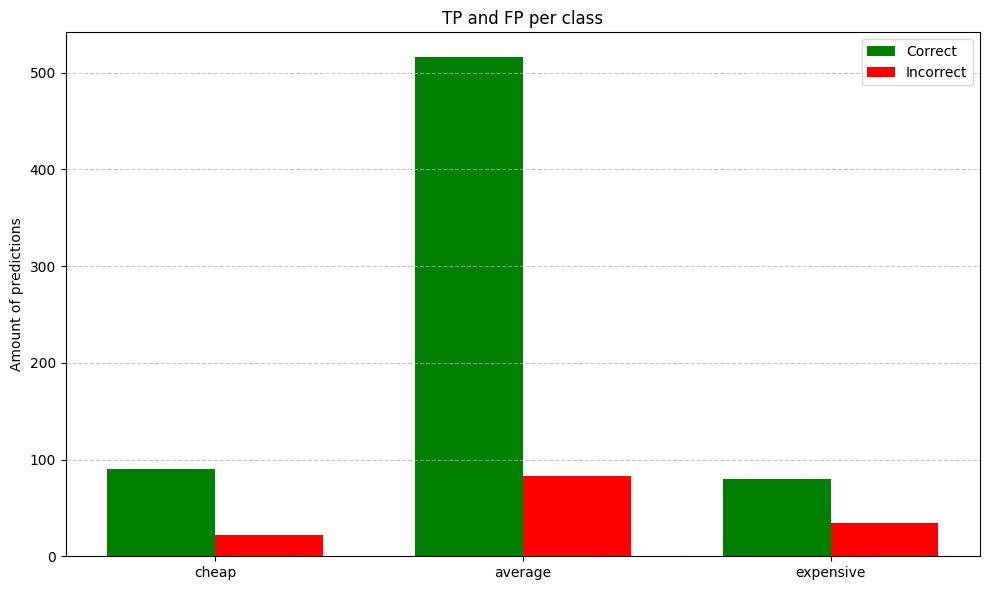

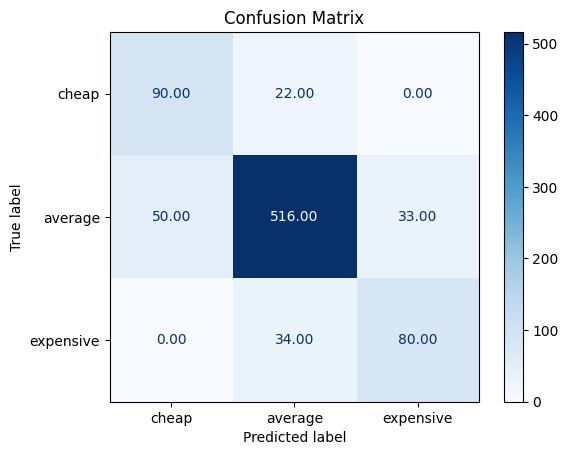


--- Running: BatchLayerWith3Layers - OHE Data, Standarization, Batch Size: 256 ---


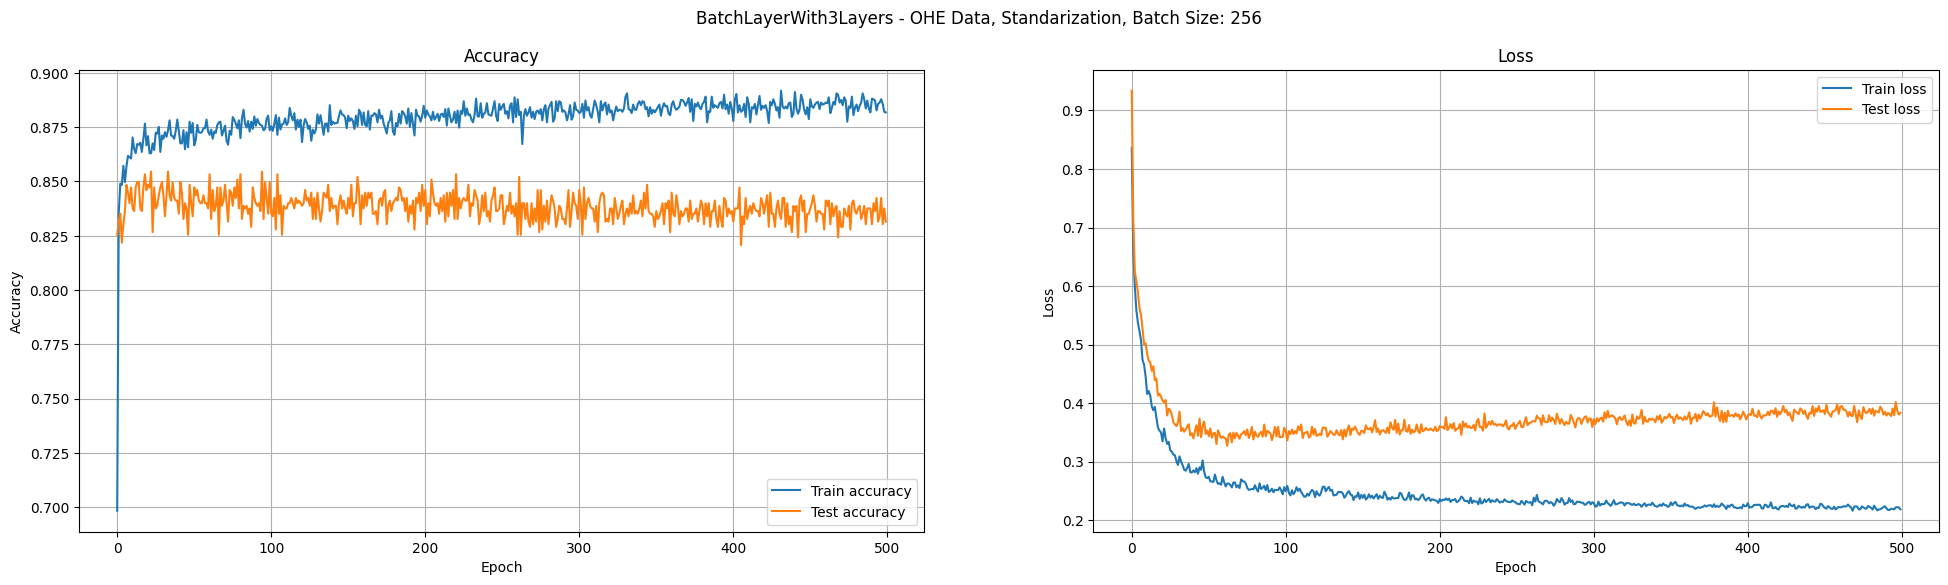

Train accuracy: 0.8818 | Test accuracy: 0.8315
Train loss: 0.2187 | Test loss: 0.3835
Class 'cheap': Accuracy: 0.81 (Correct: 91, Incorrect: 21, Total: 112)
Class 'average': Accuracy: 0.86 (Correct: 516, Incorrect: 83, Total: 599)
Class 'expensive': Accuracy: 0.69 (Correct: 79, Incorrect: 35, Total: 114)
Average accuracy: 0.79


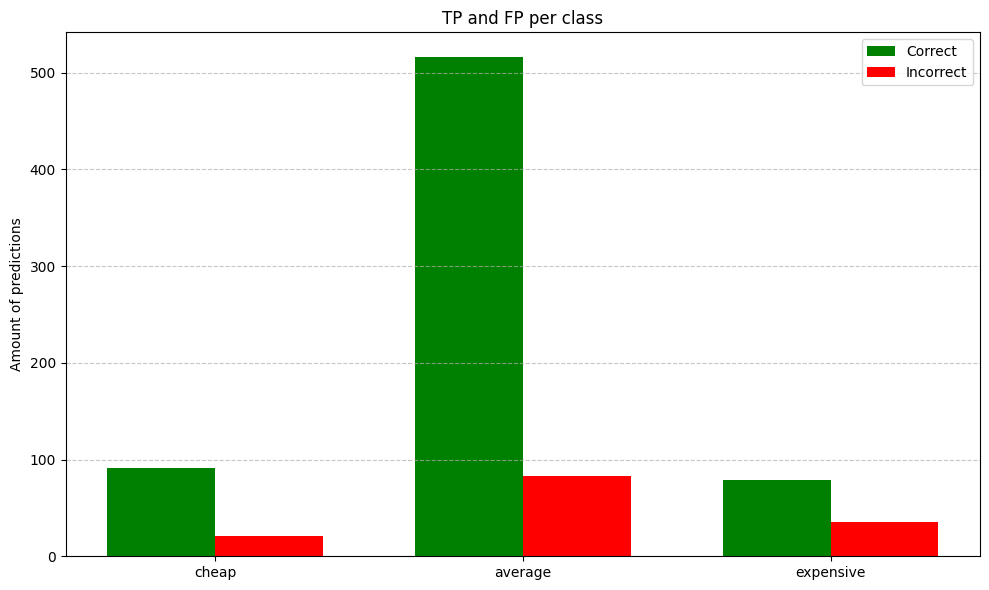

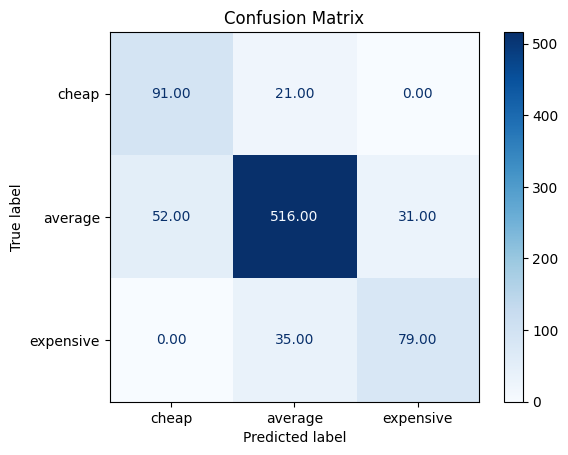

In [13]:
LR = 0.0001
HIDDEN_SIZE = 512
OUTPUT_SIZE = 3
DROPOUT = 0.2
EPOCHS = 500
WEIGHT_DECAY = 0
BATCH_SIZES = [32, 64, 128, 256]

batch_3_layers_results = {}

for batch_size in BATCH_SIZES:
    model, optimizer, criterion = build_model_and_optimizer(device, BatchLayerWith3Layers, x_train_ohe_tensor_scaled.shape[1], HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)
    train_loader, test_loader = create_dataloader(x_train_ohe_tensor_scaled, y_train_ohe_tensor, x_test_ohe_tensor_scaled, y_test_ohe_tensor, batch_size)

    train_acc, test_acc, train_loss, test_loss, model = run_experiment(
        f"BatchLayerWith3Layers - OHE Data, Standarization, Batch Size: {batch_size}",
        model,
        optimizer,
        criterion,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        verbose=False,
        is_plot=True,
        return_model=True,
        use_minibatch=True,
    )

    # plot confusion matrix and class acc
    evaluate_model_per_class_accuracy(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
    plot_confusion_matrix(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

    batch_3_layers_results[batch_size] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_loss': train_loss,
        'test_loss': test_loss
    }

In [14]:
batch_3_layers_results_df = format_results_to_df(batch_3_layers_results)
batch_3_layers_results_df

train_acc test_acc  train_loss  test_loss
32     88.66%   84.36%    0.232857   0.325179
64     88.72%   83.88%    0.222527   0.359920
128    88.51%   83.15%    0.221189   0.379671
256    88.18%   83.15%    0.218678   0.383462

### Wnioski
    1. Użycie minipakietów nie polepsza otrzymywanych wyników acc. Wszystkie w okolicach 79%
    2. Co więcej można zauważyć, że na wykresach straty widzimy, że po pewnym czasie mimo ciągłego spadku na zbiorze treningowym, to strata na testowym rośnie, co może świadczyć o przeuczeniu -> warto przetestować przetestować regularyzację w kolejnych testach
    3. Na chwilę obecną FullBatch daje lelpsze rezultaty ale może to wynikać z braku regularyzacji

# 4. Zastosowanie Regularyzacji
Regularyzacje dodajemy poprzez dodanie weight_decay to naszego optymalizatora

## 4.1 Regularyzacja w Full_Batch


--- Running: First Model - OHE Data, Standarization, Weight Decay ---
Epoch: 0 | Train loss: 1.1229 | Train acc: 0.1779 | Test loss: 1.1024 | Test acc: 0.3042
Epoch: 20 | Train loss: 0.7892 | Train acc: 0.7254 | Test loss: 0.7774 | Test acc: 0.7261
Epoch: 40 | Train loss: 0.6341 | Train acc: 0.7254 | Test loss: 0.6160 | Test acc: 0.7261
Epoch: 60 | Train loss: 0.4758 | Train acc: 0.7893 | Test loss: 0.4623 | Test acc: 0.7988
Epoch: 80 | Train loss: 0.3771 | Train acc: 0.8436 | Test loss: 0.3768 | Test acc: 0.8267
Epoch: 100 | Train loss: 0.3374 | Train acc: 0.8533 | Test loss: 0.3454 | Test acc: 0.8376
Epoch: 120 | Train loss: 0.3213 | Train acc: 0.8557 | Test loss: 0.3309 | Test acc: 0.8339
Epoch: 140 | Train loss: 0.3066 | Train acc: 0.8563 | Test loss: 0.3238 | Test acc: 0.8364
Epoch: 160 | Train loss: 0.3001 | Train acc: 0.8618 | Test loss: 0.3187 | Test acc: 0.8485
Epoch: 180 | Train loss: 0.2994 | Train acc: 0.8548 | Test loss: 0.3161 | Test acc: 0.8436
Epoch: 200 | Train loss: 

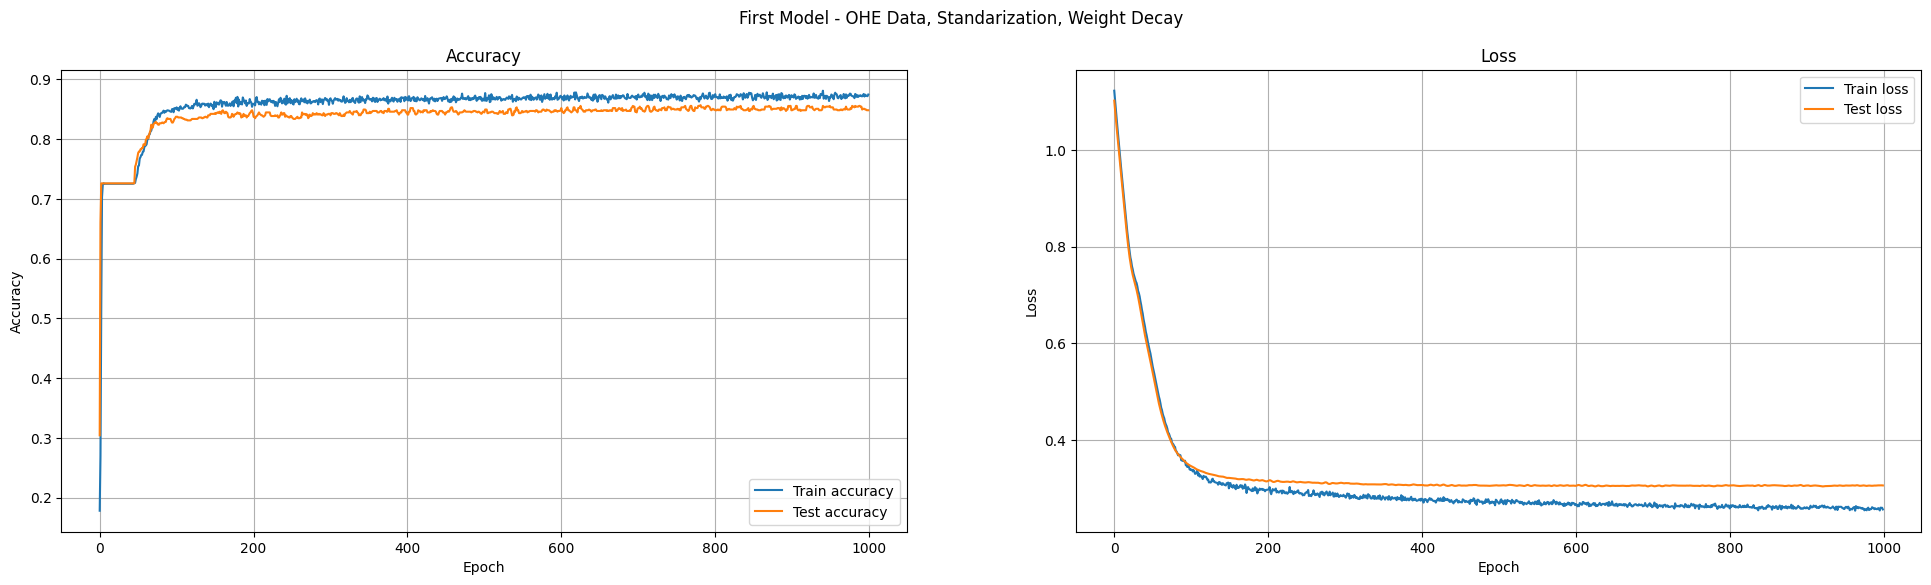

Train accuracy: 0.8748 | Test accuracy: 0.8485
Train loss: 0.2559 | Test loss: 0.3055
Class 'cheap': Accuracy: 0.78 (Correct: 87, Incorrect: 25, Total: 112)
Class 'average': Accuracy: 0.88 (Correct: 525, Incorrect: 74, Total: 599)
Class 'expensive': Accuracy: 0.77 (Correct: 88, Incorrect: 26, Total: 114)
Average accuracy: 0.81


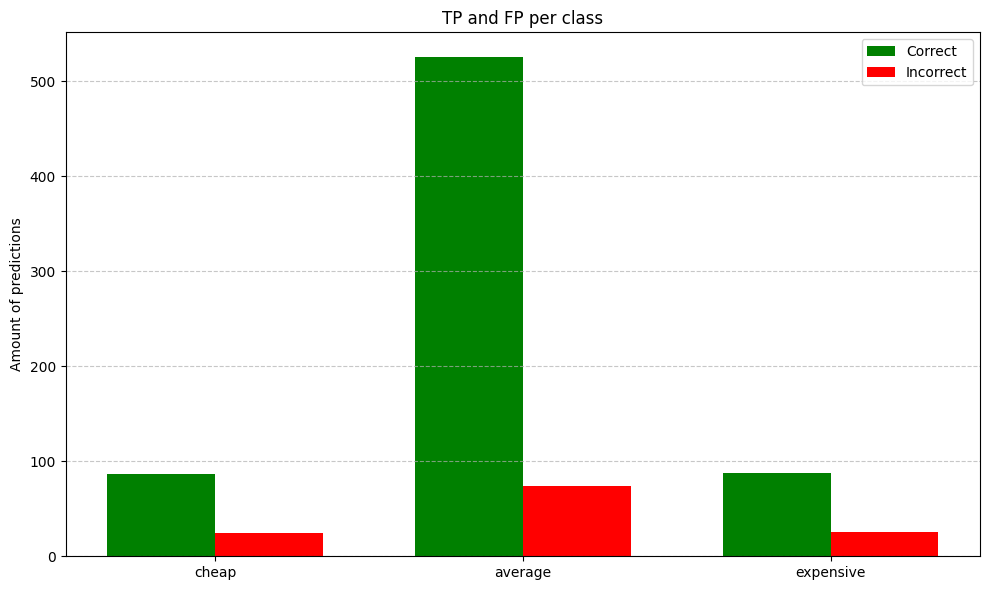

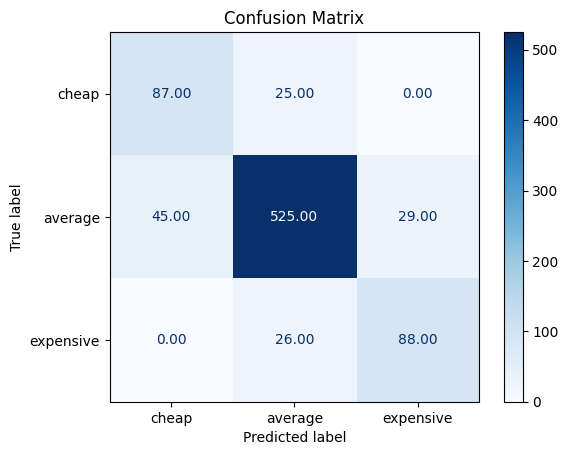

In [15]:
LR = 0.0001
HIDDEN_SIZE = 512
OUTPUT_SIZE = 3
DROPOUT = 0.2
EPOCHS = 1000
WEIGHT_DECAY = 0.0005


model, optimizer, criterion = build_model_and_optimizer(device, ThirdModel, x_train_ohe_tensor_scaled.shape[1], HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)

train_acc, test_acc, train_loss, test_loss, model = run_experiment(
    "First Model - OHE Data, Standarization, Weight Decay",
    model,
    optimizer,
    criterion,
    x_train_ohe_tensor_scaled,
    y_train_ohe_tensor_scaled,
    x_test_ohe_tensor_scaled,
    y_test_ohe_tensor_scaled,
    epochs=EPOCHS,
    verbose=True,
    is_plot=True,
    return_model=True,
    use_minibatch=False
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
plot_confusion_matrix(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

## 4.2 Regularyzacja w minibatchach


--- Running: BatchLayerWith3Layers - OHE Data, Standarization, Batch Size: 512, Weight Decay: 0.04 ---


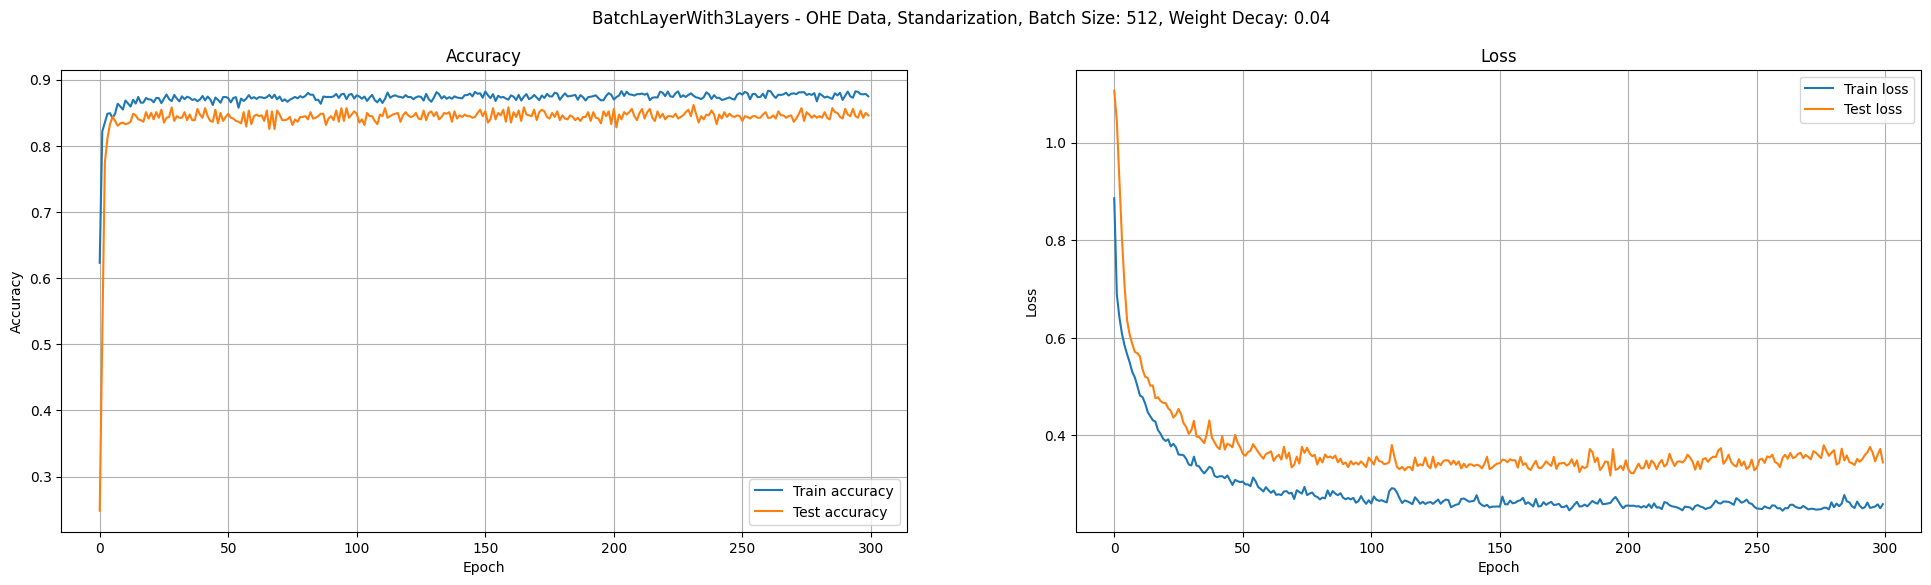

Train accuracy: 0.8748 | Test accuracy: 0.8461
Train loss: 0.2591 | Test loss: 0.3447
Class 'cheap': Accuracy: 0.80 (Correct: 90, Incorrect: 22, Total: 112)
Class 'average': Accuracy: 0.87 (Correct: 524, Incorrect: 75, Total: 599)
Class 'expensive': Accuracy: 0.74 (Correct: 84, Incorrect: 30, Total: 114)
Average accuracy: 0.81


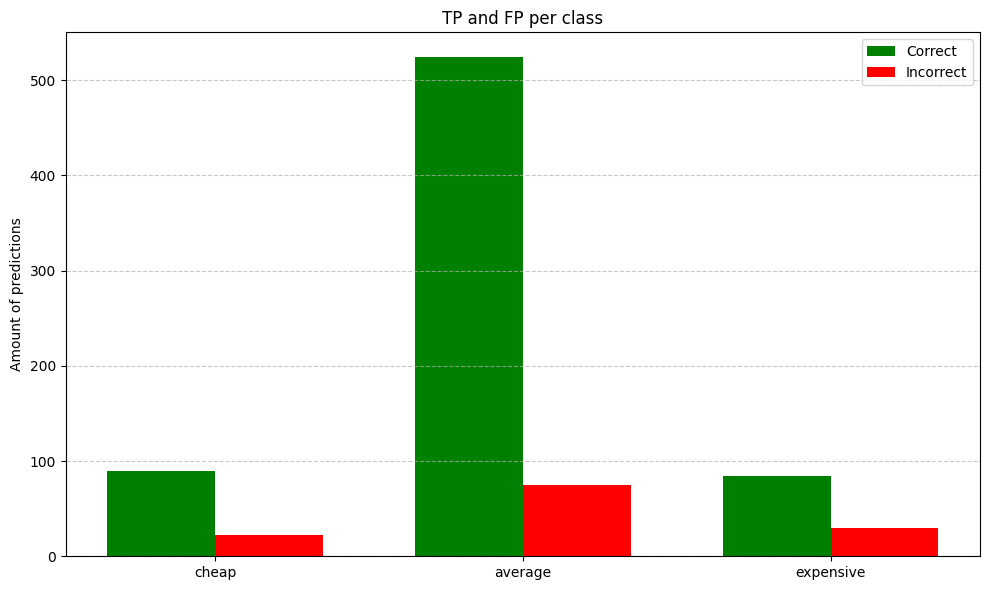

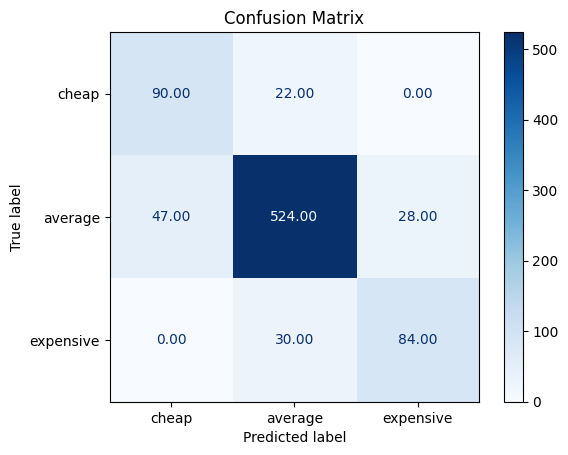

In [18]:
LR = 0.0001
HIDDEN_SIZE = 512
OUTPUT_SIZE = 3
DROPOUT = 0.2
EPOCHS = 300
WEIGHT_DECAY = 4e-2
BATCH_SIZE = 512



model, optimizer, criterion = build_model_and_optimizer(device, BatchLayerWith3Layers, x_train_ohe_tensor_scaled.shape[1], HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT, LR, WEIGHT_DECAY)
train_loader, test_loader = create_dataloader(x_train_ohe_tensor_scaled, y_train_ohe_tensor, x_test_ohe_tensor_scaled, y_test_ohe_tensor, BATCH_SIZE)

train_acc, test_acc, train_loss, test_loss, model = run_experiment(
    f"BatchLayerWith3Layers - OHE Data, Standarization, Batch Size: {BATCH_SIZE}, Weight Decay: {WEIGHT_DECAY}",
    model,
    optimizer,
    criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=EPOCHS,
    verbose=False,
    is_plot=True,
    return_model=True,
    use_minibatch=True,
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
plot_confusion_matrix(model, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)



### Wnioski
    1. Regularzacja poprawia wygląd funkcji straty, nasze modele już nie wykazują przeuczeń
    2. Średnie accuracy dalej jest w okolicach 81% dla obu modeli
    3. Przeuczenie z warstw z BatchNormami spadło
    4. Uczone przez za dużo epok, bo widać przeuczenie po około 200-300

# 5. Testowanie innych architektur
    1. Embeddingi
    2. OHE z ważeniem klas

## 5.1 Embeddingi

### Przygotowanie danych

In [10]:
data = pd.read_csv('train_data.csv')

data['label'] = data['SalePrice'].apply(lambda x: 'cheap' if x <= 100000 else ('average' if x <= 350000 else 'expensive'))
data.drop(columns=['SalePrice'], inplace=True)

categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
print(categorical_columns)

# rearange columns in this order : halway, heating, apt, time to bus, time to subway, subway station and other then the others linear
data = data[['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation'] + [col for col in data.columns if col not in ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation']]]

['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation', 'label']


In [39]:
data.head(5)

HallwayType         HeatingType        AptManageType TimeToBusStop  \
0    terraced  individual_heating  management_in_trust    5min~10min   
1    corridor  individual_heating      self_management        0~5min   
2    corridor  individual_heating      self_management        0~5min   
3    terraced  individual_heating  management_in_trust        0~5min   
4       mixed  individual_heating      self_management    5min~10min   

  TimeToSubway          SubwayStation  YearBuilt  Size(sqf)  Floor  \
0  10min~15min  Kyungbuk_uni_hospital       2006        814      3   
1   5min~10min                  Daegu       1985        587      8   
2   5min~10min                  Daegu       1985        587      6   
3       0-5min                Sin-nam       2006       2056      8   
4  15min~20min              Myung-duk       1992        644      2   

   N_Parkinglot(Ground)  N_Parkinglot(Basement)  N_manager  N_elevators  \
0                 111.0                   184.0        3.0          0.0   
1                  80.0                    76.0        2.0          2.0   
2                  80.0                    76.0        2.0          2.0   
3                 249.0                   536.0        5.0         11.0   
4                 142.0                    79.0        4.0          8.0   

   N_FacilitiesInApt  N_FacilitiesNearBy(Total)  N_SchoolNearBy(Total)  \
0                  5                        6.0                    9.0   
1                  3                       12.0                    4.0   
2                  3                       12.0                    4.0   
3                  5                        3.0                    7.0   
4                  3                        9.0                   14.0   

       label  
0    average  
1      cheap  
2      cheap  
3  expensive  
4      cheap

### Sprawdzenie minimalnych wymarów Embeddingów i zamiana na kody kategoryczne

In [11]:
print("HallwayType unique:", data["HallwayType"].nunique())
print("HeatingType unique:", data["HeatingType"].nunique())
print("AptManageType unique:", data["AptManageType"].nunique())
print("TimeToBusStop unique:", data["TimeToBusStop"].nunique())
print("TimeToSubway unique:", data["TimeToSubway"].nunique())
print("SubwayStation unique:", data["SubwayStation"].nunique())

HallwayType unique: 3
HeatingType unique: 2
AptManageType unique: 2
TimeToBusStop unique: 3
TimeToSubway unique: 5
SubwayStation unique: 8


In [12]:
data['HallwayType'] = data['HallwayType'].astype('category').cat.codes
data['HeatingType'] = data['HeatingType'].astype('category').cat.codes
data['AptManageType'] = data['AptManageType'].astype('category').cat.codes
data['TimeToBusStop'] = data['TimeToBusStop'].astype('category').cat.codes
data['TimeToSubway'] = data['TimeToSubway'].astype('category').cat.codes
data['SubwayStation'] = data['SubwayStation'].astype('category').cat.codes


In [13]:
class EmbeddingsNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, droput, num_dim):
        super().__init__()

        self.num_dim = num_dim

        # embedding layers
        self.hallway_type = nn.Embedding(3, self.num_dim)
        self.heating_type = nn.Embedding(2, self.num_dim)
        self.apt_manage_type = nn.Embedding(2, self.num_dim)
        self.time_to_bus_stop = nn.Embedding(3, self.num_dim)
        self.time_to_subway = nn.Embedding(5, self.num_dim)
        self.subway_station = nn.Embedding(8, self.num_dim)

        self.total_dim_added = self.num_dim * 6
        self.emmedded_columns = 6

        self.true_input_size = input_size + self.total_dim_added - self.emmedded_columns

        # linear layers
        self.fc1 = nn.Linear(self.true_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

        # activation
        self.activation = nn.LeakyReLU()

        # dropout
        self.dropout = nn.Dropout(droput)

        # batch norm
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)


    def forward(self, x):
        # cateogrical features
        hallway_type_emb = self.hallway_type(x[:, 0].long())
        heating_type_emb = self.heating_type(x[:, 1].long())
        apt_manage_type_emb = self.apt_manage_type(x[:, 2].long())
        time_to_bus_stop_emb = self.time_to_bus_stop(x[:, 3].long())
        time_to_subway_emb = self.time_to_subway(x[:, 4].long())
        subway_station_emb = self.subway_station(x[:, 5].long())

        # numeric features
        numeric_features = x[:, 6:]

        x = torch.cat([
            numeric_features,
            hallway_type_emb,
            heating_type_emb,
            apt_manage_type_emb,
            time_to_bus_stop_emb,
            time_to_subway_emb,
            subway_station_emb
        ], dim=1)

        # Then feed to the MLP
        x = self.fc1(x)
        x = self.activation(x)
        x = self.batch_norm1(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.activation(x)
        x = self.batch_norm2(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.activation(x)
        x = self.batch_norm3(x)
        x = self.dropout(x)

        x = self.fc4(x)
        return x


### device

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Ważenie danych

In [30]:

weigths = data['label'].value_counts()
total = weigths.sum()


class_weights = [total / weigths['cheap'], total / weigths['average'], total / weigths['expensive']]
normalized_class_weights = class_weights / np.sum(class_weights)

class_weights = torch.FloatTensor(normalized_class_weights).to(device)


### Podział na dane

In [63]:
x_train, x_test, y_train, y_test = split_data(data, test_size=0.25, label_column='label', random_state=42)
x_train, x_test = standardize_data(x_train, x_test, columns_to_skip=['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation'])

x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = convert_to_tensors(device, x_train, x_test, y_train, y_test)

train_loader, test_loader = create_dataloader(x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, batch_size=1024)


### Pierwsze testy : Average_Class_Accuraccy a ilość emebbed_dimensions


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.1774 | Train acc: 0.3253 | Test loss: 1.0920 | Test acc: 0.1959
Epoch: 20 | Train loss: 0.5534 | Train acc: 0.5315 | Test loss: 0.4877 | Test acc: 0.5868
Epoch: 40 | Train loss: 0.4912 | Train acc: 0.6589 | Test loss: 0.4215 | Test acc: 0.7430
Epoch: 60 | Train loss: 0.4547 | Train acc: 0.7064 | Test loss: 0.4093 | Test acc: 0.7595
Epoch: 80 | Train loss: 0.4401 | Train acc: 0.7391 | Test loss: 0.3849 | Test acc: 0.7866
Epoch: 100 | Train loss: 0.4178 | Train acc: 0.7608 | Test loss: 0.3788 | Test acc: 0.7730
Epoch: 120 | Train loss: 0.4098 | Train acc: 0.7523 | Test loss: 0.3821 | Test acc: 0.7682
Epoch: 140 | Train loss: 0.4001 | Train acc: 0.7724 | Test loss: 0.3744 | Test acc: 0.7983
Epoch: 160 | Train loss: 0.3976 | Train acc: 0.7759 | Test loss: 0.3797 | Test acc: 0.7866
Epoch: 180 | Train loss: 0.3691 | Train acc: 0.7908 | Test loss: 0.3658 | Test acc: 0.7886
Epoch: 200 | Train loss: 0

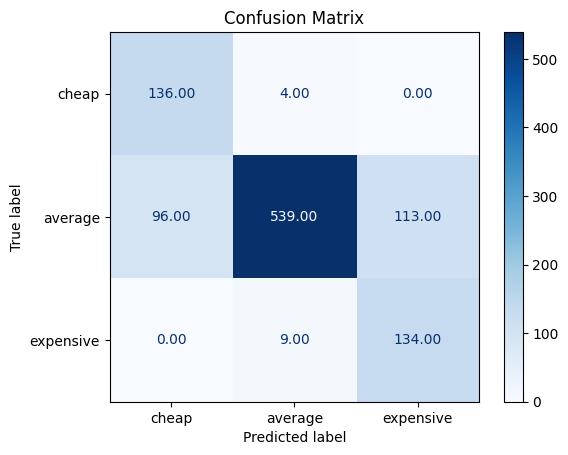


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.1446 | Train acc: 0.3301 | Test loss: 1.0900 | Test acc: 0.2066
Epoch: 20 | Train loss: 0.5591 | Train acc: 0.5500 | Test loss: 0.5025 | Test acc: 0.5655
Epoch: 40 | Train loss: 0.4895 | Train acc: 0.6566 | Test loss: 0.4423 | Test acc: 0.7081
Epoch: 60 | Train loss: 0.4642 | Train acc: 0.7013 | Test loss: 0.4294 | Test acc: 0.7536
Epoch: 80 | Train loss: 0.4403 | Train acc: 0.7365 | Test loss: 0.4077 | Test acc: 0.7614
Epoch: 100 | Train loss: 0.4316 | Train acc: 0.7540 | Test loss: 0.3881 | Test acc: 0.7779
Epoch: 120 | Train loss: 0.4090 | Train acc: 0.7565 | Test loss: 0.3894 | Test acc: 0.7682
Epoch: 140 | Train loss: 0.3934 | Train acc: 0.7759 | Test loss: 0.3699 | Test acc: 0.7905
Epoch: 160 | Train loss: 0.3993 | Train acc: 0.7769 | Test loss: 0.3724 | Test acc: 0.7837
Epoch: 180 | Train loss: 0.3801 | Train acc: 0.7921 | Test loss: 0.3616 | Test acc: 0.7963
Epoch: 200 | Train loss: 0

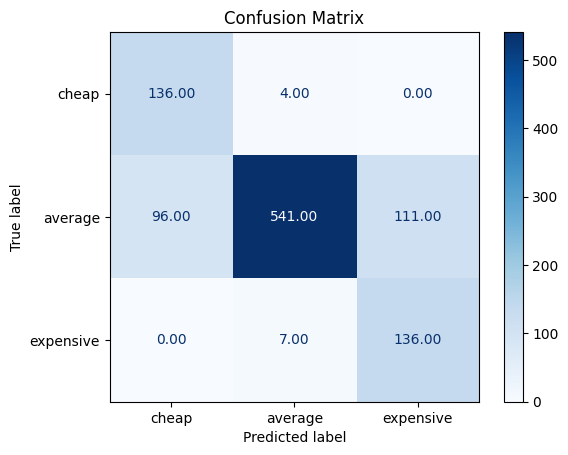


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.2459 | Train acc: 0.3295 | Test loss: 1.0919 | Test acc: 0.5829
Epoch: 20 | Train loss: 0.5729 | Train acc: 0.5189 | Test loss: 0.4994 | Test acc: 0.5509
Epoch: 40 | Train loss: 0.5007 | Train acc: 0.6327 | Test loss: 0.4392 | Test acc: 0.7197
Epoch: 60 | Train loss: 0.4623 | Train acc: 0.6941 | Test loss: 0.4188 | Test acc: 0.7556
Epoch: 80 | Train loss: 0.4465 | Train acc: 0.7239 | Test loss: 0.4011 | Test acc: 0.7730
Epoch: 100 | Train loss: 0.4221 | Train acc: 0.7523 | Test loss: 0.3862 | Test acc: 0.7779
Epoch: 120 | Train loss: 0.4078 | Train acc: 0.7523 | Test loss: 0.3890 | Test acc: 0.7721
Epoch: 140 | Train loss: 0.4003 | Train acc: 0.7679 | Test loss: 0.3655 | Test acc: 0.7973
Epoch: 160 | Train loss: 0.3878 | Train acc: 0.7737 | Test loss: 0.3682 | Test acc: 0.7895
Epoch: 180 | Train loss: 0.3841 | Train acc: 0.7811 | Test loss: 0.3555 | Test acc: 0.7915
Epoch: 200 | Train loss: 0

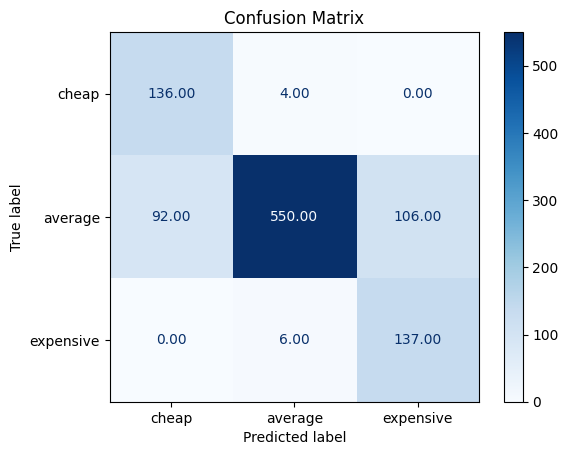


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.3659 | Train acc: 0.2913 | Test loss: 1.0988 | Test acc: 0.5344
Epoch: 20 | Train loss: 0.5851 | Train acc: 0.5205 | Test loss: 0.5139 | Test acc: 0.5577
Epoch: 40 | Train loss: 0.5221 | Train acc: 0.6224 | Test loss: 0.4601 | Test acc: 0.6760
Epoch: 60 | Train loss: 0.4786 | Train acc: 0.6670 | Test loss: 0.4376 | Test acc: 0.7187
Epoch: 80 | Train loss: 0.4630 | Train acc: 0.7161 | Test loss: 0.4101 | Test acc: 0.7614
Epoch: 100 | Train loss: 0.4462 | Train acc: 0.7226 | Test loss: 0.3992 | Test acc: 0.7643
Epoch: 120 | Train loss: 0.4222 | Train acc: 0.7391 | Test loss: 0.4074 | Test acc: 0.7614
Epoch: 140 | Train loss: 0.4142 | Train acc: 0.7543 | Test loss: 0.3759 | Test acc: 0.7798
Epoch: 160 | Train loss: 0.4055 | Train acc: 0.7675 | Test loss: 0.3853 | Test acc: 0.7769
Epoch: 180 | Train loss: 0.3870 | Train acc: 0.7863 | Test loss: 0.3630 | Test acc: 0.7953
Epoch: 200 | Train loss: 0

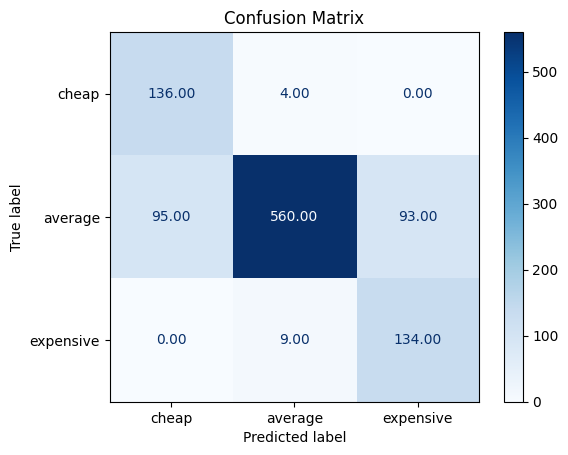


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.2896 | Train acc: 0.3540 | Test loss: 1.1030 | Test acc: 0.6722
Epoch: 20 | Train loss: 0.6005 | Train acc: 0.5002 | Test loss: 0.5430 | Test acc: 0.4811
Epoch: 40 | Train loss: 0.5459 | Train acc: 0.6017 | Test loss: 0.4851 | Test acc: 0.6518
Epoch: 60 | Train loss: 0.4944 | Train acc: 0.6266 | Test loss: 0.4652 | Test acc: 0.6654
Epoch: 80 | Train loss: 0.4739 | Train acc: 0.7051 | Test loss: 0.4363 | Test acc: 0.7381
Epoch: 100 | Train loss: 0.4593 | Train acc: 0.7106 | Test loss: 0.4144 | Test acc: 0.7759
Epoch: 120 | Train loss: 0.4386 | Train acc: 0.7161 | Test loss: 0.4168 | Test acc: 0.7565
Epoch: 140 | Train loss: 0.4149 | Train acc: 0.7414 | Test loss: 0.3818 | Test acc: 0.7662
Epoch: 160 | Train loss: 0.4229 | Train acc: 0.7608 | Test loss: 0.3768 | Test acc: 0.7895
Epoch: 180 | Train loss: 0.4030 | Train acc: 0.7717 | Test loss: 0.3595 | Test acc: 0.7895
Epoch: 200 | Train loss: 0

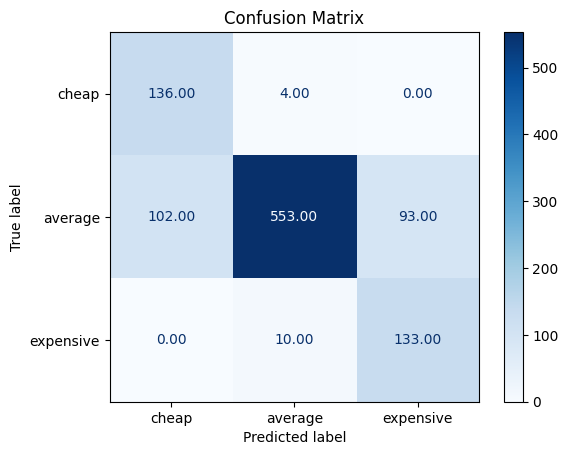

In [51]:
LR = 1e-4
WEIGHT_DECAY = 2e-4
HIDDEN_SIZE = 1024
OUTPUT_SIZE = 3
DROPOUT = 0.3
NUM_DIMS =[2, 4, 8, 16, 32]

avg_class_acc = {}

for num_dim in NUM_DIMS:
    model = EmbeddingsNeuralNetwork(x_train.shape[1], 1024, 3, 0.3, num_dim).to(device)
    optimizer = torch.optim.RAdam(model.parameters(), lr=1e-4, weight_decay=2e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    train_acc, test_acc, train_loss, test_loss, model = run_experiment(
        "Embeddings Neural Network with {num_dim} dimensions",
        model,
        optimizer,
        loss_fn,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=250,
        verbose=True,
        is_plot=False,
        return_model=True,
        use_minibatch=True
    )

    # plot confusion matrix and class acc
    avg_class = evaluate_model_per_class_accuracy(model, x_test_tensor, y_test_tensor, average_class_acc=True)
    plot_confusion_matrix(model, x_test_tensor, y_test_tensor)
    avg_class_acc[num_dim] = avg_class

In [52]:
avg_class_acc = pd.DataFrame.from_dict(avg_class_acc, orient='index', columns=['avg_class_acc'])
avg_class_acc.head().sort_values(by='avg_class_acc', ascending=False)

avg_class_acc
8        0.888255
16       0.885718
4        0.881913
32       0.880268
2        0.876360

### Dodanie dodatkowych kolumn to danych : HouseAge oraz Area_Per_Room

In [14]:
data['HouseAge'] = 2025 - data['YearBuilt']
data['Area_Per_Room'] = data["Size(sqf)"] / data["N_FacilitiesInApt"]

data.head(5)

HallwayType  HeatingType  AptManageType  TimeToBusStop  TimeToSubway  \
0            2            1              0              2             1   
1            0            1              1              0             3   
2            0            1              1              0             3   
3            2            1              0              0             0   
4            1            1              1              2             2   

   SubwayStation  YearBuilt  Size(sqf)  Floor  N_Parkinglot(Ground)  \
0              4       2006        814      3                 111.0   
1              3       1985        587      8                  80.0   
2              3       1985        587      6                  80.0   
3              6       2006       2056      8                 249.0   
4              5       1992        644      2                 142.0   

   N_Parkinglot(Basement)  N_manager  N_elevators  N_FacilitiesInApt  \
0                   184.0        3.0          0.0                  5   
1                    76.0        2.0          2.0                  3   
2                    76.0        2.0          2.0                  3   
3                   536.0        5.0         11.0                  5   
4                    79.0        4.0          8.0                  3   

   N_FacilitiesNearBy(Total)  N_SchoolNearBy(Total)      label  HouseAge  \
0                        6.0                    9.0    average        19   
1                       12.0                    4.0      cheap        40   
2                       12.0                    4.0      cheap        40   
3                        3.0                    7.0  expensive        19   
4                        9.0                   14.0      cheap        33   

   Area_Per_Room  
0     162.800000  
1     195.666667  
2     195.666667  
3     411.200000  
4     214.666667

In [15]:
x_train, x_test, y_train, y_test = split_data(data, test_size=0.25, label_column='label', random_state=42)
x_train, x_test = standardize_data(x_train, x_test, columns_to_skip=['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation'])

x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = convert_to_tensors(device, x_train, x_test, y_train, y_test)

train_loader, test_loader = create_dataloader(x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, batch_size=1024)


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.3671 | Train acc: 0.3265 | Test loss: 1.1195 | Test acc: 0.6091
Epoch: 20 | Train loss: 0.5511 | Train acc: 0.5538 | Test loss: 0.4744 | Test acc: 0.5868
Epoch: 40 | Train loss: 0.4696 | Train acc: 0.6686 | Test loss: 0.4180 | Test acc: 0.7430
Epoch: 60 | Train loss: 0.4352 | Train acc: 0.7145 | Test loss: 0.4023 | Test acc: 0.7546
Epoch: 80 | Train loss: 0.4217 | Train acc: 0.7556 | Test loss: 0.3878 | Test acc: 0.7827
Epoch: 100 | Train loss: 0.4145 | Train acc: 0.7672 | Test loss: 0.3723 | Test acc: 0.7750
Epoch: 120 | Train loss: 0.3903 | Train acc: 0.7698 | Test loss: 0.3767 | Test acc: 0.7730
Epoch: 140 | Train loss: 0.3899 | Train acc: 0.7869 | Test loss: 0.3607 | Test acc: 0.7983
Epoch: 160 | Train loss: 0.3831 | Train acc: 0.7873 | Test loss: 0.3750 | Test acc: 0.7886
Epoch: 180 | Train loss: 0.3720 | Train acc: 0.7895 | Test loss: 0.3565 | Test acc: 0.7983
Epoch: 200 | Train loss: 0

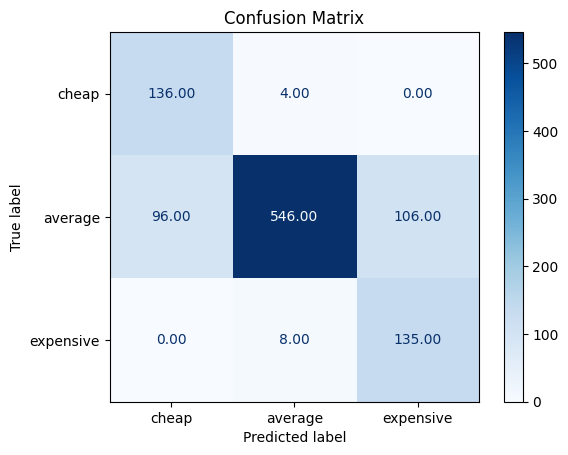


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.2370 | Train acc: 0.3107 | Test loss: 1.0993 | Test acc: 0.1339
Epoch: 20 | Train loss: 0.5619 | Train acc: 0.5399 | Test loss: 0.4988 | Test acc: 0.5558
Epoch: 40 | Train loss: 0.4907 | Train acc: 0.6667 | Test loss: 0.4372 | Test acc: 0.7187
Epoch: 60 | Train loss: 0.4577 | Train acc: 0.6993 | Test loss: 0.4259 | Test acc: 0.7498
Epoch: 80 | Train loss: 0.4432 | Train acc: 0.7414 | Test loss: 0.4007 | Test acc: 0.7750
Epoch: 100 | Train loss: 0.4104 | Train acc: 0.7575 | Test loss: 0.3905 | Test acc: 0.7721
Epoch: 120 | Train loss: 0.3949 | Train acc: 0.7637 | Test loss: 0.3807 | Test acc: 0.7721
Epoch: 140 | Train loss: 0.3942 | Train acc: 0.7827 | Test loss: 0.3709 | Test acc: 0.7992
Epoch: 160 | Train loss: 0.3812 | Train acc: 0.7902 | Test loss: 0.3812 | Test acc: 0.7876
Epoch: 180 | Train loss: 0.3600 | Train acc: 0.7921 | Test loss: 0.3573 | Test acc: 0.7953
Epoch: 200 | Train loss: 0

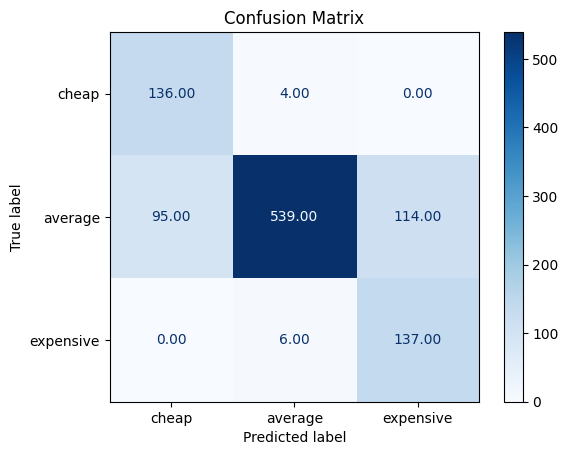


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.2189 | Train acc: 0.3653 | Test loss: 1.0936 | Test acc: 0.6848
Epoch: 20 | Train loss: 0.5546 | Train acc: 0.5412 | Test loss: 0.4908 | Test acc: 0.5752
Epoch: 40 | Train loss: 0.4923 | Train acc: 0.6618 | Test loss: 0.4367 | Test acc: 0.7158
Epoch: 60 | Train loss: 0.4676 | Train acc: 0.7016 | Test loss: 0.4092 | Test acc: 0.7527
Epoch: 80 | Train loss: 0.4392 | Train acc: 0.7459 | Test loss: 0.3903 | Test acc: 0.7953
Epoch: 100 | Train loss: 0.4240 | Train acc: 0.7523 | Test loss: 0.3816 | Test acc: 0.7798
Epoch: 120 | Train loss: 0.4049 | Train acc: 0.7595 | Test loss: 0.3871 | Test acc: 0.7750
Epoch: 140 | Train loss: 0.3875 | Train acc: 0.7798 | Test loss: 0.3593 | Test acc: 0.7934
Epoch: 160 | Train loss: 0.3949 | Train acc: 0.7821 | Test loss: 0.3715 | Test acc: 0.7905
Epoch: 180 | Train loss: 0.3705 | Train acc: 0.7879 | Test loss: 0.3534 | Test acc: 0.7944
Epoch: 200 | Train loss: 0

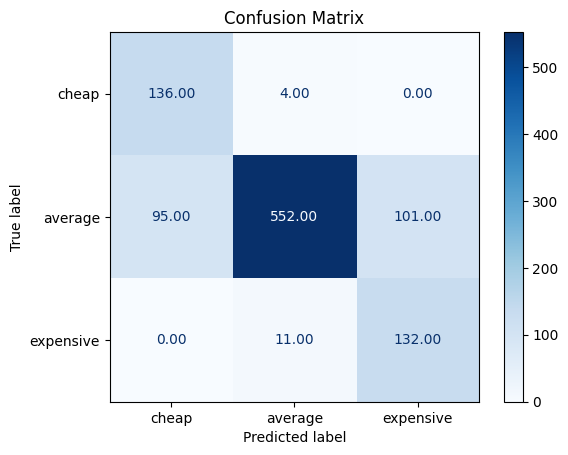


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.3261 | Train acc: 0.3026 | Test loss: 1.1104 | Test acc: 0.2580
Epoch: 20 | Train loss: 0.5901 | Train acc: 0.5024 | Test loss: 0.5209 | Test acc: 0.5674
Epoch: 40 | Train loss: 0.5136 | Train acc: 0.6298 | Test loss: 0.4454 | Test acc: 0.7216
Epoch: 60 | Train loss: 0.4734 | Train acc: 0.6835 | Test loss: 0.4222 | Test acc: 0.7682
Epoch: 80 | Train loss: 0.4520 | Train acc: 0.7239 | Test loss: 0.3986 | Test acc: 0.7798
Epoch: 100 | Train loss: 0.4405 | Train acc: 0.7501 | Test loss: 0.3879 | Test acc: 0.7905
Epoch: 120 | Train loss: 0.4150 | Train acc: 0.7517 | Test loss: 0.3880 | Test acc: 0.7701
Epoch: 140 | Train loss: 0.4114 | Train acc: 0.7637 | Test loss: 0.3501 | Test acc: 0.7973
Epoch: 160 | Train loss: 0.3936 | Train acc: 0.7650 | Test loss: 0.3633 | Test acc: 0.7847
Epoch: 180 | Train loss: 0.3839 | Train acc: 0.7831 | Test loss: 0.3523 | Test acc: 0.7934
Epoch: 200 | Train loss: 0

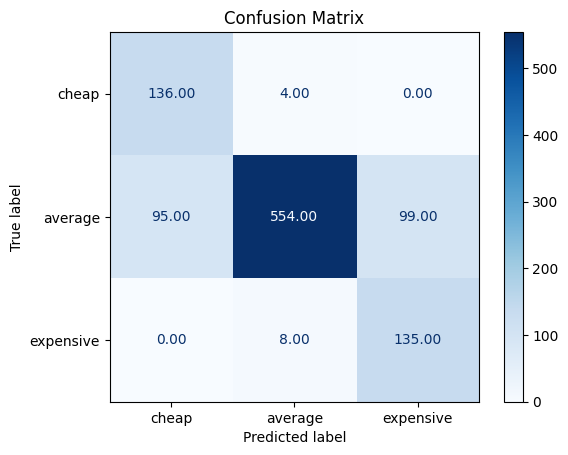


--- Running: Embeddings Neural Network with {num_dim} dimensions ---
Epoch: 0 | Train loss: 1.3624 | Train acc: 0.2984 | Test loss: 1.0927 | Test acc: 0.3792
Epoch: 20 | Train loss: 0.5957 | Train acc: 0.4960 | Test loss: 0.5362 | Test acc: 0.5073
Epoch: 40 | Train loss: 0.5270 | Train acc: 0.6166 | Test loss: 0.4762 | Test acc: 0.6993
Epoch: 60 | Train loss: 0.4970 | Train acc: 0.6715 | Test loss: 0.4444 | Test acc: 0.7459
Epoch: 80 | Train loss: 0.4582 | Train acc: 0.7194 | Test loss: 0.4179 | Test acc: 0.7750
Epoch: 100 | Train loss: 0.4404 | Train acc: 0.7443 | Test loss: 0.4022 | Test acc: 0.7798
Epoch: 120 | Train loss: 0.4189 | Train acc: 0.7501 | Test loss: 0.3943 | Test acc: 0.7662
Epoch: 140 | Train loss: 0.4123 | Train acc: 0.7627 | Test loss: 0.3776 | Test acc: 0.7886
Epoch: 160 | Train loss: 0.4008 | Train acc: 0.7750 | Test loss: 0.3759 | Test acc: 0.7983
Epoch: 180 | Train loss: 0.3918 | Train acc: 0.7886 | Test loss: 0.3580 | Test acc: 0.8128
Epoch: 200 | Train loss: 0

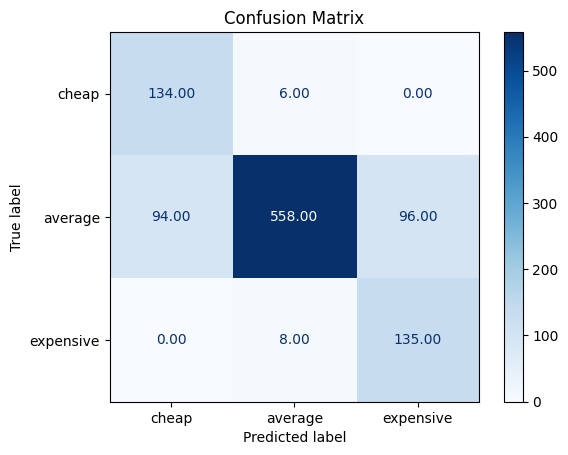

In [ ]:
LR = 1e-4
WEIGHT_DECAY = 2e-4
HIDDEN_SIZE = 1024
OUTPUT_SIZE = 3
DROPOUT = 0.3
NUM_DIMS =[2, 4, 8, 16, 32]

avg_class_acc = {}

for num_dim in NUM_DIMS:
    model = EmbeddingsNeuralNetwork(x_train.shape[1], 1024, 3, 0.3, num_dim).to(device)
    optimizer = torch.optim.RAdam(model.parameters(), lr=1e-4, weight_decay=2e-4)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    train_acc, test_acc, train_loss, test_loss, model = run_experiment(
        "Embeddings Neural Network with {num_dim} dimensions",
        model,
        optimizer,
        loss_fn,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=250,
        verbose=True,
        is_plot=False,
        return_model=True,
        use_minibatch=True
    )

    # plot confusion matrix and class acc
    avg_class = evaluate_model_per_class_accuracy(model, x_test_tensor, y_test_tensor, average_class_acc=True)
    plot_confusion_matrix(model, x_test_tensor, y_test_tensor)
    avg_class_acc[num_dim] = avg_class

In [56]:
avg_class_acc = pd.DataFrame.from_dict(avg_class_acc, orient='index', columns=['avg_class_acc'])
avg_class_acc.head().sort_values(by='avg_class_acc', ascending=False)

avg_class_acc
16       0.885375
4        0.883353
32       0.882396
2        0.881810
8        0.877491

### Dostrajanie wag klas

In [17]:
class_weights

tensor([0.4600, 0.0864, 0.4536], device='cuda:0')


--- Running: Embeddings Neural Network with 16 dimensions and boosted class 1 weights ---
Epoch: 0 | Train loss: 1.3080 | Train acc: 0.3020 | Test loss: 1.1067 | Test acc: 0.2609
Epoch: 20 | Train loss: 0.7059 | Train acc: 0.5716 | Test loss: 0.6206 | Test acc: 0.6935
Epoch: 40 | Train loss: 0.6188 | Train acc: 0.6841 | Test loss: 0.5370 | Test acc: 0.7624
Epoch: 60 | Train loss: 0.5687 | Train acc: 0.7336 | Test loss: 0.5142 | Test acc: 0.8012
Epoch: 80 | Train loss: 0.5415 | Train acc: 0.7614 | Test loss: 0.4807 | Test acc: 0.7963
Epoch: 100 | Train loss: 0.5256 | Train acc: 0.7853 | Test loss: 0.4669 | Test acc: 0.8293
Epoch: 120 | Train loss: 0.4858 | Train acc: 0.7837 | Test loss: 0.4536 | Test acc: 0.8167
Epoch: 140 | Train loss: 0.4760 | Train acc: 0.7924 | Test loss: 0.4123 | Test acc: 0.8147
Epoch: 160 | Train loss: 0.4560 | Train acc: 0.7957 | Test loss: 0.4217 | Test acc: 0.8167
Epoch: 180 | Train loss: 0.4479 | Train acc: 0.8031 | Test loss: 0.4018 | Test acc: 0.8303
Epoch

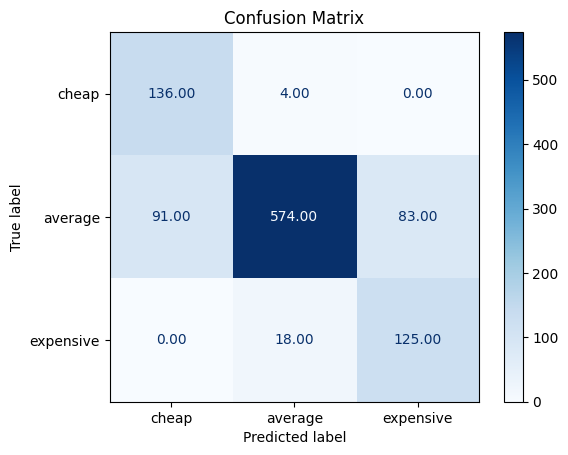

In [22]:
# zwiększenie wagi dla klasy 1
class_weights[1] = 0.15
model = EmbeddingsNeuralNetwork(x_train.shape[1], 1024, 3, 0.3, 16).to(device)
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-4, weight_decay=2e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

train_acc, test_acc, train_loss, test_loss, model = run_experiment(
    "Embeddings Neural Network with 16 dimensions and boosted class 1 weights",
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=250,
    verbose=True,
    is_plot=False,
    return_model=True,
    use_minibatch=True
)

# plot confusion matrix and class acc
avg_class = evaluate_model_per_class_accuracy(model, x_test_tensor, y_test_tensor, average_class_acc=True)
plot_confusion_matrix(model, x_test_tensor, y_test_tensor)

Podbicie wag dla klasy pierwszej lekko zwiększa skuteczność rozpoznawania jej. Warto przetestować więcej opcji


--- Running: Embeddings Neural Network with 16 dimensions and boosted class 1 weights 0.1 ---
Epoch: 0 | Train loss: 1.3216 | Train acc: 0.3023 | Test loss: 1.1095 | Test acc: 0.2590
Epoch: 20 | Train loss: 0.6215 | Train acc: 0.5212 | Test loss: 0.5480 | Test acc: 0.5965
Epoch: 40 | Train loss: 0.5419 | Train acc: 0.6444 | Test loss: 0.4696 | Test acc: 0.7304
Epoch: 60 | Train loss: 0.4997 | Train acc: 0.6990 | Test loss: 0.4469 | Test acc: 0.7750
Epoch: 80 | Train loss: 0.4765 | Train acc: 0.7329 | Test loss: 0.4209 | Test acc: 0.7827
Epoch: 100 | Train loss: 0.4655 | Train acc: 0.7575 | Test loss: 0.4102 | Test acc: 0.7934
Epoch: 120 | Train loss: 0.4358 | Train acc: 0.7608 | Test loss: 0.4090 | Test acc: 0.7740
Epoch: 140 | Train loss: 0.4307 | Train acc: 0.7727 | Test loss: 0.3665 | Test acc: 0.7983
Epoch: 160 | Train loss: 0.4129 | Train acc: 0.7763 | Test loss: 0.3818 | Test acc: 0.7944
Epoch: 180 | Train loss: 0.4012 | Train acc: 0.7902 | Test loss: 0.3638 | Test acc: 0.8070
E

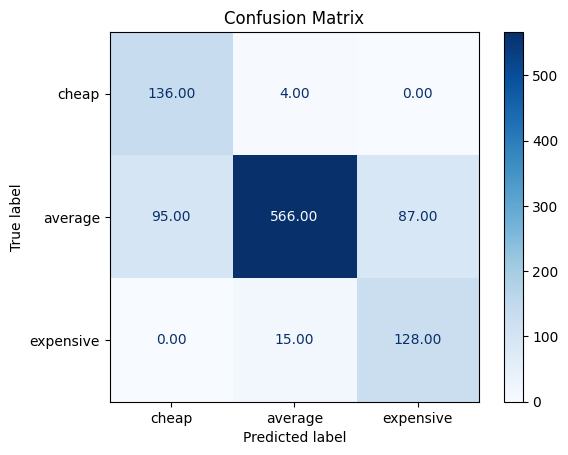


--- Running: Embeddings Neural Network with 16 dimensions and boosted class 1 weights 0.15 ---
Epoch: 0 | Train loss: 1.3080 | Train acc: 0.3020 | Test loss: 1.1067 | Test acc: 0.2609
Epoch: 20 | Train loss: 0.7059 | Train acc: 0.5716 | Test loss: 0.6206 | Test acc: 0.6935
Epoch: 40 | Train loss: 0.6188 | Train acc: 0.6841 | Test loss: 0.5370 | Test acc: 0.7624
Epoch: 60 | Train loss: 0.5687 | Train acc: 0.7336 | Test loss: 0.5142 | Test acc: 0.8012
Epoch: 80 | Train loss: 0.5415 | Train acc: 0.7614 | Test loss: 0.4807 | Test acc: 0.7963
Epoch: 100 | Train loss: 0.5256 | Train acc: 0.7853 | Test loss: 0.4669 | Test acc: 0.8293
Epoch: 120 | Train loss: 0.4858 | Train acc: 0.7837 | Test loss: 0.4536 | Test acc: 0.8167
Epoch: 140 | Train loss: 0.4760 | Train acc: 0.7924 | Test loss: 0.4123 | Test acc: 0.8147
Epoch: 160 | Train loss: 0.4560 | Train acc: 0.7957 | Test loss: 0.4217 | Test acc: 0.8167
Epoch: 180 | Train loss: 0.4479 | Train acc: 0.8031 | Test loss: 0.4018 | Test acc: 0.8303


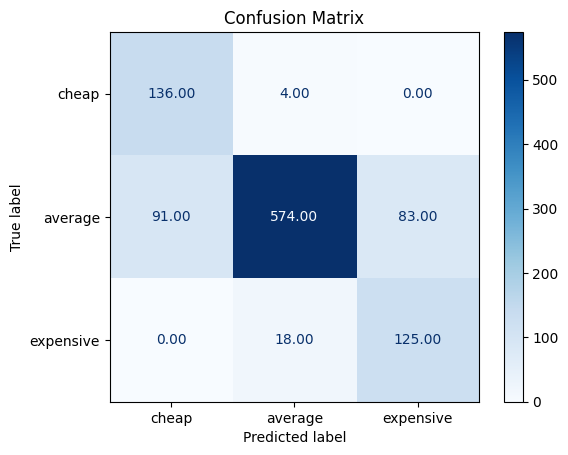


--- Running: Embeddings Neural Network with 16 dimensions and boosted class 1 weights 0.2 ---
Epoch: 0 | Train loss: 1.2979 | Train acc: 0.3020 | Test loss: 1.1046 | Test acc: 0.2638
Epoch: 20 | Train loss: 0.7605 | Train acc: 0.5959 | Test loss: 0.6662 | Test acc: 0.7207
Epoch: 40 | Train loss: 0.6671 | Train acc: 0.7042 | Test loss: 0.5786 | Test acc: 0.8089
Epoch: 60 | Train loss: 0.6111 | Train acc: 0.7572 | Test loss: 0.5554 | Test acc: 0.8089
Epoch: 80 | Train loss: 0.5793 | Train acc: 0.7785 | Test loss: 0.5152 | Test acc: 0.8264
Epoch: 100 | Train loss: 0.5599 | Train acc: 0.7999 | Test loss: 0.4965 | Test acc: 0.8400
Epoch: 120 | Train loss: 0.5139 | Train acc: 0.7999 | Test loss: 0.4818 | Test acc: 0.8254
Epoch: 140 | Train loss: 0.5018 | Train acc: 0.8063 | Test loss: 0.4272 | Test acc: 0.8361
Epoch: 160 | Train loss: 0.4815 | Train acc: 0.8160 | Test loss: 0.4466 | Test acc: 0.8264
Epoch: 180 | Train loss: 0.4628 | Train acc: 0.8202 | Test loss: 0.4297 | Test acc: 0.8380
E

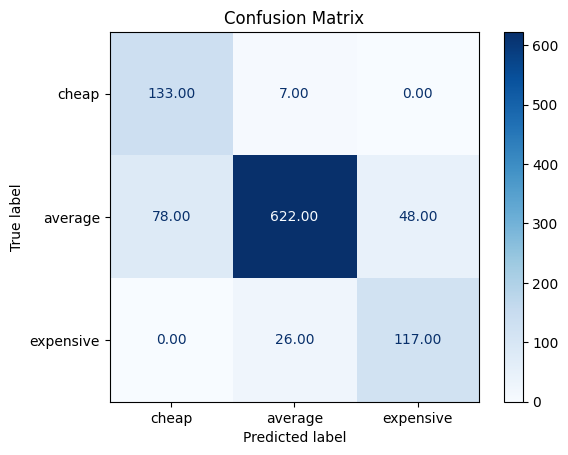


--- Running: Embeddings Neural Network with 16 dimensions and boosted class 1 weights 0.25 ---
Epoch: 0 | Train loss: 1.2901 | Train acc: 0.3023 | Test loss: 1.1030 | Test acc: 0.2629
Epoch: 20 | Train loss: 0.7978 | Train acc: 0.6101 | Test loss: 0.6971 | Test acc: 0.7410
Epoch: 40 | Train loss: 0.6997 | Train acc: 0.7252 | Test loss: 0.6071 | Test acc: 0.8186
Epoch: 60 | Train loss: 0.6389 | Train acc: 0.7717 | Test loss: 0.5817 | Test acc: 0.8235
Epoch: 80 | Train loss: 0.6029 | Train acc: 0.7844 | Test loss: 0.5343 | Test acc: 0.8312
Epoch: 100 | Train loss: 0.5788 | Train acc: 0.8067 | Test loss: 0.5134 | Test acc: 0.8400
Epoch: 120 | Train loss: 0.5275 | Train acc: 0.8144 | Test loss: 0.4945 | Test acc: 0.8196
Epoch: 140 | Train loss: 0.5117 | Train acc: 0.8180 | Test loss: 0.4402 | Test acc: 0.8361
Epoch: 160 | Train loss: 0.4851 | Train acc: 0.8296 | Test loss: 0.4597 | Test acc: 0.8390
Epoch: 180 | Train loss: 0.4700 | Train acc: 0.8290 | Test loss: 0.4253 | Test acc: 0.8477


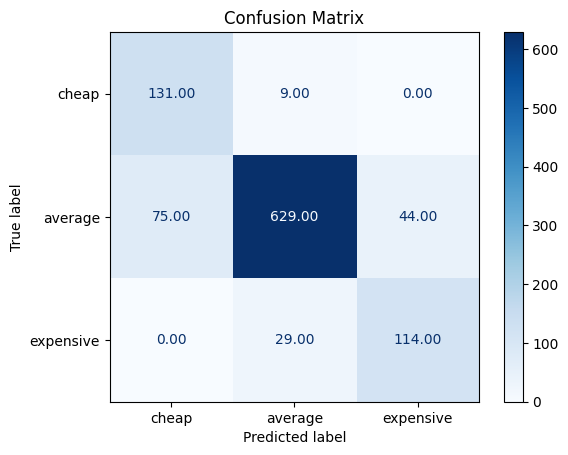

In [23]:
class_one_weights = [0.1, 0.15, 0.2, 0.25]
avg_acc_per_class_one_weight = {}

for class_w in class_one_weights:
    class_weights[1] = class_w
    model = EmbeddingsNeuralNetwork(x_train.shape[1], 1024, 3, 0.3, 16).to(device)
    optimizer = torch.optim.RAdam(model.parameters(), lr=1e-4, weight_decay=2e-4)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    train_acc, test_acc, train_loss, test_loss, model = run_experiment(
        f"Embeddings Neural Network with 16 dimensions and boosted class 1 weights {class_w}",
        model,
        optimizer,
        loss_fn,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=250,
        verbose=True,
        is_plot=False,
        return_model=True,
        use_minibatch=True
    )

    # plot confusion matrix and class acc
    avg_class = evaluate_model_per_class_accuracy(model, x_test_tensor, y_test_tensor, average_class_acc=True)
    plot_confusion_matrix(model, x_test_tensor, y_test_tensor)
    avg_acc_per_class_one_weight[class_w] = avg_class
avg_acc_per_class_one_weight = pd.DataFrame.from_dict(avg_acc_per_class_one_weight, orient='index', columns=['avg_class_acc'])


Zwiększenie wag dla klasy pierwszej znacznie poprawiło wyniki rozpoznawania jej, kosztem rozpoznawania klasy 2. Z danych widzę, że model osiąga dobre wartośći po 200 epokach. Warto przetestować go na tych parametrach i może lekko zboostować klasę 2

In [31]:
class_weights

tensor([0.4600, 0.0864, 0.4536], device='cuda:0')


--- Running: Embeddings Neural Network with 16 dimensions and boosted classes weights ---
Epoch: 0 | Train loss: 1.2970 | Train acc: 0.3143 | Test loss: 1.1179 | Test acc: 0.1358
Epoch: 20 | Train loss: 0.7125 | Train acc: 0.5787 | Test loss: 0.6422 | Test acc: 0.6615
Epoch: 40 | Train loss: 0.6367 | Train acc: 0.6883 | Test loss: 0.5667 | Test acc: 0.7624
Epoch: 60 | Train loss: 0.5825 | Train acc: 0.7249 | Test loss: 0.5392 | Test acc: 0.7953
Epoch: 80 | Train loss: 0.5591 | Train acc: 0.7737 | Test loss: 0.5103 | Test acc: 0.7934
Epoch: 100 | Train loss: 0.5375 | Train acc: 0.7869 | Test loss: 0.4737 | Test acc: 0.8303
Epoch: 120 | Train loss: 0.4968 | Train acc: 0.7866 | Test loss: 0.4535 | Test acc: 0.8215
Epoch: 140 | Train loss: 0.4820 | Train acc: 0.7979 | Test loss: 0.4153 | Test acc: 0.8371
Epoch: 160 | Train loss: 0.4601 | Train acc: 0.8147 | Test loss: 0.4443 | Test acc: 0.8293
Epoch: 180 | Train loss: 0.4407 | Train acc: 0.8222 | Test loss: 0.4130 | Test acc: 0.8409
Train

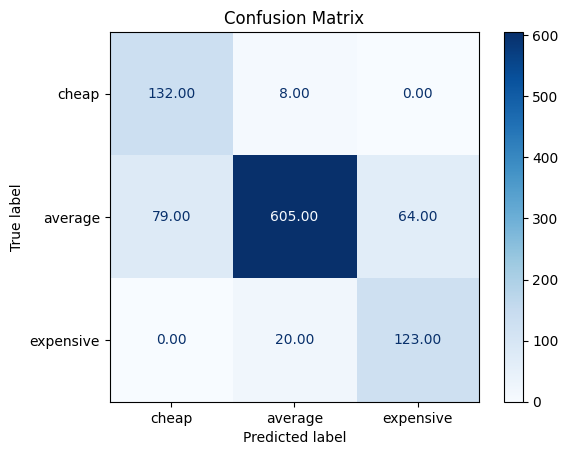

In [34]:
class_weights[1] = 0.2
class_weights[2] = 0.6
class_weights[0] = 0.55
model = EmbeddingsNeuralNetwork(x_train.shape[1], 1024, 3, 0.3, 16).to(device)
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-4, weight_decay=2e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

train_acc, test_acc, train_loss, test_loss, model = run_experiment(
    f"Embeddings Neural Network with 16 dimensions and boosted classes weights",
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=200,
    verbose=True,
    is_plot=False,
    return_model=True,
    use_minibatch=True
)

# plot confusion matrix and class acc
avg_class = evaluate_model_per_class_accuracy(model, x_test_tensor, y_test_tensor, average_class_acc=True)
plot_confusion_matrix(model, x_test_tensor, y_test_tensor)

Metodą prób i błędów próbowałem ustalić jakie wagi dadzą najlepsze rezultaty. Udało mi się osiągnąć wyniki w miarę zadowalające, to jest accuracy rozpoznawania każdej klasy powyżej 80%. Mimo, że ogólna średnia accuracy pośród klas nie jest wtedy największa, to wyniki mogą okazać się najstabilniejsze, zakładając że mieszkania ze średniej klasy mogą być najpopularniejszymi wśród dostępnych ofert

## 5.2 OHE i ważenie danych

Przetestuje także OHE z ważeniem danych oraz z dodaniem dwóch wyżej wspomnianych kolumn, wcelu zobaczenia efektów

In [57]:
ohe_data['HouseAge'] = 2025 - ohe_data['YearBuilt']
ohe_data["AvgRoomSize"] = ohe_data['Size(sqf)'] / ohe_data['N_FacilitiesInApt']
ohe_data.head(5)

YearBuilt  Size(sqf)  Floor  N_Parkinglot(Ground)  N_Parkinglot(Basement)  \
0       2006        814      3                 111.0                   184.0   
1       1985        587      8                  80.0                    76.0   
2       1985        587      6                  80.0                    76.0   
3       2006       2056      8                 249.0                   536.0   
4       1992        644      2                 142.0                    79.0   

   N_manager  N_elevators  N_FacilitiesInApt  N_FacilitiesNearBy(Total)  \
0        3.0          0.0                  5                        6.0   
1        2.0          2.0                  3                       12.0   
2        2.0          2.0                  3                       12.0   
3        5.0         11.0                  5                        3.0   
4        4.0          8.0                  3                        9.0   

   N_SchoolNearBy(Total)  ... SubwayStation_Bangoge  SubwayStation_Banwoldang  \
0                    9.0  ...                   0.0                       0.0   
1                    4.0  ...                   0.0                       0.0   
2                    4.0  ...                   0.0                       0.0   
3                    7.0  ...                   0.0                       0.0   
4                   14.0  ...                   0.0                       0.0   

   SubwayStation_Chil-sung-market  SubwayStation_Daegu  \
0                             0.0                  0.0   
1                             0.0                  1.0   
2                             0.0                  1.0   
3                             0.0                  0.0   
4                             0.0                  0.0   

   SubwayStation_Kyungbuk_uni_hospital  SubwayStation_Myung-duk  \
0                                  1.0                      0.0   
1                                  0.0                      0.0   
2                                  0.0                      0.0   
3                                  0.0                      0.0   
4                                  0.0                      1.0   

   SubwayStation_Sin-nam  SubwayStation_no_subway_nearby  HouseAge  \
0                    0.0                             0.0        19   
1                    0.0                             0.0        40   
2                    0.0                             0.0        40   
3                    1.0                             0.0        19   
4                    0.0                             0.0        33   

   AvgRoomSize  
0   162.800000  
1   195.666667  
2   195.666667  
3   411.200000  
4   214.666667  

[5 rows x 36 columns]

### Obliczenie wag klas

In [36]:
weigths = ohe_data['label'].value_counts()
weigths
class_weights = {0: weigths['cheap'], 1: weigths['average'], 2: weigths['expensive']}
total = weigths.sum()
class_weights = [total / weigths['cheap'], total / weigths['average'], total / weigths['expensive']]

ohe_class_weights = torch.FloatTensor(class_weights).to(device)


--- Running: BatchLayerWith2Layers - OHE Data, Standarization, Weight Decay ---
Epoch: 0 | Train loss: 1.1659 | Train acc: 0.3864 | Test loss: 1.0692 | Test acc: 0.3317
Epoch: 20 | Train loss: 0.3685 | Train acc: 0.7966 | Test loss: 0.3925 | Test acc: 0.7827
Epoch: 40 | Train loss: 0.3212 | Train acc: 0.8060 | Test loss: 0.3574 | Test acc: 0.7876
Epoch: 60 | Train loss: 0.2959 | Train acc: 0.8054 | Test loss: 0.3391 | Test acc: 0.7818
Epoch: 80 | Train loss: 0.2727 | Train acc: 0.8089 | Test loss: 0.3241 | Test acc: 0.7886
Epoch: 100 | Train loss: 0.2772 | Train acc: 0.8128 | Test loss: 0.3189 | Test acc: 0.7953
Epoch: 120 | Train loss: 0.2564 | Train acc: 0.8154 | Test loss: 0.3099 | Test acc: 0.8021
Epoch: 140 | Train loss: 0.2555 | Train acc: 0.8251 | Test loss: 0.2990 | Test acc: 0.7983
Epoch: 160 | Train loss: 0.2601 | Train acc: 0.8244 | Test loss: 0.3228 | Test acc: 0.7963
Epoch: 180 | Train loss: 0.2453 | Train acc: 0.8248 | Test loss: 0.3011 | Test acc: 0.7963


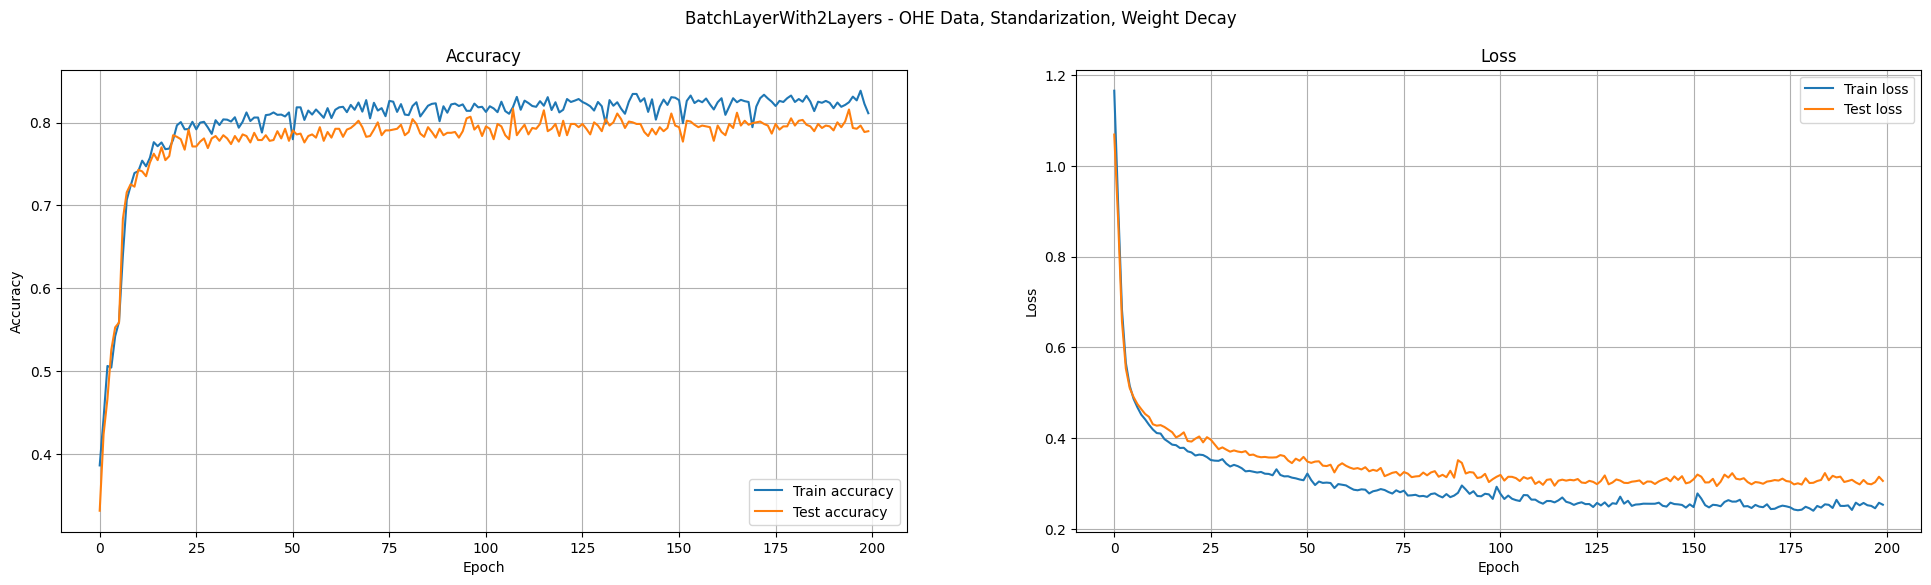

Train accuracy: 0.8112 | Test accuracy: 0.7895
Train loss: 0.2533 | Test loss: 0.3057
Class 'cheap': Accuracy: 0.99 (Correct: 138, Incorrect: 2, Total: 140)
Class 'average': Accuracy: 0.73 (Correct: 543, Incorrect: 205, Total: 748)
Class 'expensive': Accuracy: 0.93 (Correct: 133, Incorrect: 10, Total: 143)
Average accuracy: 0.88


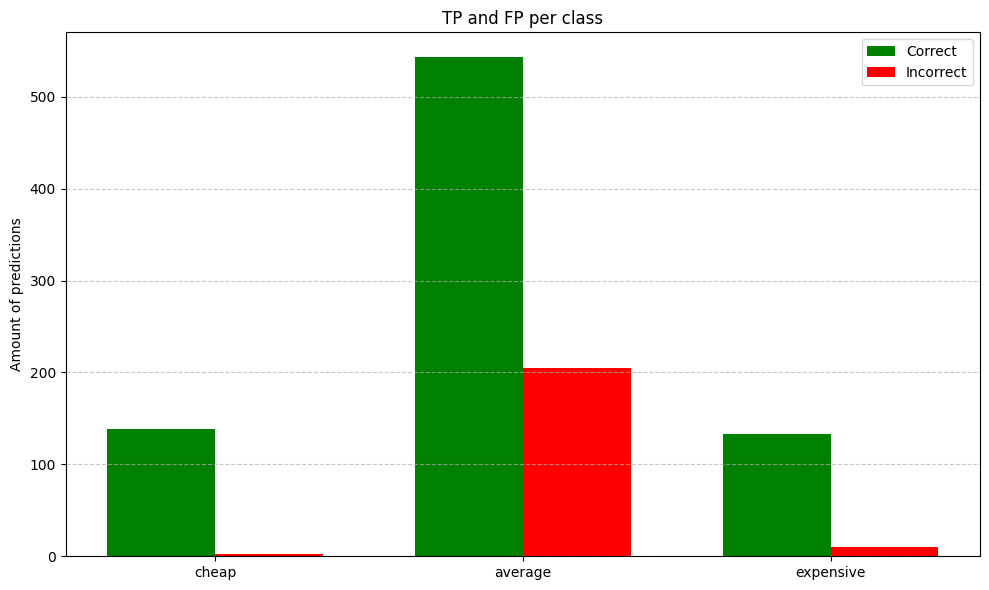

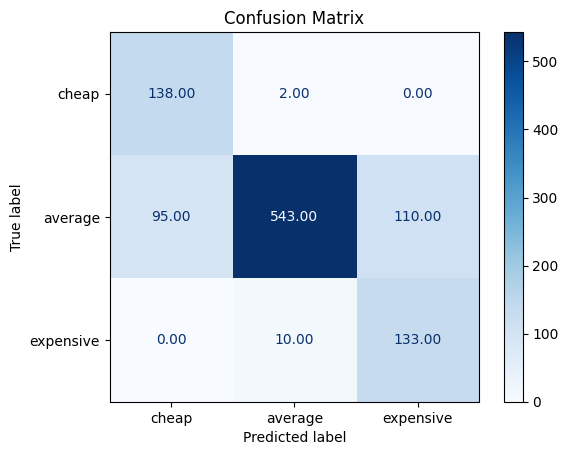

In [60]:
# ohe data
TEST_SIZE = 0.25
RANDOM_STATE = 42
COLUMNS_TO_SKIP_SCALING = ['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced',
                           'HeatingType_central_heating', 'HeatingType_individual_heating',
                           'AptManageType_management_in_trust', 'AptManageType_self_management',
                           'TimeToBusStop_0~5min', 'TimeToBusStop_10min~15min', 'TimeToBusStop_5min~10min',
                           'TimeToSubway_0-5min', 'TimeToSubway_10min~15min', 'TimeToSubway_15min~20min',
                           'TimeToSubway_5min~10min', 'TimeToSubway_no_bus_stop_nearby',
                           'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market',
                           'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk',
                           'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']
x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = split_data(ohe_data, test_size=TEST_SIZE, label_column='label', random_state=RANDOM_STATE)
x_train_ohe_scaled, x_test_ohe_scaled = standardize_data(x_train_ohe, x_test_ohe, columns_to_skip=COLUMNS_TO_SKIP_SCALING)

# Use this for training
x_train_ohe_tensor, x_test_ohe_tensor, y_train_ohe_tensor, y_test_ohe_tensor = convert_to_tensors(device, x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe)
x_train_ohe_tensor_scaled, x_test_ohe_tensor_scaled, y_train_ohe_tensor_scaled, y_test_ohe_tensor_scaled = convert_to_tensors(device, x_train_ohe_scaled, x_test_ohe_scaled, y_train_ohe, y_test_ohe)
train_loader, test_loader = create_dataloader(x_train_ohe_tensor_scaled, y_train_ohe_tensor_scaled, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled, batch_size=256)

model = BatchLayerWith2Layers(x_train_ohe_tensor_scaled.shape[1], 512, 3, 0.1).to(device)
optimizer = torch.optim.RAdam(model.parameters(), lr=2e-4, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)


train_acc, test_acc, train_loss, test_loss, model_class = run_experiment(
    "BatchLayerWith2Layers - OHE Data, Standarization, Weight Decay",
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=200,
    verbose=True,
    is_plot=True,
    return_model=True,
    use_minibatch=True,
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model_class, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
plot_confusion_matrix(model_class, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

### OHE i zmiana wag danych

In [37]:
ohe_class_weights

tensor([7.3381, 1.3783, 7.2351], device='cuda:0')

In [43]:
ohe_class_weights[1] = 2.5
ohe_class_weights[2] = 8
ohe_class_weights

tensor([7.3381, 2.5000, 8.0000], device='cuda:0')


--- Running: BatchLayerWith2Layers - OHE Data, Standarization, Weight Decay and modified class weights ---
Epoch: 0 | Train loss: 1.2752 | Train acc: 0.3156 | Test loss: 1.0812 | Test acc: 0.3201
Epoch: 20 | Train loss: 0.4111 | Train acc: 0.8193 | Test loss: 0.4480 | Test acc: 0.8157
Epoch: 40 | Train loss: 0.3589 | Train acc: 0.8442 | Test loss: 0.3876 | Test acc: 0.8070
Epoch: 60 | Train loss: 0.3284 | Train acc: 0.8322 | Test loss: 0.3765 | Test acc: 0.8031
Epoch: 80 | Train loss: 0.3120 | Train acc: 0.8286 | Test loss: 0.3609 | Test acc: 0.8080
Epoch: 100 | Train loss: 0.3178 | Train acc: 0.8413 | Test loss: 0.3586 | Test acc: 0.8196
Epoch: 120 | Train loss: 0.2958 | Train acc: 0.8471 | Test loss: 0.3420 | Test acc: 0.8293
Epoch: 140 | Train loss: 0.2972 | Train acc: 0.8464 | Test loss: 0.3425 | Test acc: 0.8215
Epoch: 160 | Train loss: 0.2995 | Train acc: 0.8442 | Test loss: 0.3665 | Test acc: 0.8157
Epoch: 180 | Train loss: 0.2786 | Train acc: 0.8358 | Test loss: 0.3403 | Test 

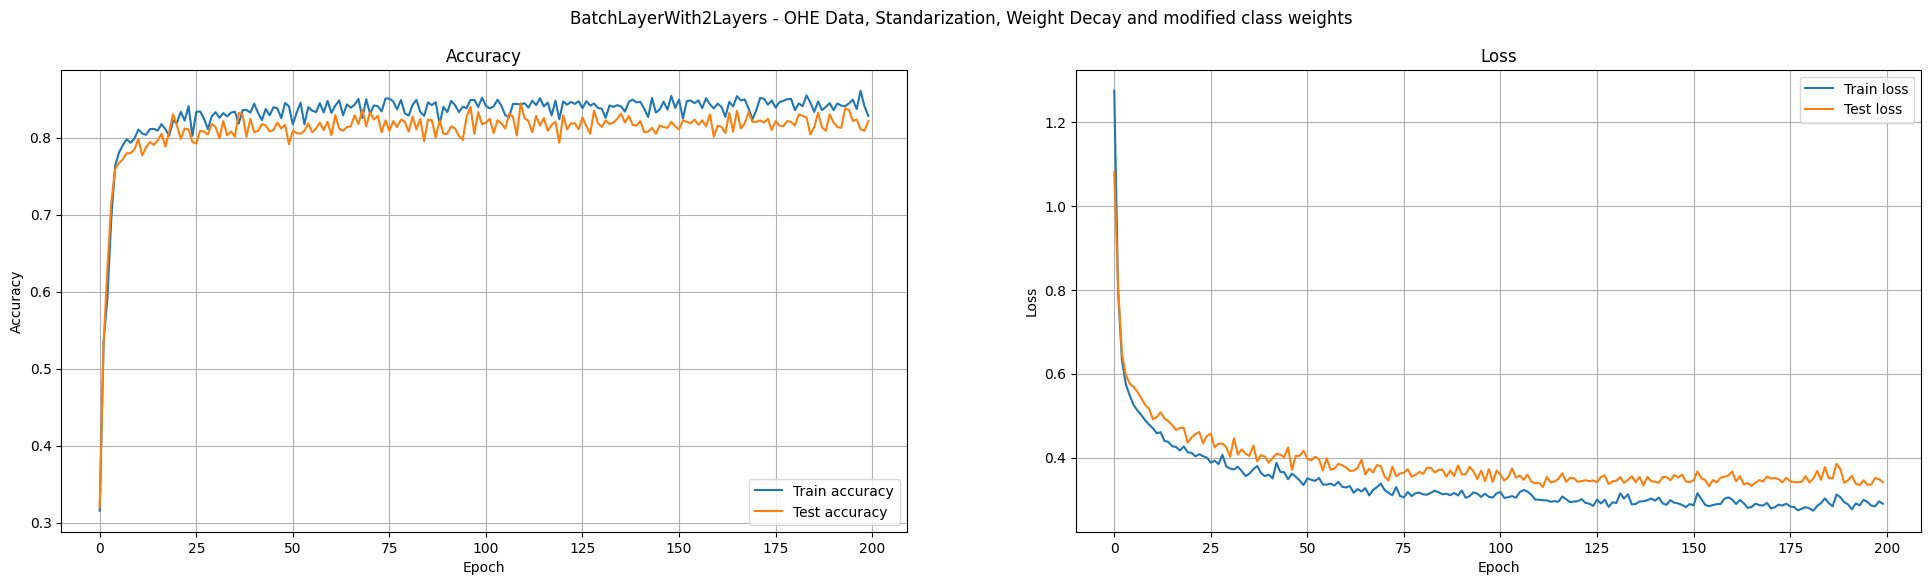

Train accuracy: 0.8283 | Test accuracy: 0.8215
Train loss: 0.2897 | Test loss: 0.3411
Class 'cheap': Accuracy: 0.94 (Correct: 132, Incorrect: 8, Total: 140)
Class 'average': Accuracy: 0.78 (Correct: 586, Incorrect: 162, Total: 748)
Class 'expensive': Accuracy: 0.90 (Correct: 129, Incorrect: 14, Total: 143)
Average accuracy: 0.88


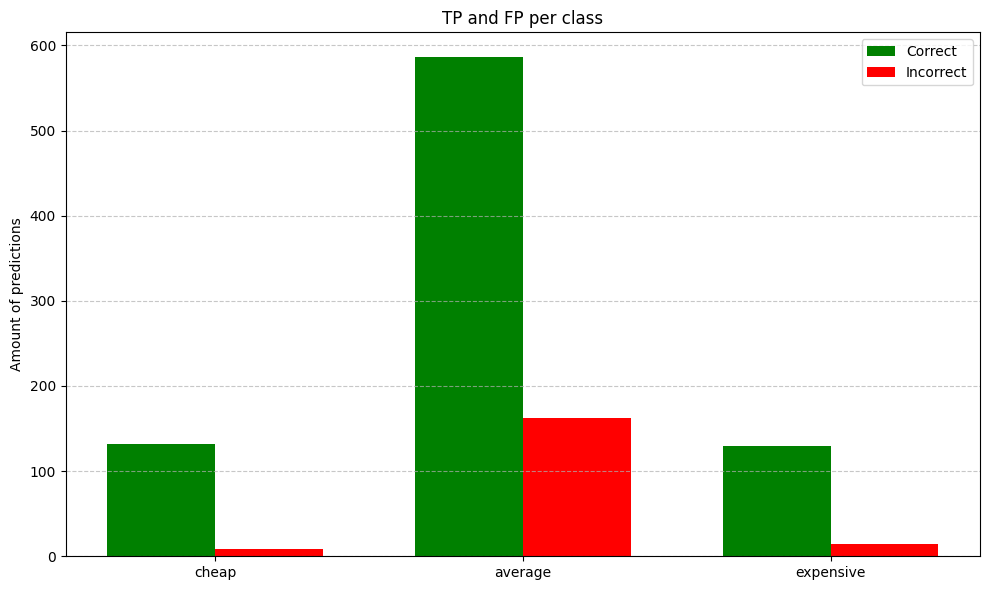

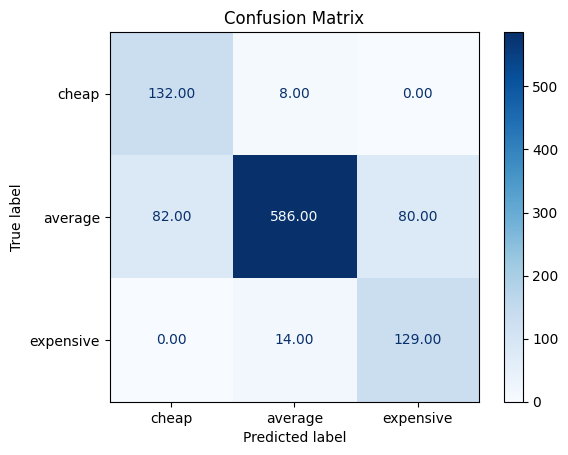

In [45]:
# ohe data
TEST_SIZE = 0.25
RANDOM_STATE = 42
COLUMNS_TO_SKIP_SCALING = ['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced',
                           'HeatingType_central_heating', 'HeatingType_individual_heating',
                           'AptManageType_management_in_trust', 'AptManageType_self_management',
                           'TimeToBusStop_0~5min', 'TimeToBusStop_10min~15min', 'TimeToBusStop_5min~10min',
                           'TimeToSubway_0-5min', 'TimeToSubway_10min~15min', 'TimeToSubway_15min~20min',
                           'TimeToSubway_5min~10min', 'TimeToSubway_no_bus_stop_nearby',
                           'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market',
                           'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk',
                           'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']
x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = split_data(ohe_data, test_size=TEST_SIZE, label_column='label', random_state=RANDOM_STATE)
x_train_ohe_scaled, x_test_ohe_scaled = standardize_data(x_train_ohe, x_test_ohe, columns_to_skip=COLUMNS_TO_SKIP_SCALING)

# Use this for training
x_train_ohe_tensor, x_test_ohe_tensor, y_train_ohe_tensor, y_test_ohe_tensor = convert_to_tensors(device, x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe)
x_train_ohe_tensor_scaled, x_test_ohe_tensor_scaled, y_train_ohe_tensor_scaled, y_test_ohe_tensor_scaled = convert_to_tensors(device, x_train_ohe_scaled, x_test_ohe_scaled, y_train_ohe, y_test_ohe)
train_loader, test_loader = create_dataloader(x_train_ohe_tensor_scaled, y_train_ohe_tensor_scaled, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled, batch_size=256)

model = BatchLayerWith2Layers(x_train_ohe_tensor_scaled.shape[1], 1024, 3, 0.1).to(device)
optimizer = torch.optim.RAdam(model.parameters(), lr=2e-4, weight_decay=3e-3)
loss_fn = nn.CrossEntropyLoss(weight=ohe_class_weights)


train_acc, test_acc, train_loss, test_loss, model_class = run_experiment(
    "BatchLayerWith2Layers - OHE Data, Standarization, Weight Decay and modified class weights",
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=200,
    verbose=True,
    is_plot=True,
    return_model=True,
    use_minibatch=True,
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model_class, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
plot_confusion_matrix(model_class, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

Podobnie metoda prób i błędów zmieniania wag polepsza wyniki klasy średnie, natomiast inne klasy tym cierpią. Wyniki podobnie jak z modelu z Embaddingami są bardziej stabile i każda klasa potrafi osiągnąć acc powyżej 80%, natomiast średnie acc względem klas maleje

## OHE z ważonymi danymi - FullBatch

In [46]:
weigths = ohe_data['label'].value_counts()
weigths
class_weights = {0: weigths['cheap'], 1: weigths['average'], 2: weigths['expensive']}
total = weigths.sum()
class_weights = [total / weigths['cheap'], total / weigths['average'], total / weigths['expensive']]

ohe_class_weights = torch.FloatTensor(class_weights).to(device)

In [53]:
ohe_class_weights

tensor([7.3381, 1.3783, 7.2351], device='cuda:0')

In [54]:
ohe_class_weights[1] = 2


--- Running: BatchLayerWith2Layers - OHE Data, Standarization, Weight Decay and modified class weights, no batch ---
Epoch: 0 | Train loss: 1.0935 | Train acc: 0.3291 | Test loss: 1.0928 | Test acc: 0.3666
Epoch: 20 | Train loss: 1.0561 | Train acc: 0.6592 | Test loss: 1.0454 | Test acc: 0.7381
Epoch: 40 | Train loss: 0.9591 | Train acc: 0.7698 | Test loss: 0.9340 | Test acc: 0.7643
Epoch: 60 | Train loss: 0.7950 | Train acc: 0.7307 | Test loss: 0.7536 | Test acc: 0.7100
Epoch: 80 | Train loss: 0.6031 | Train acc: 0.7307 | Test loss: 0.5662 | Test acc: 0.7051
Epoch: 100 | Train loss: 0.4728 | Train acc: 0.7734 | Test loss: 0.4543 | Test acc: 0.7556
Epoch: 120 | Train loss: 0.4120 | Train acc: 0.8105 | Test loss: 0.3995 | Test acc: 0.7924
Epoch: 140 | Train loss: 0.3797 | Train acc: 0.8183 | Test loss: 0.3705 | Test acc: 0.8080
Epoch: 160 | Train loss: 0.3592 | Train acc: 0.8251 | Test loss: 0.3542 | Test acc: 0.8080
Epoch: 180 | Train loss: 0.3507 | Train acc: 0.8248 | Test loss: 0.34

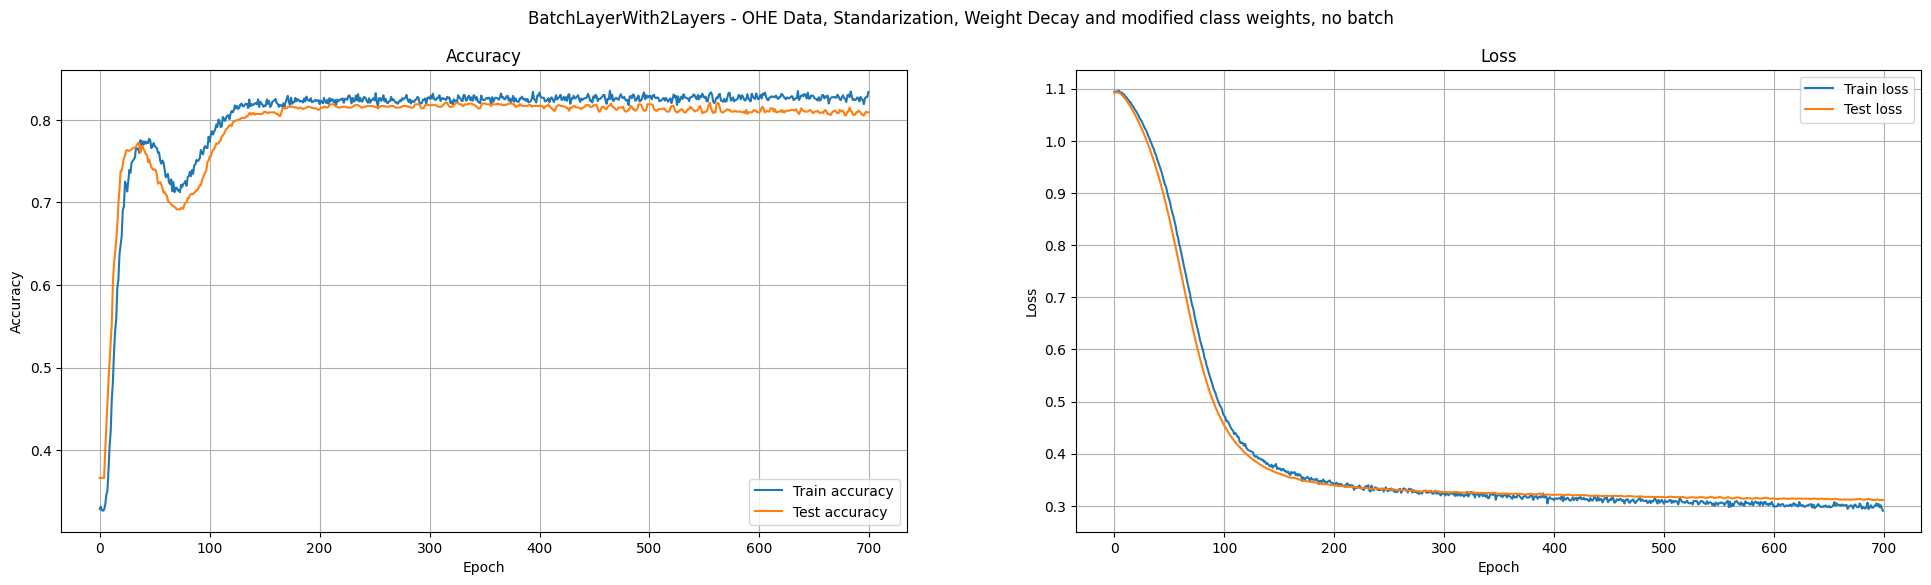

Train accuracy: 0.8335 | Test accuracy: 0.8089
Train loss: 0.2906 | Test loss: 0.3108
Class 'cheap': Accuracy: 0.99 (Correct: 138, Incorrect: 2, Total: 140)
Class 'average': Accuracy: 0.75 (Correct: 563, Incorrect: 185, Total: 748)
Class 'expensive': Accuracy: 0.93 (Correct: 133, Incorrect: 10, Total: 143)
Average accuracy: 0.89


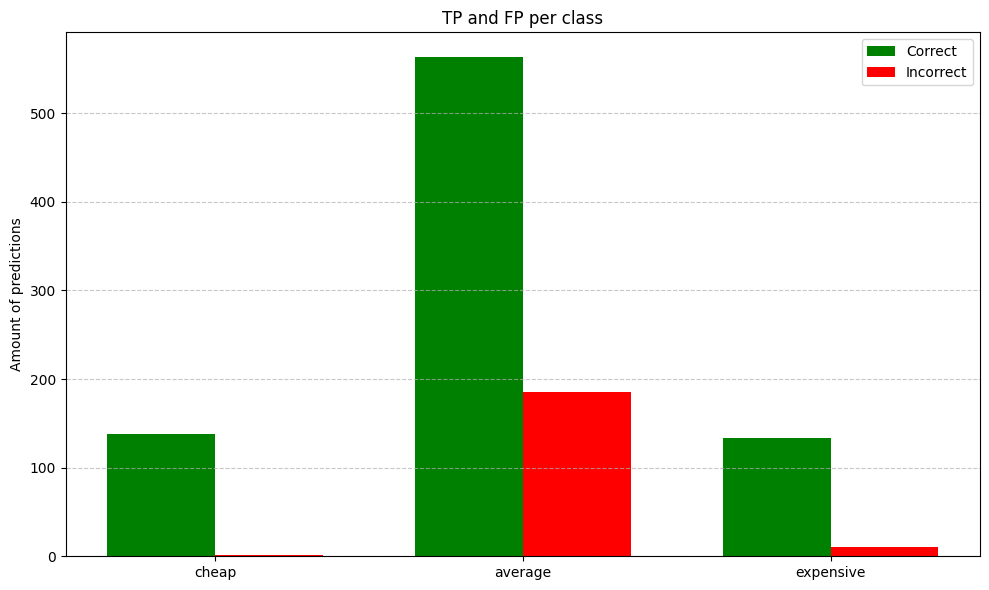

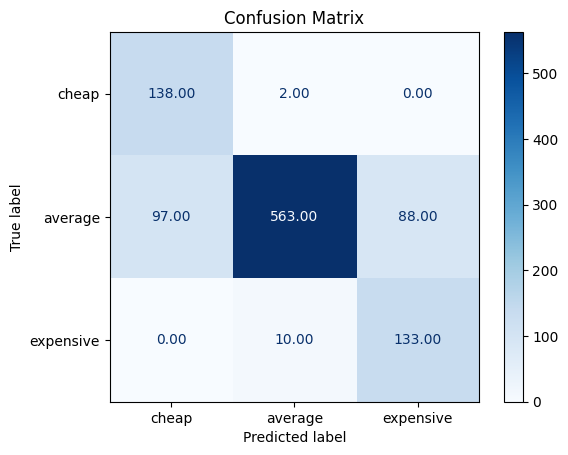

In [58]:
# ohe data
model = ThirdModel(x_train_ohe_tensor_scaled.shape[1], 1600, 3, 0.3).to(device)
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-4, weight_decay=4e-3)
loss_fn = nn.CrossEntropyLoss(weight=ohe_class_weights)


train_acc, test_acc, train_loss, test_loss, model_class = run_experiment(
    "BatchLayerWith2Layers - OHE Data, Standarization, Weight Decay and modified class weights, no batch",
    model,
    optimizer,
    loss_fn,
    x_train=x_train_ohe_tensor_scaled,
    y_train=y_train_ohe_tensor_scaled,
    x_test=x_test_ohe_tensor_scaled,
    y_test=y_test_ohe_tensor_scaled,
    epochs=700,
    verbose=True,
    is_plot=True,
    return_model=True,
    use_minibatch=False,
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model_class, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)
plot_confusion_matrix(model_class, x_test_ohe_tensor_scaled, y_test_ohe_tensor_scaled)

- Użycie FullBatcha daja podobne rezultaty co z użyciem MicroBatchy
- Model dalej najgorzej rozpoznaje klasę "1", natomiast natomiast pozostałe 2 klasy rozpoznaje w bardzo dobry sposób
- Testy przeprowadzane były metodą prób i błędów dla różnych wartości, aczkolwiek nie udało mi się znaleźć lepszej średniej niż ta dla wag wyznaczonych poprzez stosunek liczby wystąpień klasy względem próbek

## Wnoski
    1. Stworzenie modelu z Embeddingami oraz z ważeniem klas znacznie polepszyło rezultaty. Dzięki ważeni klas model lepiej reaguje na dysproporcje w danych treningowych i osiąga lepsze accuracy. Średnia dla klas podchodząca nawet pod 89%. Najwięcej błędów jest popełnianych przy klasie "average"
    2. Model z ważeniem danych oraz zastosowaniem OHE również spisał się nieźle, podchodząc pod accuracy na wysokości 88%
    3. Wydaje mi si, że oba modele można podkręcić do 90%, jeśli wykonałobysię bardzo dobre dostrajanie modelu
    4. Dodanie 2 dodatkowych kolumn z informacjami lekko poprawiło wyniki
    5. W modelu z Embeddingami dodanie wymiarów między 8 a 16 jest optymalną opcją. Zbyt małe wymiary lub zbyt duże obniżają (w małym stopniu) acc
    6. Największy problem jest z dobrym określeniem klasy "average". Accuracy na tej klasie w okolicach 75%. Pozostałem kalsy osiągają wyniki powyżej 94%

# 6. Predykcje

### Wytrenowanie modelu
- batchsize = 1024
- hidden_size = 1024
- lr = 1e-4
- weight_decay = 2e-4 
- dropout = 0.3
- test_size = 0.25
- num_dims = 16


--- Running: Embeddings Neural Network with 16 dimensions ---


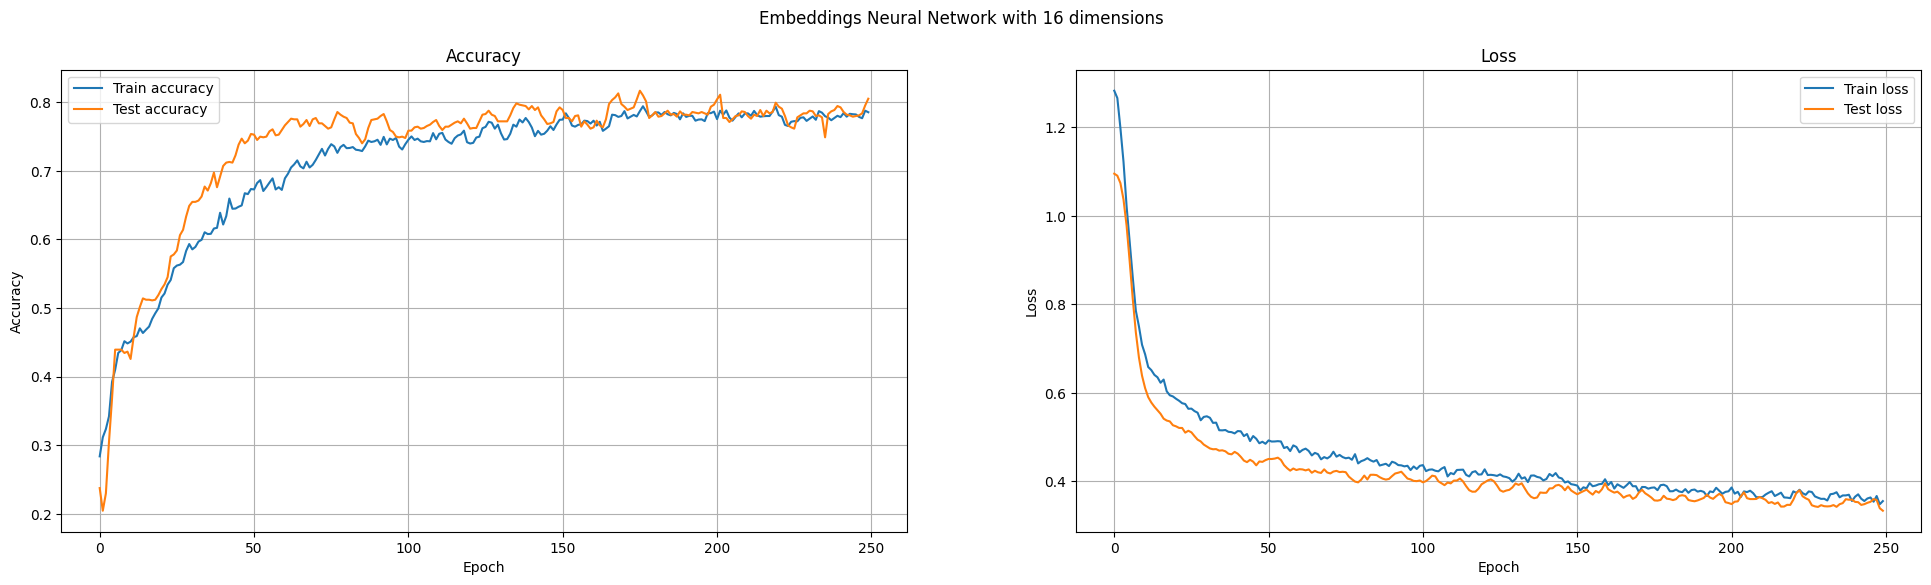

Train accuracy: 0.7853 | Test accuracy: 0.8050
Train loss: 0.3552 | Test loss: 0.3334
Class 'cheap': Accuracy: 0.97 (Correct: 136, Incorrect: 4, Total: 140)
Class 'average': Accuracy: 0.75 (Correct: 560, Incorrect: 188, Total: 748)
Class 'expensive': Accuracy: 0.94 (Correct: 134, Incorrect: 9, Total: 143)
Average accuracy: 0.89


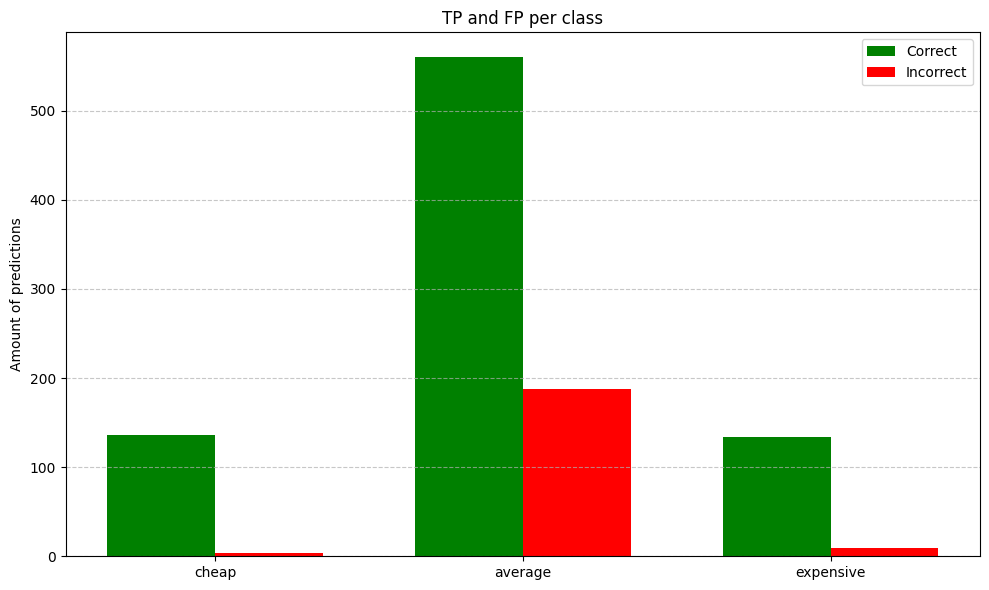

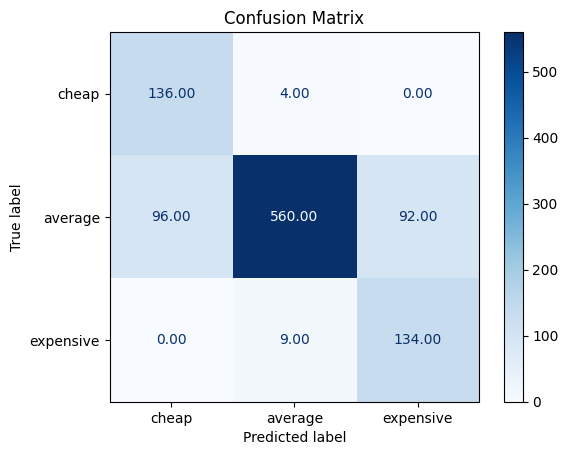

In [95]:
LR = 1e-4
WEIGHT_DECAY = 2e-4
HIDDEN_SIZE = 1024
OUTPUT_SIZE = 3
DROPOUT = 0.3
NUM_DIMS = 16
TEST_SIZE = 0.25
RANDOM_STATE = 42
BATCH_SIZE = 1024

data = pd.read_csv('train_data.csv')

data['label'] = data['SalePrice'].apply(lambda x: 'cheap' if x <= 100000 else ('average' if x <= 350000 else 'expensive'))
data.drop(columns=['SalePrice'], inplace=True)

categorical_columns = [col for col in data.columns if data[col].dtype == 'object']


data = data[['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation'] + [col for col in data.columns if col not in ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation']]]
data['HallwayType'] = data['HallwayType'].astype('category').cat.codes
data['HeatingType'] = data['HeatingType'].astype('category').cat.codes
data['AptManageType'] = data['AptManageType'].astype('category').cat.codes
data['TimeToBusStop'] = data['TimeToBusStop'].astype('category').cat.codes
data['TimeToSubway'] = data['TimeToSubway'].astype('category').cat.codes
data['SubwayStation'] = data['SubwayStation'].astype('category').cat.codes

# additional features
data['HouseAge'] = 2025 - data['YearBuilt']
data['Area_Per_Room'] = data["Size(sqf)"] / data["N_FacilitiesInApt"]


weigths = data['label'].value_counts()
total = weigths.sum()


class_weights = [total / weigths['cheap'], total / weigths['average'], total / weigths['expensive']]
normalized_class_weights = class_weights / np.sum(class_weights)

class_weights = torch.FloatTensor(normalized_class_weights).to(device)

x_train, x_test, y_train, y_test = split_data(data, test_size=TEST_SIZE, label_column='label', random_state=RANDOM_STATE)
x_train, x_test = standardize_data(x_train, x_test, columns_to_skip=['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation'])

x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = convert_to_tensors(device, x_train, x_test, y_train, y_test)

train_loader, test_loader = create_dataloader(x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, batch_size=BATCH_SIZE)


model = EmbeddingsNeuralNetwork(x_train.shape[1], HIDDEN_SIZE, 3, DROPOUT, NUM_DIMS).to(device)
optimizer = torch.optim.RAdam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

train_acc, test_acc, train_loss, test_loss, model = run_experiment(
    "Embeddings Neural Network with 16 dimensions",
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=250,
    verbose=False,
    is_plot=True,
    return_model=True,
    use_minibatch=True
)

# plot confusion matrix and class acc
evaluate_model_per_class_accuracy(model, x_test_tensor, y_test_tensor, average_class_acc=False)
plot_confusion_matrix(model, x_test_tensor, y_test_tensor)

In [93]:
# załadowanie i rearanżacja danych
prediction_dataset = pd.read_csv('test_data.csv')
prediction_dataset = prediction_dataset[['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation'] + [col for col in prediction_dataset.columns if col not in ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation']]]

# dodanie kolumn do predykcji
prediction_dataset['HouseAge'] = 2025 - prediction_dataset['YearBuilt']
prediction_dataset["AvgRoomSize"] = prediction_dataset['Size(sqf)'] / prediction_dataset['N_FacilitiesInApt']

prediction_dataset['HallwayType'] = prediction_dataset['HallwayType'].astype('category').cat.codes
prediction_dataset['HeatingType'] = prediction_dataset['HeatingType'].astype('category').cat.codes
prediction_dataset['AptManageType'] = prediction_dataset['AptManageType'].astype('category').cat.codes
prediction_dataset['TimeToBusStop'] = prediction_dataset['TimeToBusStop'].astype('category').cat.codes
prediction_dataset['TimeToSubway'] = prediction_dataset['TimeToSubway'].astype('category').cat.codes
prediction_dataset['SubwayStation'] = prediction_dataset['SubwayStation'].astype('category').cat.codes

# standaryzacja danych
columns_to_not_scale = ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation']
prediction_dataset_scaled = prediction_dataset.copy()
for column in prediction_dataset.columns:
    if column not in columns_to_not_scale:
        prediction_dataset_scaled[column] = StandardScaler().fit_transform(prediction_dataset[[column]])

# konwersja do tensorów
prediction_dataset_tensor = torch.FloatTensor(prediction_dataset_scaled.values).to(device)


### Predykcje modelu

In [94]:
preds = model(prediction_dataset_tensor).argmax(dim=1).cpu().numpy()
preds = pd.Series(preds, name='predictions')
preds.to_csv('preds.csv', index=False, header=False)